In [ ]:
#!pip3 install -q mediapipe
#!pip3 install -q imageio
#!pip3 install -q sklearn
#!pip3 install -q torch

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from sklearn.metrics import silhouette_score, davies_bouldin_score

import random
import time
from sklearn.metrics import pairwise_distances

# warning levels 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# "0" = all logs (default)
# "1" = filter out INFO
# "2" = filter out INFO + WARNING
# "3" = filter out INFO + WARNING + ERROR 

In [2]:
data_folder = '../data/videos/'
#signs = ['hello', 'bye', 'world', 'thank_you']
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

MODEL_PATH = "hand_landmarker.task"  

## Extract Keypoints

In [46]:
def extract_keypoints_for_signs(data_folder, signs, output_base):
    mp_holistic = mp.solutions.holistic

    # Número esperado de keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    # como el df y la complejidad de los signos es reducida guardamos solo las manos (no la pose)
    # TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS
    TOTAL_KEYPOINTS = 2 * HAND_LANDMARKS  # Cuerpo + 2 manos

    # Crear la carpeta base de salida
    os.makedirs(output_base, exist_ok=True)

    for sign in signs:
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]
        if not video_files:
            print(f"⚠️ No se encontraron videos para el signo '{sign}' en {video_folder}")
            continue

        print(f" 🍓 Signo '{sign}': {len(video_files)} videos encontrados. Procesando...")

        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            # leemos cada video 
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"⚠️ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            print(f" 🥭 Procesando: {video_name}")

            # procesamos cada frame con MediaPipe Holistic 
            # static_image_mode=False media pipe hará tracking entre frames y solo la deteccion completa del primer frame
            # static_image_mode=True media pipe detecta desde 0 cada frame como si fueran imagenes inedpendientes
            with mp_holistic.Holistic(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)
                    keypoints = [(0, 0, 0)] * TOTAL_KEYPOINTS

                    #if results.pose_landmarks:
                    #    for i, lm in enumerate(results.pose_landmarks.landmark):
                    #        keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.left_hand_landmarks:
                        for i, lm in enumerate(results.left_hand_landmarks.landmark):
                            keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.right_hand_landmarks:
                        for i, lm in enumerate(results.right_hand_landmarks.landmark):
                            keypoints[HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    keypoints_list.append(keypoints)

                cap.release()

            if keypoints_list:
                keypoints_array = np.array(keypoints_list)
                output_path = os.path.join(output_folder, video_name.replace(".mp4", ".npy"))
                np.save(output_path, keypoints_array)
                print(f"✅ Keypoints guardados en {output_path}")
            else:
                print(f"⚠️ No se extrajeron keypoints para {video_name}")

    print("\n🎉 Proceso finalizado.")


In [ ]:
output_main_folder = '../data/keypoints'
extract_keypoints_for_signs('../data/videos/', signs, output_main_folder)
# static_image_mode=False 58 min 
# static_image_mode=True 71 min 

 🍓 Signo 'hello': 60 videos encontrados. Procesando...
 🥭 Procesando: hello_22.mp4


I0000 00:00:1747241377.708276  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747241377.766365  527545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241377.776007  527556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241377.778671  527556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241377.778721  527555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241377.778872  527546 inference_feedback_manager.cc:114] Feedback manager requires a

✅ Keypoints guardados en ../data/keypoints/hello/hello_22.npy
 🥭 Procesando: hello_36.mp4


I0000 00:00:1747241379.020028  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241379.070969  527585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241379.079413  527588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241379.080437  527582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241379.080478  527583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241379.080534  527586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_36.npy
 🥭 Procesando: hello_37.mp4


I0000 00:00:1747241380.401847  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241380.450025  527616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241380.458046  527616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241380.459068  527614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241380.459143  527619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241380.459155  527623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_37.npy
 🥭 Procesando: hello_23.mp4


I0000 00:00:1747241381.478076  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241381.533835  527646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241381.541403  527646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241381.542314  527655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241381.542377  527648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241381.542414  527647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_23.npy
 🥭 Procesando: hello_35.mp4


I0000 00:00:1747241382.607879  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241382.663811  527686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241382.672305  527694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241382.673762  527688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241382.673762  527690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241382.673949  527689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_35.npy
 🥭 Procesando: hello_21.mp4


I0000 00:00:1747241383.865037  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241383.914691  527727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241383.922128  527733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241383.923203  527730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241383.923203  527725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241383.923205  527732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_21.npy
 🥭 Procesando: hello_34.mp4


I0000 00:00:1747241385.136610  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241385.190638  527768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241385.198519  527772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241385.199501  527766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241385.199527  527767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241385.199564  527775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_34.npy
 🥭 Procesando: hello_30.mp4


I0000 00:00:1747241386.540998  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241386.593517  527834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241386.601455  527839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241386.602491  527838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241386.602528  527833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241386.602527  527839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_30.npy
 🥭 Procesando: hello_24.mp4


I0000 00:00:1747241387.691405  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241387.741060  527873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241387.749373  527878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241387.750358  527880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241387.750483  527875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241387.750939  527881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_24.npy
 🥭 Procesando: hello_25.mp4


I0000 00:00:1747241388.994694  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241389.047097  527925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241389.055333  527925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241389.056250  527931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241389.056253  527932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241389.056325  527935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_25.npy
 🥭 Procesando: hello_31.mp4


I0000 00:00:1747241390.217273  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241390.269639  527967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241390.278321  527969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241390.279391  527967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241390.279434  527970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241390.279881  527973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_31.npy
 🥭 Procesando: hello_27.mp4


I0000 00:00:1747241391.379412  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241391.429138  528007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241391.437581  528007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241391.438630  528005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241391.438638  528002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241391.439294  528003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_27.npy
 🥭 Procesando: hello_33.mp4


I0000 00:00:1747241392.603088  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241392.659712  528047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241392.667910  528047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241392.668984  528051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241392.669000  528057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241392.670268  528048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_33.npy
 🥭 Procesando: hello_32.mp4


I0000 00:00:1747241393.941398  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241393.996495  528180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241394.004094  528180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241394.005127  528179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241394.005245  528183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241394.006070  528187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_32.npy
 🥭 Procesando: hello_26.mp4


I0000 00:00:1747241395.133688  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241395.189809  528205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241395.197971  528214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241395.198951  528208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241395.198952  528204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241395.199008  528207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_26.npy
 🥭 Procesando: hello_69.mp4


I0000 00:00:1747241396.398911  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241396.455786  528230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241396.463529  528238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241396.465200  528237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241396.465207  528238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241396.465414  528229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_69.npy
 🥭 Procesando: hello_41.mp4


I0000 00:00:1747241397.625918  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241397.681272  528271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241397.689058  528275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241397.689975  528270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241397.690080  528280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241397.690841  528275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_41.npy
 🥭 Procesando: hello_55.mp4


I0000 00:00:1747241398.718767  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241398.774975  528339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241398.782501  528339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241398.783538  528347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241398.783678  528344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241398.783928  528338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_55.npy
 🥭 Procesando: hello_7.mp4


I0000 00:00:1747241399.953601  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241400.004696  528373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241400.012471  528373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241400.013535  528373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241400.013878  528375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241400.014164  528380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_7.npy
 🥭 Procesando: hello_6.mp4


I0000 00:00:1747241400.995064  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241401.047079  528444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241401.054754  528453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241401.055816  528442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241401.055847  528446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241401.056300  528450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_6.npy
 🥭 Procesando: hello_40.mp4


I0000 00:00:1747241402.055311  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241402.108034  528471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241402.116210  528481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241402.117223  528474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241402.117256  528472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241402.117841  528470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_40.npy
 🥭 Procesando: hello_68.mp4


I0000 00:00:1747241403.422757  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241403.474189  528510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241403.482595  528510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241403.483511  528511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241403.483579  528519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241403.483954  528520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_68.npy
 🥭 Procesando: hello_56.mp4


I0000 00:00:1747241404.632213  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241404.688568  528546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241404.696445  528552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241404.697413  528545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241404.697776  528547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241404.697858  528548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_56.npy
 🥭 Procesando: hello_42.mp4


I0000 00:00:1747241405.845660  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241405.901984  528797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241405.910533  528797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241405.911692  528796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241405.911737  528806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241405.912357  528800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_42.npy
 🥭 Procesando: hello_4.mp4


I0000 00:00:1747241407.061051  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241407.114252  528871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241407.122035  528876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241407.123156  528874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241407.123234  528876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241407.123907  528880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_4.npy
 🥭 Procesando: hello_5.mp4


I0000 00:00:1747241408.201123  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241408.251650  528900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241408.259349  528906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241408.260405  528905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241408.260429  528900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241408.260691  528906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_5.npy
 🥭 Procesando: hello_43.mp4


I0000 00:00:1747241409.295739  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241409.352809  528926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241409.360414  528926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241409.361556  528930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241409.361930  528924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241409.362444  528935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_43.npy
 🥭 Procesando: hello_57.mp4


I0000 00:00:1747241410.565790  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241410.617200  528952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241410.624868  528955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241410.625817  528961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241410.625898  528951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241410.626631  528960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_57.npy
 🥭 Procesando: hello_47.mp4


I0000 00:00:1747241411.757190  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241411.813106  528985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241411.820741  528985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241411.821939  528989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241411.822553  528991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241411.822870  528983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_47.npy
 🥭 Procesando: hello_46.mp4


I0000 00:00:1747241413.073993  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241413.126674  529012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241413.134914  529013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241413.135892  529022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241413.135910  529018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241413.136528  529013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_46.npy
 🥭 Procesando: hello_44.mp4


I0000 00:00:1747241414.734113  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241414.785466  529041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241414.793001  529041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241414.793949  529041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241414.793996  529048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241414.794958  529042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_44.npy
 🥭 Procesando: hello_50.mp4


I0000 00:00:1747241415.952375  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241416.006757  529170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241416.015061  529170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241416.016110  529172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241416.016126  529176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241416.016164  529169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_50.npy
 🥭 Procesando: hello_2.mp4


I0000 00:00:1747241417.206212  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241417.258718  529248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241417.266967  529248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241417.268013  529257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241417.268685  529249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241417.268713  529254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_2.npy
 🥭 Procesando: hello_3.mp4


I0000 00:00:1747241418.312322  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241418.364429  529275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241418.372049  529275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241418.372919  529282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241418.372962  529283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241418.373004  529274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_3.npy
 🥭 Procesando: hello_45.mp4


I0000 00:00:1747241419.524428  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241419.574864  529299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241419.582997  529299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241419.584092  529307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241419.584108  529304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241419.585116  529297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_45.npy
 🥭 Procesando: hello_48.mp4


I0000 00:00:1747241420.755308  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241420.810793  529326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241420.818608  529326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241420.819589  529333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241420.819656  529334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241420.819706  529325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_48.npy
 🥭 Procesando: hello_60.mp4


I0000 00:00:1747241421.825771  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241421.879448  529358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241421.887588  529362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241421.888785  529362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241421.888831  529366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241421.888848  529365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_60.npy
 🥭 Procesando: hello_74.mp4


I0000 00:00:1747241422.991409  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241423.048056  529404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241423.057146  529403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241423.058175  529409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241423.058175  529408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241423.059047  529405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_74.npy
 🥭 Procesando: hello_75.mp4


I0000 00:00:1747241424.341130  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241424.397148  529449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241424.405865  529454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241424.406909  529450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241424.406910  529455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241424.406958  529452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_75.npy
 🥭 Procesando: hello_61.mp4


I0000 00:00:1747241425.391076  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241425.444689  529495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241425.453409  529498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241425.454309  529495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241425.454382  529497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241425.454434  529502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_61.npy
 🥭 Procesando: hello_49.mp4


I0000 00:00:1747241426.675265  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241426.726832  529527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241426.735749  529534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241426.736721  529532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241426.736754  529536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241426.736765  529531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_49.npy
 🥭 Procesando: hello_63.mp4


I0000 00:00:1747241428.015972  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241428.067302  529561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241428.075316  529572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241428.076279  529572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241428.076368  529565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241428.077144  529568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_63.npy
 🥭 Procesando: hello_62.mp4


I0000 00:00:1747241429.287161  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241429.344896  529588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241429.353089  529588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241429.354139  529587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241429.354182  529594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241429.354747  529589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_62.npy
 🥭 Procesando: hello_76.mp4


I0000 00:00:1747241430.607079  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241430.659569  529614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241430.668891  529622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241430.669813  529613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241430.669897  529622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241430.669938  529620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_76.npy
 🥭 Procesando: hello_72.mp4


I0000 00:00:1747241431.579290  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241431.632279  529650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241431.639870  529658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241431.640778  529654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241431.640795  529649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241431.641240  529648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_72.npy
 🥭 Procesando: hello_66.mp4


I0000 00:00:1747241432.866138  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241432.919381  529690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241432.927534  529690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241432.928609  529696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241432.929323  529697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241432.929467  529695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_66.npy
 🥭 Procesando: hello_8.mp4


I0000 00:00:1747241433.962665  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241434.019485  529718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241434.028434  529718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241434.029365  529717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241434.029423  529726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241434.029979  529727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_8.npy
 🥭 Procesando: hello_9.mp4


I0000 00:00:1747241435.084522  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241435.136859  529753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241435.145552  529762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241435.146639  529756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241435.146657  529752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241435.147169  529755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_9.npy
 🥭 Procesando: hello_67.mp4


I0000 00:00:1747241436.092267  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241436.148756  529779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241436.156865  529779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241436.157858  529784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241436.157883  529785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241436.158490  529786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_67.npy
 🥭 Procesando: hello_73.mp4


I0000 00:00:1747241437.288643  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241437.340243  529829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241437.350049  529830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241437.350964  529838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241437.351066  529834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241437.351071  529835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_73.npy
 🥭 Procesando: hello_65.mp4


I0000 00:00:1747241438.552533  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241438.607670  529863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241438.615435  529863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241438.616533  529863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241438.616574  529864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241438.616577  529866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_65.npy
 🥭 Procesando: hello_71.mp4


I0000 00:00:1747241439.800178  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241439.853572  529891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241439.861284  529891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241439.862187  529889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241439.862258  529892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241439.862262  529900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_71.npy
 🥭 Procesando: hello_59.mp4


I0000 00:00:1747241440.872205  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241440.927230  529916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241440.935752  529916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241440.936833  529918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241440.936858  529914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241440.937731  529915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_59.npy
 🥭 Procesando: hello_58.mp4


I0000 00:00:1747241442.162277  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241442.218627  529952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241442.226729  529952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241442.227749  529956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241442.228388  529953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241442.228599  529955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_58.npy
 🥭 Procesando: hello_70.mp4


I0000 00:00:1747241443.284130  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241443.340825  529985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241443.348716  529985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241443.349651  529988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241443.349694  529989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241443.349728  529993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_70.npy
 🥭 Procesando: hello_64.mp4


I0000 00:00:1747241444.456117  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241444.508458  530021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241444.516465  530024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241444.517414  530028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241444.517510  530030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241444.518195  530021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_64.npy
 🥭 Procesando: hello_28.mp4


I0000 00:00:1747241445.527599  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241445.582091  530165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241445.590300  530166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241445.591449  530173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241445.591458  530170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241445.591952  530166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_28.npy
 🥭 Procesando: hello_29.mp4


I0000 00:00:1747241447.039452  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241447.093240  530275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241447.101610  530275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241447.102713  530276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241447.102773  530273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241447.103383  530280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_29.npy
 🥭 Procesando: hello_39.mp4


I0000 00:00:1747241448.366356  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241448.420608  530406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241448.428964  530406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241448.430103  530414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241448.430111  530405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241448.430112  530412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_39.npy
 🥭 Procesando: hello_38.mp4


I0000 00:00:1747241449.665611  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241449.724211  530483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241449.732561  530488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241449.733653  530486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241449.733729  530484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241449.734611  530490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/hello_38.npy
 🍓 Signo 'bye': 60 videos encontrados. Procesando...
 🥭 Procesando: bye_19.mp4


I0000 00:00:1747241451.003597  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241451.062177  530592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241451.071093  530591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241451.072246  530590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241451.072271  530597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241451.073456  530599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_19.npy
 🥭 Procesando: bye_25.mp4


I0000 00:00:1747241452.689525  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241452.747603  530792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241452.755716  530792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241452.756800  530797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241452.756824  530798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241452.756840  530802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_25.npy
 🥭 Procesando: bye_31.mp4


I0000 00:00:1747241455.020256  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241455.073288  530915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241455.081743  530923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241455.082791  530916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241455.082806  530924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241455.082870  530918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_31.npy
 🥭 Procesando: a.mp4


I0000 00:00:1747241456.702233  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241456.755872  531002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241456.764302  531003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241456.765291  531002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241456.765393  531007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241456.765658  531000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/a.npy
 🥭 Procesando: bye_30.mp4


I0000 00:00:1747241458.276398  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241458.331783  531034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241458.340083  531034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241458.341092  531036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241458.341147  531035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241458.341584  531032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_30.npy
 🥭 Procesando: bye_24.mp4


I0000 00:00:1747241460.355398  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241460.410823  531101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241460.419866  531105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241460.420979  531107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241460.420997  531106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241460.421532  531102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_24.npy
 🥭 Procesando: bye_18.mp4


I0000 00:00:1747241462.849385  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241462.900640  531199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241462.909223  531200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241462.910362  531204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241462.910394  531200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241462.910840  531202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_18.npy
 🥭 Procesando: bye_32.mp4


I0000 00:00:1747241464.610935  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241464.663510  531239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241464.672152  531248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241464.673320  531244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241464.673346  531248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241464.673992  531238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_32.npy
 🥭 Procesando: bye_26.mp4


I0000 00:00:1747241466.675778  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241466.729244  531331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241466.737882  531331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241466.738963  531331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241466.738990  531329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241466.739744  531337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_26.npy
 🥭 Procesando: bye_22a.mp4


I0000 00:00:1747241469.022919  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241469.075269  531417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241469.083709  531417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241469.084765  531426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241469.084776  531418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241469.085065  531415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_22a.npy
 🥭 Procesando: bye_27.mp4


I0000 00:00:1747241470.511841  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241470.568621  531493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241470.577204  531501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241470.578218  531493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241470.578367  531496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241470.578433  531498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_27.npy
 🥭 Procesando: bye_33.mp4


I0000 00:00:1747241472.845427  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241472.899793  531537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241472.908857  531537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241472.910098  531544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241472.910182  531535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241472.910220  531542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_33.npy
 🥭 Procesando: bye_37.mp4


I0000 00:00:1747241474.765484  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241474.821597  531666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241474.831322  531673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241474.832413  531664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241474.832636  531672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241474.833380  531670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_37.npy
 🥭 Procesando: bye_23.mp4


I0000 00:00:1747241476.838219  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241476.894446  531831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241476.902642  531829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241476.903821  531832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241476.903828  531838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241476.904495  531836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_23.npy
 🥭 Procesando: bye_23a.mp4


I0000 00:00:1747241479.338450  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241479.396736  531940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241479.405237  531947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241479.406157  531949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241479.406555  531945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241479.407010  531943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_23a.npy
 🥭 Procesando: bye_22.mp4


I0000 00:00:1747241480.953558  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241481.012312  531997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241481.020991  531997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241481.022068  532007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241481.022108  532001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241481.023257  531997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_22.npy
 🥭 Procesando: bye_36.mp4


I0000 00:00:1747241482.926720  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241482.984067  532038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241482.994259  532039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241482.995228  532044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241482.995864  532043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241482.995874  532042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_36.npy
 🥭 Procesando: bye_20.mp4


I0000 00:00:1747241484.975603  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241485.031656  532073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241485.040317  532079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241485.041280  532072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241485.041295  532083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241485.041302  532077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_20.npy
 🥭 Procesando: bye_34.mp4


I0000 00:00:1747241486.682540  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241486.738596  532104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241486.747244  532112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241486.748304  532111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241486.748352  532106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241486.748391  532103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_34.npy
 🥭 Procesando: bye_31 copy.mp4


I0000 00:00:1747241488.828516  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241488.881476  532133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241488.889764  532139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241488.890861  532135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241488.891543  532142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241488.892160  532134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_31 copy.npy
 🥭 Procesando: bye_35.mp4


I0000 00:00:1747241490.363652  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241490.418572  532165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241490.427809  532165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241490.428740  532164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241490.428762  532167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241490.428818  532166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_35.npy
 🥭 Procesando: bye_21.mp4


I0000 00:00:1747241492.622332  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241492.678790  532208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241492.687715  532212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241492.688792  532209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241492.688869  532217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241492.689088  532211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_21.npy
 🥭 Procesando: bye_30 copy.mp4


I0000 00:00:1747241494.279794  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241494.336243  532270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241494.343550  532275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241494.344557  532277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241494.345225  532269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241494.345413  532278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_30 copy.npy
 🥭 Procesando: bye_46.mp4


I0000 00:00:1747241495.991143  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241496.045744  532298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241496.053838  532298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241496.054810  532308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241496.054840  532297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241496.055425  532305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_46.npy
 🥭 Procesando: bye_24a.mp4


I0000 00:00:1747241497.670544  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241497.727610  532331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241497.736133  532330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241497.737098  532333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241497.737146  532340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241497.737363  532330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_24a.npy
 🥭 Procesando: bye_47.mp4


I0000 00:00:1747241499.400598  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241499.457694  532366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241499.465931  532374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241499.466988  532366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241499.467290  532367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241499.467637  532373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_47.npy
 🥭 Procesando: bye_51.mp4


I0000 00:00:1747241501.340954  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241501.398051  532430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241501.406627  532433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241501.407930  532429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241501.408153  532434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241501.408746  532432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_51.npy
 🥭 Procesando: bye_45.mp4


I0000 00:00:1747241503.600400  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241503.657418  532479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241503.665851  532479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241503.666874  532480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241503.666898  532478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241503.667623  532477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_45.npy
 🥭 Procesando: bye_44.mp4


I0000 00:00:1747241505.590594  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241505.647678  532524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241505.656204  532522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241505.657165  532531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241505.657179  532528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241505.657272  532532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_44.npy
 🥭 Procesando: bye_50.mp4


I0000 00:00:1747241507.499009  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241507.551653  532609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241507.559519  532609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241507.560622  532612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241507.560630  532613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241507.561357  532616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_50.npy
 🥭 Procesando: bye_40.mp4


I0000 00:00:1747241509.313449  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241509.367093  532832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241509.375172  532830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241509.376314  532839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241509.376354  532835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241509.377226  532837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_40.npy
 🥭 Procesando: bye_29a.mp4


I0000 00:00:1747241511.419858  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241511.478159  532908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241511.487138  532914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241511.488243  532912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241511.488262  532911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241511.488279  532910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_29a.npy
 🥭 Procesando: bye_41.mp4


I0000 00:00:1747241512.984425  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241513.037691  532937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241513.046020  532937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241513.047060  532940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241513.047161  532935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241513.048056  532944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_41.npy
 🥭 Procesando: bye_43.mp4


I0000 00:00:1747241515.205046  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241515.262379  532981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241515.271200  532981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241515.272235  532988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241515.272262  532981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241515.273179  532986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_43.npy
 🥭 Procesando: bye_25a.mp4


I0000 00:00:1747241517.225281  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241517.282265  533015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241517.290695  533013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241517.291791  533021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241517.291849  533020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241517.292410  533014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_25a.npy
 🥭 Procesando: bye_8.mp4


I0000 00:00:1747241518.909380  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241518.965951  533049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241518.974212  533058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241518.975192  533053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241518.975206  533055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241518.975316  533054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_8.npy
 🥭 Procesando: bye_9.mp4


I0000 00:00:1747241520.406962  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241520.460345  533128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241520.468721  533126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241520.469799  533128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241520.469808  533126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241520.470687  533134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_9.npy
 🥭 Procesando: bye_42.mp4


I0000 00:00:1747241521.915105  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241521.973746  533160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241521.981831  533163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241521.982801  533163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241521.982805  533158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241521.982862  533167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_42.npy
 🥭 Procesando: bye_26a.mp4


I0000 00:00:1747241523.919811  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241523.976945  533214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241523.985537  533221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241523.986525  533214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241523.986531  533218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241523.986599  533220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_26a.npy
 🥭 Procesando: bye_4.mp4


I0000 00:00:1747241525.573000  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241525.624566  533248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241525.633464  533255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241525.634500  533256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241525.635157  533251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241525.635184  533250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_4.npy
 🥭 Procesando: bye_5.mp4


I0000 00:00:1747241527.211957  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241527.266346  533350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241527.274778  533348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241527.275682  533351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241527.275870  533356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241527.276456  533352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_5.npy
 🥭 Procesando: bye_7.mp4


I0000 00:00:1747241528.851805  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241528.904438  533384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241528.912607  533384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241528.913615  533386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241528.913635  533383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241528.913639  533387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_7.npy
 🥭 Procesando: bye_6.mp4


I0000 00:00:1747241530.397129  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241530.454615  533412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241530.463379  533413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241530.464400  533412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241530.464456  533416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241530.465107  533415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_6.npy
 🥭 Procesando: bye_49.mp4


I0000 00:00:1747241531.981226  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241532.033094  533439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241532.041024  533448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241532.042112  533444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241532.042137  533448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241532.042140  533446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_49.npy
 🥭 Procesando: bye_2.mp4


I0000 00:00:1747241534.255815  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241534.312872  533470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241534.320852  533469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241534.321941  533470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241534.322422  533468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241534.322759  533469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_2.npy
 🥭 Procesando: bye_3.mp4


I0000 00:00:1747241535.982341  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241536.035962  533543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241536.044060  533543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241536.045125  533548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241536.045128  533550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241536.045138  533552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_3.npy
 🥭 Procesando: bye_48.mp4


I0000 00:00:1747241537.580616  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241537.631313  533608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241537.639638  533608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241537.640657  533612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241537.640659  533606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241537.641146  533615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_48.npy
 🥭 Procesando: bye_27a.mp4


I0000 00:00:1747241539.477717  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241539.532310  533637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241539.541366  533641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241539.542417  533635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241539.543047  533637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241539.543091  533643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_27a.npy
 🥭 Procesando: bye_38.mp4


I0000 00:00:1747241541.106347  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241541.159765  533661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241541.168118  533661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241541.169070  533670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241541.169141  533662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241541.170062  533663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_38.npy
 🥭 Procesando: bye_10.mp4


I0000 00:00:1747241543.293745  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241543.345940  533704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241543.354061  533705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241543.355016  533706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241543.355019  533708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241543.355884  533709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_10.npy
 🥭 Procesando: bye_11.mp4


I0000 00:00:1747241544.660136  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241544.713963  533730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241544.722304  533730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241544.723273  533731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241544.723280  533729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241544.724074  533739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_11.npy
 🥭 Procesando: bye_39.mp4


I0000 00:00:1747241546.204260  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241546.261228  533764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241546.269940  533766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241546.271010  533771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241546.271560  533762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241546.271829  533764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_39.npy
 🥭 Procesando: bye_13.mp4


I0000 00:00:1747241548.314787  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241548.367375  533809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241548.375554  533815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241548.376504  533814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241548.376586  533810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241548.377109  533813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_13.npy
 🥭 Procesando: bye_12.mp4


I0000 00:00:1747241550.003034  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241550.057377  533839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241550.065601  533839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241550.066602  533840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241550.066611  533838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241550.066614  533846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_12.npy
 🥭 Procesando: bye_16.mp4


I0000 00:00:1747241551.542157  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241551.599159  533868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241551.607751  533872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241551.608811  533867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241551.608883  533877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241551.609609  533871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_16.npy
 🥭 Procesando: bye_17.mp4


I0000 00:00:1747241553.236761  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241553.292236  533900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241553.301089  533904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241553.302022  533901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241553.302129  533900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241553.303037  533909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_17.npy
 🥭 Procesando: bye_15.mp4


I0000 00:00:1747241554.947731  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241555.005218  533929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241555.014326  533938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241555.015325  533930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241555.015327  533939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241555.015459  533928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_15.npy
 🥭 Procesando: bye_29.mp4


I0000 00:00:1747241556.620850  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241556.677202  533959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241556.685725  533967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241556.686635  533966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241556.686653  533960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241556.686764  533964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_29.npy
 🥭 Procesando: bye_28.mp4


I0000 00:00:1747241558.749182  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241558.801195  534007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241558.809017  534011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241558.810176  534014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241558.810216  534005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241558.810901  534016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_28.npy
 🥭 Procesando: bye_14.mp4


I0000 00:00:1747241561.015514  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241561.072096  534038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241561.080457  534037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241561.081486  534042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241561.081490  534038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241561.081494  534046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/bye_14.npy
 🍓 Signo 'world': 60 videos encontrados. Procesando...
 🥭 Procesando: world_25.mp4


I0000 00:00:1747241562.611583  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241562.663793  534071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241562.672269  534077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241562.673050  534077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241562.673181  534076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241562.673197  534073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_25.npy
 🥭 Procesando: world_31.mp4


I0000 00:00:1747241565.361771  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241565.414565  534100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241565.422898  534103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241565.423884  534106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241565.423914  534104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241565.423940  534107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_31.npy
 🥭 Procesando: world_30.mp4


I0000 00:00:1747241568.158684  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241568.211894  534158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241568.220603  534168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241568.221677  534163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241568.221810  534157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241568.222472  534158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_30.npy
 🥭 Procesando: world_24.mp4


I0000 00:00:1747241570.920074  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241570.977799  534192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241570.986679  534196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241570.987790  534200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241570.987800  534197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241570.988913  534191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_24.npy
 🥭 Procesando: world_32.mp4


I0000 00:00:1747241573.304688  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241573.359586  534235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241573.368070  534235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241573.369142  534236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241573.369148  534238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241573.369770  534243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_32.npy
 🥭 Procesando: world_26.mp4


I0000 00:00:1747241575.817492  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241575.871485  534265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241575.880175  534265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241575.881164  534264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241575.881234  534267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241575.881242  534266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_26.npy
 🥭 Procesando: world_27.mp4


I0000 00:00:1747241578.651095  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241578.706257  534302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241578.714114  534302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241578.715093  534310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241578.715106  534311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241578.715175  534301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_27.npy
 🥭 Procesando: world_33.mp4


I0000 00:00:1747241581.461340  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241581.514906  534350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241581.523169  534350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241581.524151  534357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241581.524189  534349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241581.524213  534359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_33.npy
 🥭 Procesando: world_37.mp4


I0000 00:00:1747241584.493270  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241584.546478  534387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241584.554896  534385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241584.555886  534390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241584.556504  534389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241584.556842  534393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_37.npy
 🥭 Procesando: world_23.mp4


I0000 00:00:1747241587.200880  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241587.255708  534421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241587.263802  534423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241587.264757  534429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241587.264828  534425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241587.264959  534428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_23.npy
 🥭 Procesando: world_22.mp4


I0000 00:00:1747241589.881577  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241589.938300  534472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241589.946788  534483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241589.947778  534483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241589.947871  534482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241589.948768  534480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_22.npy
 🥭 Procesando: world_36.mp4


I0000 00:00:1747241592.729691  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241592.782835  534514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241592.791621  534514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241592.792908  534520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241592.792914  534514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241592.792942  534512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_36.npy
 🥭 Procesando: world_9.mp4


I0000 00:00:1747241595.249868  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241595.305014  534645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241595.312985  534649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241595.314172  534652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241595.314468  534651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241595.315000  534648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_9.npy
 🥭 Procesando: world_34.mp4


I0000 00:00:1747241597.278504  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241597.336209  534723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241597.344579  534723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241597.346007  534726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241597.346023  534723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241597.346501  534725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_34.npy
 🥭 Procesando: world_35.mp4


I0000 00:00:1747241599.992068  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241600.049076  534756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241600.057396  534756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241600.058447  534765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241600.058469  534755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241600.058471  534759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_35.npy
 🥭 Procesando: world_21.mp4


I0000 00:00:1747241602.500692  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241602.552992  534804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241602.561206  534813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241602.562268  534802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241602.562281  534803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241602.562310  534805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_21.npy
 🥭 Procesando: world_8.mp4


I0000 00:00:1747241605.553601  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241605.610252  534841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241605.618156  534849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241605.618977  534849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241605.619174  534847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241605.620219  534845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_8.npy
 🥭 Procesando: world_46.mp4


I0000 00:00:1747241607.504690  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241607.562094  534873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241607.570824  534879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241607.571825  534878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241607.571894  534874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241607.572519  534873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_46.npy
 🥭 Procesando: world_52.mp4


I0000 00:00:1747241609.988994  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241610.046294  534921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241610.055033  534924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241610.056032  534922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241610.056103  534920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241610.056464  534923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_52.npy
 🥭 Procesando: world_53.mp4


I0000 00:00:1747241612.839135  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241612.891106  535048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241612.899752  535048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241612.900776  535052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241612.901104  535051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241612.901589  535057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_53.npy
 🥭 Procesando: world_47.mp4


I0000 00:00:1747241615.601045  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241615.652984  535165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241615.661042  535165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241615.662112  535167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241615.662587  535173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241615.663089  535174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_47.npy
 🥭 Procesando: world_51.mp4


I0000 00:00:1747241617.877913  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241617.935345  535210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241617.944350  535208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241617.945468  535215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241617.945781  535218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241617.946282  535214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_51.npy
 🥭 Procesando: world_45.mp4


I0000 00:00:1747241620.368881  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241620.422049  535372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241620.430845  535374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241620.432001  535380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241620.432117  535381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241620.432448  535375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_45.npy
 🥭 Procesando: world_44.mp4


I0000 00:00:1747241622.799289  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241622.856080  535419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241622.864025  535421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241622.865186  535424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241622.865222  535423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241622.865618  535425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_44.npy
 🥭 Procesando: world_50.mp4


I0000 00:00:1747241625.164980  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241625.218354  535445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241625.226342  535445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241625.227363  535448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241625.227385  535445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241625.227401  535454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_50.npy
 🥭 Procesando: world_54.mp4


I0000 00:00:1747241627.581124  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241627.637358  535486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241627.646259  535491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241627.647419  535495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241627.647454  535492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241627.648238  535496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_54.npy
 🥭 Procesando: world_40.mp4


I0000 00:00:1747241630.133434  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241630.186826  535524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241630.194567  535524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241630.195555  535533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241630.195568  535528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241630.195579  535532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_40.npy
 🥭 Procesando: world_41.mp4


I0000 00:00:1747241632.685461  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241632.739859  535607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241632.747847  535608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241632.748835  535613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241632.748907  535609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241632.749713  535611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_41.npy
 🥭 Procesando: world_55.mp4


I0000 00:00:1747241635.286700  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241635.338484  535639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241635.347121  535638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241635.348084  535641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241635.348092  535638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241635.348120  535646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_55.npy
 🥭 Procesando: world_43.mp4


I0000 00:00:1747241637.522200  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241637.573264  535699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241637.581191  535709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241637.582153  535704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241637.582200  535709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241637.582237  535701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_43.npy
 🥭 Procesando: world_57.mp4


I0000 00:00:1747241640.041795  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241640.098227  535746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241640.106323  535752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241640.107316  535749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241640.107332  535754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241640.107739  535752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_57.npy
 🥭 Procesando: world_56.mp4


I0000 00:00:1747241642.447167  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241642.498848  535781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241642.506947  535787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241642.507877  535790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241642.507973  535785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241642.508577  535784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_56.npy
 🥭 Procesando: world_42.mp4


I0000 00:00:1747241644.864549  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241644.915475  535817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241644.922833  535821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241644.923954  535815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241644.924632  535824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241644.924827  535820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_42.npy
 🥭 Procesando: world_67.mp4


I0000 00:00:1747241647.367038  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241647.419277  535853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241647.427239  535853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241647.428303  535854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241647.428303  535856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241647.429091  535860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_67.npy
 🥭 Procesando: world_66.mp4


I0000 00:00:1747241649.688182  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241649.745112  535887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241649.752879  535886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241649.753989  535893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241649.753993  535887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241649.754351  535890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_66.npy
 🥭 Procesando: world_64.mp4


I0000 00:00:1747241652.127099  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241652.177818  535916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241652.185613  535916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241652.186641  535914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241652.186645  535920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241652.187185  535917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_64.npy
 🥭 Procesando: world_58.mp4


I0000 00:00:1747241654.535695  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241654.587188  535955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241654.595933  535956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241654.596922  535963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241654.596964  535955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241654.596965  535954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_58.npy
 🥭 Procesando: world_59.mp4


I0000 00:00:1747241656.805345  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241656.857180  536056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241656.865713  536062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241656.866753  536055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241656.866760  536063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241656.867053  536060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_59.npy
 🥭 Procesando: world_65.mp4


I0000 00:00:1747241659.373414  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241659.426751  536100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241659.434539  536100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241659.435545  536103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241659.435571  536099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241659.435615  536102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_65.npy
 🥭 Procesando: world_49.mp4


I0000 00:00:1747241661.467192  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241661.522207  536127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241661.530334  536127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241661.531406  536125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241661.531419  536134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241661.531864  536135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_49.npy
 🥭 Procesando: world_61.mp4


I0000 00:00:1747241663.819029  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241663.870993  536178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241663.879421  536182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241663.880612  536178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241663.880630  536183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241663.881474  536184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_61.npy
 🥭 Procesando: world_60.mp4


I0000 00:00:1747241666.116023  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241666.173740  536247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241666.181656  536247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241666.182712  536254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241666.182954  536249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241666.183451  536250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_60.npy
 🥭 Procesando: world_48.mp4


I0000 00:00:1747241668.370724  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241668.423605  536286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241668.430988  536288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241668.432007  536295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241668.432015  536285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241668.432300  536287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_48.npy
 🥭 Procesando: world_62.mp4


I0000 00:00:1747241670.663912  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241670.716733  536313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241670.724951  536311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241670.725986  536318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241670.726010  536317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241670.727158  536312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_62.npy
 🥭 Procesando: world_63.mp4


I0000 00:00:1747241672.812101  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241672.868616  536346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241672.876240  536351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241672.877268  536354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241672.877339  536353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241672.877364  536345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_63.npy
 🥭 Procesando: world_5.mp4


I0000 00:00:1747241675.070703  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241675.127877  536372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241675.136129  536379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241675.137117  536374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241675.137141  536376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241675.137156  536370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_5.npy
 🥭 Procesando: world_10.mp4


I0000 00:00:1747241677.500645  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241677.554066  536445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241677.561888  536447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241677.562830  536452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241677.562850  536443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241677.562862  536451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_10.npy
 🥭 Procesando: world_38.mp4


I0000 00:00:1747241679.706951  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241679.760379  536481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241679.768256  536481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241679.769269  536487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241679.769299  536485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241679.769800  536482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_38.npy
 🥭 Procesando: world_39.mp4


I0000 00:00:1747241683.211954  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241683.265611  536516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241683.273455  536518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241683.274421  536518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241683.274423  536520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241683.274457  536525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_39.npy
 🥭 Procesando: world_11.mp4


I0000 00:00:1747241686.028493  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241686.083647  536552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241686.091744  536554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241686.092781  536553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241686.092886  536561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241686.093564  536551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_11.npy
 🥭 Procesando: world_4.mp4


I0000 00:00:1747241688.893591  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241688.945543  536593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241688.953776  536597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241688.954818  536595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241688.954877  536592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241688.955744  536597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_4.npy
 🥭 Procesando: world_6.mp4


I0000 00:00:1747241691.181701  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241691.234831  536628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241691.242659  536628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241691.243647  536637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241691.244229  536633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241691.244932  536630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_6.npy
 🥭 Procesando: world_13.mp4


I0000 00:00:1747241693.429424  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241693.482243  536660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241693.490837  536668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241693.491903  536667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241693.491903  536660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241693.492520  536669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_13.npy
 🥭 Procesando: world_12.mp4


I0000 00:00:1747241695.783848  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241695.834951  536710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241695.843019  536717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241695.843946  536717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241695.843991  536718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241695.844009  536716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_12.npy
 🥭 Procesando: world_7.mp4


I0000 00:00:1747241698.171466  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241698.227922  536748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241698.236120  536753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241698.237109  536755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241698.237167  536756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241698.237706  536748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_7.npy
 🥭 Procesando: world_3.mp4


I0000 00:00:1747241700.092372  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241700.144516  536795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241700.152919  536795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241700.153986  536798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241700.154082  536799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241700.154996  536801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_3.npy
 🥭 Procesando: world_2.mp4


I0000 00:00:1747241701.890790  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241701.948574  536824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241701.956319  536824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241701.957310  536826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241701.957372  536825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241701.957384  536829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_2.npy
 🥭 Procesando: world_29.mp4


I0000 00:00:1747241704.340661  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241704.392647  536855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241704.401315  536857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241704.402270  536856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241704.402281  536859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241704.402307  536857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_29.npy
 🥭 Procesando: world_28.mp4


I0000 00:00:1747241707.250016  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241707.305441  536889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241707.313888  536889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241707.314751  536897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241707.314879  536890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241707.314919  536894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_28.npy
 🥭 Procesando: world_1.mp4


I0000 00:00:1747241710.183193  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241710.239296  536922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241710.248226  536920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241710.249403  536927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241710.249403  536928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241710.250352  536929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/world_1.npy
 🍓 Signo 'thank_you': 60 videos encontrados. Procesando...
 🥭 Procesando: thank_you_74.mp4


I0000 00:00:1747241712.856598  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241712.912395  536956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241712.919994  536956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241712.920979  536962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241712.920982  536963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241712.922831  536955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_74.npy
 🥭 Procesando: thank_you_60.mp4


I0000 00:00:1747241714.048115  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241714.100815  536980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241714.108551  536980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241714.109620  536985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241714.109699  536989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241714.110302  536988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_60.npy
 🥭 Procesando: thank_you_48.mp4


I0000 00:00:1747241715.535431  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241715.592931  537063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241715.601002  537063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241715.601983  537063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241715.602006  537068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241715.602012  537066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_48.npy
 🥭 Procesando: thank_you_49.mp4


I0000 00:00:1747241717.065508  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241717.118448  537132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241717.126098  537132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241717.127121  537133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241717.127134  537137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241717.127212  537134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_49.npy
 🥭 Procesando: thank_you_75.mp4


I0000 00:00:1747241718.384878  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241718.437987  537161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241718.445799  537164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241718.446804  537168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241718.446848  537163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241718.446918  537161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_75.npy
 🥭 Procesando: thank_you_88.mp4


I0000 00:00:1747241719.521559  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241719.574548  537186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241719.582209  537190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241719.583126  537185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241719.583152  537189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241719.583221  537192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_88.npy
 🥭 Procesando: thank_you_63.mp4


I0000 00:00:1747241720.589621  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241720.645550  537215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241720.653830  537215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241720.654822  537213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241720.654870  537223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241720.655526  537217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_63.npy
 🥭 Procesando: thank_you_77.mp4


I0000 00:00:1747241721.990927  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241722.046925  537249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241722.054725  537252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241722.055677  537251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241722.055698  537256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241722.055963  537254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_77.npy
 🥭 Procesando: thank_you_76.mp4


I0000 00:00:1747241723.156714  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241723.213983  537275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241723.221703  537275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241723.222708  537275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241723.222729  537281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241723.223180  537278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_76.npy
 🥭 Procesando: thank_you_62.mp4


I0000 00:00:1747241724.275647  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241724.327797  537300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241724.335414  537300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241724.336481  537302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241724.336747  537309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241724.336754  537300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_62.npy
 🥭 Procesando: thank_you_89.mp4


I0000 00:00:1747241726.040559  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241726.092986  537336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241726.100710  537339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241726.101672  537345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241726.101710  537342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241726.101893  537343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_89.npy
 🥭 Procesando: thank_you_66.mp4


I0000 00:00:1747241727.437738  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241727.492807  537367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241727.500443  537367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241727.501481  537375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241727.501566  537367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241727.501580  537376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_66.npy
 🥭 Procesando: thank_you_72.mp4


I0000 00:00:1747241728.665247  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241728.722902  537392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241728.731538  537390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241728.732544  537397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241728.732558  537398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241728.732577  537392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_72.npy
 🥭 Procesando: thank_you_73.mp4


I0000 00:00:1747241729.914900  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241729.970640  537424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241729.979157  537429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241729.980118  537425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241729.980145  537430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241729.980173  537428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_73.npy
 🥭 Procesando: thank_you_67.mp4


I0000 00:00:1747241731.203196  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241731.255133  537470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241731.263350  537471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241731.264290  537476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241731.264315  537473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241731.264325  537470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_67.npy
 🥭 Procesando: thank_you_59.mp4


I0000 00:00:1747241732.470983  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241732.524460  537501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241732.531784  537499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241732.532649  537505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241732.533221  537504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241732.533376  537500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_59.npy
 🥭 Procesando: thank_you_71.mp4


I0000 00:00:1747241733.762918  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241733.813892  537528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241733.822403  537536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241733.823427  537526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241733.823436  537536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241733.823459  537531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_71.npy
 🥭 Procesando: thank_you_65.mp4


I0000 00:00:1747241734.838853  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241734.894488  537552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241734.902034  537552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241734.903113  537558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241734.903150  537551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241734.903893  537560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_65.npy
 🥭 Procesando: thank_you_64.mp4


I0000 00:00:1747241736.172656  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241736.231019  537589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241736.239402  537590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241736.240343  537590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241736.240358  537589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241736.240378  537592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_64.npy
 🥭 Procesando: thank_you_70.mp4


I0000 00:00:1747241737.376728  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241737.433033  537620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241737.441898  537629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241737.442983  537626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241737.443321  537620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241737.443607  537618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_70.npy
 🥭 Procesando: thank_you_58.mp4


I0000 00:00:1747241738.646125  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241738.703384  537646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241738.711410  537646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241738.712486  537646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241738.712538  537654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241738.712544  537648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_58.npy
 🥭 Procesando: thank_you_39.mp4


I0000 00:00:1747241739.967087  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241740.018478  537675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241740.026389  537675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241740.027306  537678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241740.027388  537682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241740.027958  537677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_39.npy
 🥭 Procesando: thank_you_38.mp4


I0000 00:00:1747241741.038641  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241741.095086  537701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241741.103420  537708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241741.104343  537699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241741.104401  537708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241741.104516  537703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_38.npy
 🥭 Procesando: thank_you_36.mp4


I0000 00:00:1747241742.048284  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241742.101249  537732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241742.109341  537731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241742.110231  537733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241742.110250  537730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241742.110315  537739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_36.npy
 🥭 Procesando: thank_you_37.mp4


I0000 00:00:1747241743.178828  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241743.236115  537772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241743.244368  537778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241743.245331  537775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241743.245440  537778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241743.245448  537776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_37.npy
 🥭 Procesando: thank_you_35.mp4


I0000 00:00:1747241744.283260  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241744.334853  537796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241744.342496  537804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241744.343521  537794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241744.343578  537801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241744.344541  537804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_35.npy
 🥭 Procesando: thank_you_34.mp4


I0000 00:00:1747241745.352796  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241745.405164  537825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241745.412762  537825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241745.413701  537828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241745.413738  537830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241745.414337  537832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_34.npy
 🥭 Procesando: thank_you_31.mp4


I0000 00:00:1747241746.391119  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241746.441716  537866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241746.449624  537866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241746.450641  537869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241746.450646  537873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241746.451494  537866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_31.npy
 🥭 Procesando: thank_you_33.mp4


I0000 00:00:1747241747.851500  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241747.904148  537900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241747.912606  537901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241747.913799  537901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241747.913803  537899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241747.913804  537904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_33.npy
 🥭 Procesando: thank_you_32.mp4


I0000 00:00:1747241749.078203  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241749.129822  537930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241749.139039  537934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241749.140038  537933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241749.140049  537932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241749.140558  537938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_32.npy
 🥭 Procesando: thank_you_82.mp4


I0000 00:00:1747241750.394644  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241750.446450  537953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241750.454112  537953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241750.455172  537958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241750.455180  537957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241750.455187  537959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_82.npy
 🥭 Procesando: thank_you_55.mp4


I0000 00:00:1747241751.470880  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241751.523249  537982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241751.531347  537982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241751.532369  537987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241751.532380  537986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241751.533007  537991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_55.npy
 🥭 Procesando: thank_you_41.mp4


I0000 00:00:1747241752.755935  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241752.809976  538010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241752.818488  538017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241752.819816  538013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241752.819819  538017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241752.819828  538019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_41.npy
 🥭 Procesando: thank_you_69.mp4


I0000 00:00:1747241753.776764  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241753.829153  538038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241753.837248  538036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241753.838271  538045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241753.838455  538046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241753.839187  538044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_69.npy
 🥭 Procesando: thank_you_68.mp4


I0000 00:00:1747241755.043949  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241755.100340  538070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241755.108778  538074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241755.109746  538073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241755.109767  538077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241755.109775  538074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_68.npy
 🥭 Procesando: thank_you_40.mp4


I0000 00:00:1747241756.277988  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241756.331808  538114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241756.340289  538114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241756.341260  538120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241756.341286  538123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241756.341313  538122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_40.npy
 🥭 Procesando: thank_you_54.mp4


I0000 00:00:1747241757.346681  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241757.401323  538147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241757.409888  538148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241757.410947  538147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241757.410954  538156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241757.411572  538150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_54.npy
 🥭 Procesando: thank_you_83.mp4


I0000 00:00:1747241758.556708  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241758.608509  538174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241758.616543  538174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241758.617486  538175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241758.617522  538182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241758.617523  538174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_83.npy
 🥭 Procesando: thank_you_81.mp4


I0000 00:00:1747241759.756060  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241759.808462  538201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241759.816110  538201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241759.817131  538200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241759.817790  538210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241759.818032  538199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_81.npy
 🥭 Procesando: thank_you_42.mp4


I0000 00:00:1747241761.103692  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241761.156068  538249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241761.164296  538247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241761.165259  538252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241761.165298  538250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241761.165342  538255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_42.npy
 🥭 Procesando: thank_you_56.mp4


I0000 00:00:1747241762.012818  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241762.069176  538283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241762.076938  538290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241762.077994  538286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241762.078081  538289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241762.078325  538282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_56.npy
 🥭 Procesando: thank_you_57.mp4


I0000 00:00:1747241763.547288  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241763.597649  538313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241763.605817  538320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241763.606762  538320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241763.606866  538313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241763.606877  538314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_57.npy
 🥭 Procesando: thank_you_43.mp4


I0000 00:00:1747241764.953814  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241765.006203  538338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241765.014476  538338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241765.015455  538336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241765.015459  538339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241765.015756  538342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_43.npy
 🥭 Procesando: thank_you_80.mp4


I0000 00:00:1747241766.017838  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241766.071343  538384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241766.079593  538387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241766.080512  538386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241766.080540  538390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241766.080616  538393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_80.npy
 🥭 Procesando: thank_you_84.mp4


I0000 00:00:1747241767.152547  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241767.204697  538414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241767.212839  538414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241767.213915  538418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241767.213942  538415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241767.214460  538412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_84.npy
 🥭 Procesando: thank_you_90.mp4


I0000 00:00:1747241768.213480  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241768.265527  538452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241768.273197  538452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241768.274175  538452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241768.274177  538454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241768.274699  538451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_90.npy
 🥭 Procesando: thank_you_47.mp4


I0000 00:00:1747241769.312621  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241769.368566  538479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241769.376234  538480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241769.377392  538477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241769.377640  538478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241769.378061  538488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_47.npy
 🥭 Procesando: thank_you_53.mp4


I0000 00:00:1747241770.745486  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241770.803132  538504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241770.811446  538514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241770.812473  538509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241770.812528  538514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241770.812722  538513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_53.npy
 🥭 Procesando: thank_you_52.mp4


I0000 00:00:1747241772.014198  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241772.067487  538533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241772.075855  538540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241772.076826  538539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241772.076849  538533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241772.076970  538538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_52.npy
 🥭 Procesando: thank_you_46.mp4


I0000 00:00:1747241773.136988  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241773.189415  538561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241773.197206  538561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241773.198159  538568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241773.198199  538564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241773.198230  538566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_46.npy
 🥭 Procesando: thank_you_91.mp4


I0000 00:00:1747241774.631007  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241774.682951  538586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241774.690898  538589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241774.691958  538594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241774.692004  538588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241774.692727  538587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_91.npy
 🥭 Procesando: thank_you_85.mp4


I0000 00:00:1747241775.709024  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241775.761728  538655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241775.769886  538658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241775.770816  538659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241775.770854  538658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241775.770861  538660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_85.npy
 🥭 Procesando: thank_you_87.mp4


I0000 00:00:1747241776.879507  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241776.934378  538747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241776.941774  538751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241776.942813  538754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241776.942819  538749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241776.942962  538748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_87.npy
 🥭 Procesando: thank_you_78.mp4


I0000 00:00:1747241778.081120  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241778.138543  538797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241778.146079  538801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241778.147080  538801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241778.147976  538798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241778.148070  538799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_78.npy
 🥭 Procesando: thank_you_50.mp4


I0000 00:00:1747241779.278609  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241779.331690  538824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241779.339377  538826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241779.340380  538826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241779.340476  538824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241779.341150  538833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_50.npy
 🥭 Procesando: thank_you_44.mp4


I0000 00:00:1747241780.517133  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241780.569984  538854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241780.577363  538861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241780.578315  538860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241780.578319  538861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241780.578363  538853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_44.npy
 🥭 Procesando: thank_you_45.mp4


I0000 00:00:1747241781.459396  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241781.511391  538882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241781.518970  538882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241781.519969  538886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241781.520469  538887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241781.520593  538880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_45.npy
 🥭 Procesando: thank_you_51.mp4


I0000 00:00:1747241782.721135  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241782.773464  538911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241782.781134  538917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241782.782105  538910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241782.782143  538916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241782.782149  538917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_51.npy
 🥭 Procesando: thank_you_79.mp4


I0000 00:00:1747241783.909549  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241783.964523  538940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241783.972438  538939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241783.973542  538946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241783.973634  538947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241783.974602  538945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_79.npy
 🥭 Procesando: thank_you_86.mp4


I0000 00:00:1747241785.117784  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241785.190726  539026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241785.199863  539033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241785.200906  539024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241785.200918  539027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241785.200927  539035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/thank_you/thank_you_86.npy
 🍓 Signo 'yes': 60 videos encontrados. Procesando...
 🥭 Procesando: yes_38.mp4


I0000 00:00:1747241786.176470  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241786.228100  539056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241786.236157  539060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241786.237137  539064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241786.237759  539054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241786.238296  539056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_38.npy
 🥭 Procesando: yes_10.mp4


I0000 00:00:1747241787.513509  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241787.567982  539199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241787.576001  539208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241787.577142  539205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241787.577184  539197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241787.577650  539198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_10.npy
 🥭 Procesando: yes_11.mp4


I0000 00:00:1747241789.543212  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241789.596017  539350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241789.604769  539351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241789.606114  539354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241789.606119  539353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241789.606120  539355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_11.npy
 🥭 Procesando: yes_39.mp4


I0000 00:00:1747241791.782164  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241791.835517  539392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241791.843507  539392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241791.844513  539400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241791.844518  539397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241791.844552  539390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_39.npy
 🥭 Procesando: yes_13.mp4


I0000 00:00:1747241793.341843  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241793.394926  539425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241793.403320  539430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241793.404351  539423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241793.404363  539429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241793.404392  539434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_13.npy
 🥭 Procesando: yes_12.mp4


I0000 00:00:1747241795.348351  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241795.404724  539473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241795.413193  539477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241795.414220  539475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241795.414253  539474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241795.415113  539481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_12.npy
 🥭 Procesando: yes_16.mp4


I0000 00:00:1747241797.506947  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241797.557733  539540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241797.565327  539540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241797.566472  539544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241797.566475  539549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241797.567122  539542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_16.npy
 🥭 Procesando: yes_17.mp4


I0000 00:00:1747241799.637764  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241799.690317  539577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241799.698289  539580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241799.699381  539578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241799.699388  539579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241799.700143  539576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_17.npy
 🥭 Procesando: yes_8.mp4


I0000 00:00:1747241801.535132  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241801.592653  539603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241801.601311  539604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241801.602289  539602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241801.602313  539607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241801.602332  539612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_8.npy
 🥭 Procesando: yes_15.mp4


I0000 00:00:1747241803.471700  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241803.523620  539633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241803.531280  539640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241803.532249  539634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241803.532289  539639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241803.532302  539632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_15.npy
 🥭 Procesando: yes_29.mp4


I0000 00:00:1747241805.715981  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241805.767460  539669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241805.775324  539670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241805.776251  539675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241805.776348  539671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241805.776370  539673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_29.npy
 🥭 Procesando: yes_28.mp4


I0000 00:00:1747241807.705031  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241807.762696  539711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241807.770908  539711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241807.771908  539720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241807.771950  539710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241807.772000  539717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_28.npy
 🥭 Procesando: yes_14.mp4


I0000 00:00:1747241809.856943  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241809.908833  539740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241809.916277  539740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241809.917278  539741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241809.917332  539749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241809.917334  539739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_14.npy
 🥭 Procesando: yes_9.mp4


I0000 00:00:1747241811.890636  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241811.944190  539770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241811.952214  539770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241811.953252  539777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241811.954064  539773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241811.954166  539775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_9.npy
 🥭 Procesando: yes_58.mp4


I0000 00:00:1747241814.168843  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241814.219865  539861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241814.228137  539868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241814.229219  539861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241814.229250  539870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241814.229779  539869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_58.npy
 🥭 Procesando: yes_59.mp4


I0000 00:00:1747241815.541165  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241815.596748  539897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241815.604621  539897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241815.605644  539895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241815.605652  539901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241815.606492  539904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_59.npy
 🥭 Procesando: yes_49.mp4


I0000 00:00:1747241817.232993  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241817.284821  539925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241817.292665  539925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241817.293759  539926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241817.293769  539932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241817.294642  539933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_49.npy
 🥭 Procesando: yes_48.mp4


I0000 00:00:1747241818.637734  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241818.690472  539956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241818.698968  539956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241818.699959  539960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241818.699966  539959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241818.700060  539957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_48.npy
 🥭 Procesando: yes_60.mp4


I0000 00:00:1747241820.141289  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241820.209591  539995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241820.218719  540001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241820.219632  540005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241820.219780  539994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241820.220758  540000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_60.npy
 🥭 Procesando: yes_46.mp4


I0000 00:00:1747241821.533015  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241821.589541  540036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241821.597266  540036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241821.598371  540045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241821.598971  540039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241821.599054  540040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_46.npy
 🥭 Procesando: yes_52.mp4


I0000 00:00:1747241822.826235  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241822.879073  540071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241822.887310  540077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241822.888626  540077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241822.888629  540071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241822.889162  540078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_52.npy
 🥭 Procesando: yes_53.mp4


I0000 00:00:1747241824.174095  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241824.226040  540101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241824.233945  540099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241824.234970  540103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241824.235009  540104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241824.235012  540106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_53.npy
 🥭 Procesando: yes_47.mp4


I0000 00:00:1747241825.611899  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241825.663399  540129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241825.671172  540135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241825.672191  540134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241825.672240  540127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241825.672256  540131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_47.npy
 🥭 Procesando: yes_51.mp4


I0000 00:00:1747241827.208842  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241827.263633  540159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241827.271820  540159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241827.272854  540159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241827.272937  540166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241827.274411  540167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_51.npy
 🥭 Procesando: yes_45.mp4


I0000 00:00:1747241828.546746  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241828.599836  540186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241828.607681  540189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241828.608677  540190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241828.608715  540188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241828.609545  540193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_45.npy
 🥭 Procesando: yes_44.mp4


I0000 00:00:1747241830.021645  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241830.079135  540348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241830.086771  540348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241830.087758  540355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241830.088161  540347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241830.088392  540346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_44.npy
 🥭 Procesando: yes_50.mp4


I0000 00:00:1747241831.595930  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241831.652733  540374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241831.660847  540381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241831.661878  540381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241831.661891  540376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241831.661907  540375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_50.npy
 🥭 Procesando: yes_54.mp4


I0000 00:00:1747241832.837844  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241832.889777  540404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241832.897993  540403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241832.899002  540410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241832.899007  540407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241832.899022  540402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_54.npy
 🥭 Procesando: yes_40.mp4


I0000 00:00:1747241834.172268  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241834.229428  540432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241834.237305  540432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241834.238341  540437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241834.238459  540434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241834.238961  540441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_40.npy
 🥭 Procesando: yes_41.mp4


I0000 00:00:1747241835.429954  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241835.483544  540534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241835.491387  540534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241835.492474  540533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241835.492541  540538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241835.493001  540542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_41.npy
 🥭 Procesando: yes_55.mp4


I0000 00:00:1747241836.868440  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241836.921679  540581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241836.929609  540581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241836.930800  540587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241836.930811  540584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241836.931544  540581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_55.npy
 🥭 Procesando: yes_43.mp4


I0000 00:00:1747241838.285782  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241838.337019  540629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241838.344746  540629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241838.346110  540631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241838.346110  540627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241838.346456  540628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_43.npy
 🥭 Procesando: yes_57.mp4


I0000 00:00:1747241839.800720  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241839.855817  540659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241839.863595  540665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241839.864601  540660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241839.864611  540664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241839.864667  540666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_57.npy
 🥭 Procesando: yes_56.mp4


I0000 00:00:1747241841.376316  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241841.426901  540688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241841.435186  540694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241841.436254  540695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241841.436275  540698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241841.437125  540696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_56.npy
 🥭 Procesando: yes_42.mp4


I0000 00:00:1747241842.775929  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241842.829428  540716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241842.837640  540726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241842.838713  540724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241842.838819  540725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241842.839536  540716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_42.npy
 🥭 Procesando: yes_4.mp4


I0000 00:00:1747241844.231197  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241844.282812  540794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241844.290632  540794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241844.291643  540800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241844.291648  540797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241844.292259  540794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_4.npy
 🥭 Procesando: yes_19.mp4


I0000 00:00:1747241846.357523  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241846.413994  540864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241846.421972  540870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241846.423047  540870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241846.423065  540863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241846.423113  540862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_19.npy
 🥭 Procesando: yes_25.mp4


I0000 00:00:1747241848.261480  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241848.314224  540915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241848.322520  540924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241848.323685  540917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241848.323760  540918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241848.324423  540919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_25.npy
 🥭 Procesando: yes_31.mp4


I0000 00:00:1747241850.056138  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241850.112411  540940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241850.120317  540940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241850.121350  540939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241850.121369  540944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241850.121934  540946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_31.npy
 🥭 Procesando: yes_30.mp4


I0000 00:00:1747241851.717546  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241851.770992  540975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241851.779002  540984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241851.779947  540976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241851.779959  540980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241851.779984  540983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_30.npy
 🥭 Procesando: yes_24.mp4


I0000 00:00:1747241853.770144  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241853.821391  541012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241853.829498  541010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241853.830529  541013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241853.830538  541014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241853.830550  541021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_24.npy
 🥭 Procesando: yes_18.mp4


I0000 00:00:1747241855.823306  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241855.876019  541057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241855.883737  541057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241855.884742  541064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241855.884776  541057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241855.884777  541058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_18.npy
 🥭 Procesando: yes_5.mp4


I0000 00:00:1747241857.669696  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241857.726051  541094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241857.734095  541094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241857.735139  541100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241857.735191  541094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241857.735191  541092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_5.npy
 🥭 Procesando: yes_7.mp4


I0000 00:00:1747241859.839734  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241859.897073  541124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241859.905340  541127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241859.906285  541123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241859.906319  541128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241859.906441  541124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_7.npy
 🥭 Procesando: yes_32.mp4


I0000 00:00:1747241862.072957  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241862.130159  541167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241862.138093  541176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241862.139209  541173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241862.139263  541177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241862.139268  541169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_32.npy
 🥭 Procesando: yes_26.mp4


I0000 00:00:1747241863.440078  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241863.491621  541198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241863.499537  541198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241863.500645  541200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241863.500703  541197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241863.501283  541202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_26.npy
 🥭 Procesando: yes_27.mp4


I0000 00:00:1747241865.453031  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241865.504587  541231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241865.513019  541238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241865.514439  541230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241865.514443  541240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241865.514447  541231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_27.npy
 🥭 Procesando: yes_33.mp4


I0000 00:00:1747241867.562672  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241867.613708  541284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241867.621654  541289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241867.622702  541283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241867.622708  541293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241867.622845  541288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_33.npy
 🥭 Procesando: yes_6.mp4


I0000 00:00:1747241868.954464  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241869.009840  541311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241869.018193  541320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241869.019152  541318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241869.019192  541319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241869.019247  541315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_6.npy
 🥭 Procesando: yes_2.mp4


I0000 00:00:1747241871.210500  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241871.265671  541361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241871.275049  541367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241871.276073  541362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241871.276119  541365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241871.276634  541370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_2.npy
 🥭 Procesando: yes_37.mp4


I0000 00:00:1747241873.198473  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241873.256495  541390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241873.264416  541398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241873.265344  541395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241873.265371  541391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241873.265454  541393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_37.npy
 🥭 Procesando: yes_23.mp4


I0000 00:00:1747241874.578608  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241874.631944  541423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241874.640131  541423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241874.641213  541421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241874.641430  541423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241874.641548  541422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_23.npy
 🥭 Procesando: yes_22.mp4


I0000 00:00:1747241876.635179  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241876.692538  541452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241876.700166  541452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241876.701163  541450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241876.701341  541458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241876.701859  541455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_22.npy
 🥭 Procesando: yes_36.mp4


I0000 00:00:1747241878.400834  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241878.458455  541500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241878.466648  541500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241878.467565  541498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241878.467780  541505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241878.467794  541509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_36.npy
 🥭 Procesando: yes_3.mp4


I0000 00:00:1747241879.852285  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241879.905454  541561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241879.914395  541560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241879.915507  541563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241879.915529  541567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241879.915582  541569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_3.npy
 🥭 Procesando: yes_1.mp4


I0000 00:00:1747241881.939620  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241881.997410  541601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241882.005628  541607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241882.006568  541606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241882.006658  541607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241882.006724  541603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_1.npy
 🥭 Procesando: yes_20.mp4


I0000 00:00:1747241884.229416  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241884.281336  541636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241884.289273  541638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241884.290330  541639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241884.290364  541634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241884.290364  541645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_20.npy
 🥭 Procesando: yes_34.mp4


I0000 00:00:1747241886.114528  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241886.184141  541674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241886.192861  541673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241886.193821  541681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241886.193883  541675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241886.193914  541682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_34.npy
 🥭 Procesando: yes_35.mp4


I0000 00:00:1747241887.555784  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241887.607124  541716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241887.614882  541726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241887.615890  541720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241887.615929  541717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241887.615935  541716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_35.npy
 🥭 Procesando: yes_21.mp4


I0000 00:00:1747241888.979443  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241889.036957  541745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241889.045440  541745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241889.046445  541750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241889.046484  541747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241889.047126  541744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/yes/yes_21.npy
 🍓 Signo 'no': 60 videos encontrados. Procesando...
 🥭 Procesando: no_19.mp4


I0000 00:00:1747241890.819313  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241890.871289  541795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241890.879491  541795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241890.880455  541804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241890.880465  541803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241890.880481  541802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_19.npy
 🥭 Procesando: no_25.mp4


I0000 00:00:1747241892.646558  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241892.703062  541828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241892.711441  541835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241892.712650  541826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241892.712732  541835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241892.713061  541828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_25.npy
 🥭 Procesando: no_30.mp4


I0000 00:00:1747241894.087414  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241894.140436  541851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241894.148625  541858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241894.149558  541854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241894.149636  541850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241894.149646  541859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_30.npy
 🥭 Procesando: no_24.mp4


I0000 00:00:1747241895.581932  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241895.633854  541950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241895.642224  541949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241895.643251  541952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241895.643260  541951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241895.643870  541957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_24.npy
 🥭 Procesando: no_18.mp4


I0000 00:00:1747241897.112664  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241897.179397  542021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241897.188490  542030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241897.189461  542032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241897.189587  542031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241897.189761  542029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_18.npy
 🥭 Procesando: no_26.mp4


I0000 00:00:1747241898.992680  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241899.046771  542057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241899.054746  542060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241899.055763  542061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241899.055851  542064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241899.056172  542055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_26.npy
 🥭 Procesando: no_27.mp4


I0000 00:00:1747241900.494412  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241900.550720  542087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241900.558301  542086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241900.559337  542095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241900.559346  542092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241900.559531  542085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_27.npy
 🥭 Procesando: no_23.mp4


I0000 00:00:1747241902.141124  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241902.196018  542115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241902.203789  542115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241902.204695  542123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241902.204802  542121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241902.204884  542113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_23.npy
 🥭 Procesando: no_22.mp4


I0000 00:00:1747241903.697737  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241903.749703  542142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241903.757517  542140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241903.758585  542150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241903.758696  542147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241903.758727  542145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_22.npy
 🥭 Procesando: no_20.mp4


I0000 00:00:1747241905.328283  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241905.382066  542167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241905.389569  542165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241905.390559  542168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241905.390579  542165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241905.391294  542169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_20.npy
 🥭 Procesando: no_21.mp4


I0000 00:00:1747241907.360545  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241907.413573  542214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241907.421773  542215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241907.422816  542218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241907.423144  542214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241907.423673  542222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_21.npy
 🥭 Procesando: no_52.mp4


I0000 00:00:1747241909.009772  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241909.064678  542244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241909.072488  542252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241909.073603  542245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241909.073683  542251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241909.074345  542242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_52.npy
 🥭 Procesando: no_5.mp4


I0000 00:00:1747241910.943589  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241910.996570  542274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241911.004370  542279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241911.005348  542275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241911.005395  542279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241911.005717  542278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_5.npy
 🥭 Procesando: no_4.mp4


I0000 00:00:1747241912.884791  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241912.938946  542326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241912.947335  542329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241912.948369  542326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241912.948394  542333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241912.948403  542325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_4.npy
 🥭 Procesando: no_53.mp4


I0000 00:00:1747241914.721515  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241914.774941  542407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241914.782266  542405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241914.783259  542408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241914.783291  542412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241914.783651  542411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_53.npy
 🥭 Procesando: no_79.mp4


I0000 00:00:1747241916.731188  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241916.783754  542439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241916.791435  542439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241916.792376  542437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241916.792389  542439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241916.792399  542444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_79.npy
 🥭 Procesando: no_51.mp4


I0000 00:00:1747241918.102493  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241918.155365  542480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241918.175893  542480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241918.177032  542483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241918.177127  542480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241918.177472  542481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_51.npy
 🥭 Procesando: no_6.mp4


I0000 00:00:1747241919.930024  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241919.982534  542514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241919.990086  542514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241919.991101  542518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241919.991173  542523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241919.991189  542522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_6.npy
 🥭 Procesando: no_7.mp4


I0000 00:00:1747241921.672217  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241921.724665  542544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241921.732734  542544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241921.733667  542552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241921.733678  542549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241921.733709  542546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_7.npy
 🥭 Procesando: no_78.mp4


I0000 00:00:1747241923.545616  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241923.597137  542577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241923.604740  542577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241923.605727  542579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241923.605831  542581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241923.606209  542585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_78.npy
 🥭 Procesando: no_54.mp4


I0000 00:00:1747241925.083068  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241925.132803  542603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241925.141187  542611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241925.142275  542611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241925.142297  542602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241925.142932  542608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_54.npy
 🥭 Procesando: no_3.mp4


I0000 00:00:1747241926.949943  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241927.005006  542653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241927.012684  542653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241927.013709  542660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241927.014026  542651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241927.014089  542659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_3.npy
 🥭 Procesando: no_68.mp4


I0000 00:00:1747241928.916416  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241928.968025  542687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241928.975302  542692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241928.976267  542692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241928.976304  542689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241928.976793  542696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_68.npy
 🥭 Procesando: no_69.mp4


I0000 00:00:1747241930.522724  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241930.575088  542716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241930.582968  542716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241930.584019  542718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241930.584034  542720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241930.584356  542722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_69.npy
 🥭 Procesando: no_2.mp4


I0000 00:00:1747241932.112392  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241932.180946  542747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241932.189228  542748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241932.190237  542747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241932.190504  542753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241932.190806  542745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_2.npy
 🥭 Procesando: no_55.mp4


I0000 00:00:1747241934.176183  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241934.228396  542782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241934.236576  542787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241934.237695  542787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241934.237853  542782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241934.239147  542784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_55.npy
 🥭 Procesando: no_80.mp4


I0000 00:00:1747241935.934840  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241935.991676  542816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241935.999966  542817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241936.001297  542814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241936.001340  542821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241936.001359  542818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_80.npy
 🥭 Procesando: no_57.mp4


I0000 00:00:1747241937.311534  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241937.366276  542846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241937.373748  542846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241937.374748  542851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241937.374844  542850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241937.375360  542855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_57.npy
 🥭 Procesando: no_1.mp4


I0000 00:00:1747241939.089149  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241939.146156  542877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241939.156146  542878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241939.157909  542880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241939.158215  542881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241939.158505  542878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_1.npy
 🥭 Procesando: no_56.mp4


I0000 00:00:1747241941.142243  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241941.197047  542937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241941.204836  542937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241941.205818  542938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241941.205831  542939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241941.206359  542941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_56.npy
 🥭 Procesando: no_67.mp4


I0000 00:00:1747241942.396457  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241942.448572  542971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241942.456361  542972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241942.457373  542969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241942.457381  542980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241942.457384  542971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_67.npy
 🥭 Procesando: no_73.mp4


I0000 00:00:1747241943.622634  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241943.677467  543015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241943.685063  543015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241943.686093  543018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241943.686104  543022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241943.686152  543016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_73.npy
 🥭 Procesando: no_72.mp4


I0000 00:00:1747241945.126302  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241945.181147  543043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241945.189954  543043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241945.190983  543053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241945.191079  543048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241945.191647  543051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_72.npy
 🥭 Procesando: no_66.mp4


I0000 00:00:1747241946.557702  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241946.610317  543073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241946.617911  543077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241946.618924  543078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241946.618985  543080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241946.618990  543081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_66.npy
 🥭 Procesando: no_58.mp4


I0000 00:00:1747241948.021685  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241948.073988  543108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241948.081814  543112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241948.082855  543115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241948.082878  543107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241948.083605  543114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_58.npy
 🥭 Procesando: no_70.mp4


I0000 00:00:1747241949.901579  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241949.955797  543138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241949.963713  543143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241949.964806  543140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241949.964905  543142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241949.965416  543139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_70.npy
 🥭 Procesando: no_64.mp4


I0000 00:00:1747241951.583215  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241951.638035  543175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241951.645719  543175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241951.646731  543184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241951.647282  543176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241951.647564  543175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_64.npy
 🥭 Procesando: no_65.mp4


I0000 00:00:1747241952.930450  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241952.981345  543201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241952.989059  543201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241952.990079  543201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241952.990153  543203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241952.990516  543205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_65.npy
 🥭 Procesando: no_71.mp4


I0000 00:00:1747241954.428219  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241954.479761  543228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241954.487674  543238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241954.488689  543228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241954.488757  543236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241954.489323  543231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_71.npy
 🥭 Procesando: no_59.mp4


I0000 00:00:1747241955.957386  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241956.014314  543309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241956.021862  543309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241956.022939  543308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241956.022982  543314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241956.023616  543311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_59.npy
 🥭 Procesando: no_75.mp4


I0000 00:00:1747241957.626178  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241957.678831  543369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241957.686733  543369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241957.687778  543378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241957.687829  543370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241957.688800  543374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_75.npy
 🥭 Procesando: no_61.mp4


I0000 00:00:1747241959.121003  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241959.174567  543396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241959.183703  543396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241959.184731  543401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241959.184810  543400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241959.184906  543403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_61.npy
 🥭 Procesando: no_60.mp4


I0000 00:00:1747241960.680744  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241960.737200  543448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241960.745425  543449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241960.746477  543458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241960.746481  543457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241960.747168  543453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_60.npy
 🥭 Procesando: no_74.mp4


I0000 00:00:1747241962.360855  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241962.411985  543480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241962.420060  543480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241962.421073  543489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241962.421097  543485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241962.421779  543486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_74.npy
 🥭 Procesando: no_62.mp4


I0000 00:00:1747241963.852586  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241963.910018  543505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241963.917783  543509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241963.918719  543510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241963.918777  543512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241963.918817  543507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_62.npy
 🥭 Procesando: no_76.mp4


I0000 00:00:1747241965.260433  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241965.313224  543535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241965.320940  543543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241965.321896  543535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241965.321919  543545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241965.321941  543536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_76.npy
 🥭 Procesando: no_9.mp4


I0000 00:00:1747241966.623096  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241966.676233  543568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241966.684340  543571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241966.685496  543572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241966.685734  543566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241966.685935  543569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_9.npy
 🥭 Procesando: no_8.mp4


I0000 00:00:1747241968.289270  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241968.340542  543611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241968.348843  543614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241968.349854  543609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241968.349914  543612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241968.350698  543616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_8.npy
 🥭 Procesando: no_77.mp4


I0000 00:00:1747241969.992460  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241970.048310  543638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241970.056643  543638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241970.057609  543646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241970.057692  543636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241970.058232  543641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_77.npy
 🥭 Procesando: no_63.mp4


I0000 00:00:1747241971.427722  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241971.478202  543666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241971.485912  543666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241971.486946  543667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241971.487371  543668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241971.487660  543672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_63.npy
 🥭 Procesando: no_10.mp4


I0000 00:00:1747241972.968518  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241973.020917  543699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241973.028735  543697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241973.029601  543697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241973.029707  543707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241973.029738  543702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_10.npy
 🥭 Procesando: no_11.mp4


I0000 00:00:1747241974.731074  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241974.783567  543729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241974.791355  543729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241974.792329  543734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241974.792768  543731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241974.792985  543729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_11.npy
 🥭 Procesando: no_13.mp4


I0000 00:00:1747241976.174181  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241976.227251  543764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241976.235098  543764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241976.236248  543770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241976.236585  543769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241976.236911  543764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_13.npy
 🥭 Procesando: no_12.mp4


I0000 00:00:1747241977.638881  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241977.692109  543814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241977.699725  543814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241977.700769  543820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241977.700789  543815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241977.701200  543812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_12.npy
 🥭 Procesando: no_16.mp4


I0000 00:00:1747241979.642244  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241979.697484  543846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241979.705682  543846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241979.707129  543846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241979.707142  543854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241979.707541  543848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_16.npy
 🥭 Procesando: no_17.mp4


I0000 00:00:1747241981.193162  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241981.246002  543875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241981.253947  543881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241981.254881  543879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241981.254912  543874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241981.254973  543884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_17.npy
 🥭 Procesando: no_15.mp4


I0000 00:00:1747241983.067179  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241983.118134  543905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241983.125856  543905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241983.126845  543913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241983.126857  543904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241983.126866  543905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_15.npy
 🥭 Procesando: no_29.mp4


I0000 00:00:1747241984.799347  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241984.853790  543929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241984.861990  543927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241984.863166  543927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241984.863224  543937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241984.863821  543930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_29.npy
 🥭 Procesando: no_28.mp4


I0000 00:00:1747241986.462445  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241986.513479  543965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241986.521070  543965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241986.522112  543966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241986.522710  543968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241986.523115  543973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_28.npy
 🥭 Procesando: no_14.mp4


I0000 00:00:1747241988.089168  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241988.142128  544000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241988.150373  544001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241988.151356  544006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241988.151383  543999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241988.151700  544007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/no/no_14.npy
 🍓 Signo 'please': 60 videos encontrados. Procesando...
 🥭 Procesando: please_4.mp4


I0000 00:00:1747241989.598743  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241989.655452  544028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241989.663656  544028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241989.664969  544027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241989.664995  544029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241989.665492  544033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_4.npy
 🥭 Procesando: please_42.mp4


I0000 00:00:1747241991.885717  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241991.942827  544062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241991.950399  544062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241991.951389  544063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241991.951407  544066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241991.951797  544064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_42.npy
 🥭 Procesando: please_56.mp4


I0000 00:00:1747241994.359296  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241994.417789  544156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241994.425721  544158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241994.426838  544163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241994.426902  544154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241994.427528  544164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_56.npy
 🥭 Procesando: please_57.mp4


I0000 00:00:1747241997.005868  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241997.057094  544294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241997.065318  544301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241997.066329  544305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241997.066351  544294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241997.066400  544296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_57.npy
 🥭 Procesando: please_43.mp4


I0000 00:00:1747241999.459877  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747241999.510134  544418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241999.518102  544422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241999.519085  544429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241999.519089  544421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747241999.519247  544420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_43.npy
 🥭 Procesando: please_5.mp4


I0000 00:00:1747242001.771600  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242001.823560  544546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242001.831530  544546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242001.832540  544552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242001.832556  544548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242001.832576  544550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_5.npy
 🥭 Procesando: please_7.mp4


I0000 00:00:1747242003.964984  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242004.022576  544664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242004.030415  544664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242004.031466  544667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242004.031507  544674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242004.032336  544664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_7.npy
 🥭 Procesando: please_55.mp4


I0000 00:00:1747242006.402681  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242006.457413  544778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242006.465284  544778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242006.466238  544787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242006.466259  544786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242006.466308  544784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_55.npy
 🥭 Procesando: please_41.mp4


I0000 00:00:1747242009.023559  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242009.074446  544906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242009.082064  544906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242009.083096  544906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242009.083140  544915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242009.083915  544905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_41.npy
 🥭 Procesando: please_40.mp4


I0000 00:00:1747242011.551696  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242011.603854  545031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242011.611954  545031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242011.612967  545039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242011.613044  545032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242011.613633  545034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_40.npy
 🥭 Procesando: please_54.mp4


I0000 00:00:1747242014.239502  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242014.295393  545158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242014.302996  545161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242014.303981  545166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242014.304021  545163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242014.304593  545157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_54.npy
 🥭 Procesando: please_6.mp4


I0000 00:00:1747242016.856788  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242016.912746  545337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242016.920696  545339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242016.921726  545338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242016.921753  545342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242016.922346  545344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_6.npy
 🥭 Procesando: please_2.mp4


I0000 00:00:1747242019.443727  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242019.495898  545567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242019.504414  545572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242019.505502  545565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242019.505505  545576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242019.505703  545570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_2.npy
 🥭 Procesando: please_50.mp4


I0000 00:00:1747242021.729993  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242021.787195  545697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242021.795252  545697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242021.796481  545705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242021.796979  545698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242021.797205  545697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_50.npy
 🥭 Procesando: please_44.mp4


I0000 00:00:1747242024.388862  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242024.441549  545854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242024.449640  545862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242024.450644  545859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242024.450684  545861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242024.450691  545854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_44.npy
 🥭 Procesando: please_45.mp4


I0000 00:00:1747242027.108332  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242027.159536  545988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242027.167317  545988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242027.168341  545996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242027.168341  545992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242027.168949  545986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_45.npy
 🥭 Procesando: please_51.mp4


I0000 00:00:1747242029.375877  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242029.428312  546103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242029.436508  546112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242029.437549  546111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242029.437577  546107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242029.437701  546106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_51.npy
 🥭 Procesando: please_3.mp4


I0000 00:00:1747242031.989138  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242032.040088  546239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242032.047858  546248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242032.048892  546239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242032.048913  546242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242032.048972  546243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_3.npy
 🥭 Procesando: please_1.mp4


I0000 00:00:1747242034.759065  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242034.809996  546367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242034.817499  546367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242034.818493  546368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242034.818583  546367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242034.819244  546369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_1.npy
 🥭 Procesando: please_47.mp4


I0000 00:00:1747242037.709204  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242037.765532  546513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242037.773746  546516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242037.774612  546522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242037.774718  546517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242037.774723  546512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_47.npy
 🥭 Procesando: please_53.mp4


I0000 00:00:1747242040.166235  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242040.221682  546643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242040.229126  546644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242040.230111  546651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242040.230119  546644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242040.230133  546645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_53.npy
 🥭 Procesando: please_52.mp4


I0000 00:00:1747242042.624114  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242042.675202  546751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242042.682951  546756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242042.683969  546755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242042.684010  546753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242042.685171  546757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_52.npy
 🥭 Procesando: please_46.mp4


I0000 00:00:1747242045.082287  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242045.133707  546877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242045.141478  546876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242045.142532  546884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242045.142599  546877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242045.142995  546887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_46.npy
 🥭 Procesando: please_21.mp4


I0000 00:00:1747242047.668915  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242047.720245  547003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242047.728039  547003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242047.729094  547004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242047.729103  547007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242047.729789  547010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_21.npy
 🥭 Procesando: please_35.mp4


I0000 00:00:1747242049.568046  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242049.619400  547099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242049.627101  547107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242049.628073  547103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242049.628117  547097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242049.628179  547105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_35.npy
 🥭 Procesando: please_34.mp4


I0000 00:00:1747242052.296410  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242052.347961  547244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242052.355594  547244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242052.356704  547249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242052.356712  547244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242052.357134  547248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_34.npy
 🥭 Procesando: please_20.mp4


I0000 00:00:1747242055.026668  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242055.082694  547358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242055.091139  547367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242055.092170  547363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242055.092178  547360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242055.092223  547356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_20.npy
 🥭 Procesando: please_36.mp4


I0000 00:00:1747242057.197912  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242057.255414  547476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242057.263886  547475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242057.264780  547477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242057.264830  547475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242057.264860  547478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_36.npy
 🥭 Procesando: please_22.mp4


I0000 00:00:1747242059.928851  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242059.979111  547592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242059.987140  547592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242059.988169  547596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242059.988279  547598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242059.988282  547594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_22.npy
 🥭 Procesando: please_23.mp4


I0000 00:00:1747242061.758522  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242061.812482  547706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242061.820213  547706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242061.821149  547706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242061.821252  547705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242061.821695  547711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_23.npy
 🥭 Procesando: please_37.mp4


I0000 00:00:1747242063.549843  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242063.607510  547807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242063.615425  547807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242063.616427  547808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242063.616445  547807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242063.617068  547813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_37.npy
 🥭 Procesando: please_33.mp4


I0000 00:00:1747242066.303039  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242066.359202  547930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242066.367362  547931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242066.368385  547938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242066.368392  547931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242066.369194  547941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_33.npy
 🥭 Procesando: please_27.mp4


I0000 00:00:1747242068.740798  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242068.795858  548052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242068.803434  548052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242068.804477  548055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242068.804914  548058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242068.805069  548059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_27.npy
 🥭 Procesando: please_26.mp4


I0000 00:00:1747242070.835908  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242070.892755  548152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242070.900273  548152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242070.901305  548161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242070.901450  548154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242070.902008  548159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_26.npy
 🥭 Procesando: please_32.mp4


I0000 00:00:1747242072.880893  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242072.938423  548266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242072.946596  548275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242072.947727  548269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242072.947774  548266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242072.948064  548267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_32.npy
 🥭 Procesando: please_18.mp4


I0000 00:00:1747242075.315621  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242075.369005  548427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242075.376767  548425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242075.377816  548434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242075.377837  548425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242075.377865  548431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_18.npy
 🥭 Procesando: please_24.mp4


I0000 00:00:1747242077.492226  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242077.543312  548604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242077.551010  548604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242077.551944  548605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242077.552086  548607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242077.552164  548608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_24.npy
 🥭 Procesando: please_30.mp4


I0000 00:00:1747242079.486589  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242079.538328  548734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242079.546500  548734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242079.547600  548734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242079.547633  548733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242079.547674  548739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_30.npy
 🥭 Procesando: please_31.mp4


I0000 00:00:1747242081.442301  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242081.495438  548834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242081.503166  548843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242081.504152  548837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242081.504159  548841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242081.504195  548834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_31.npy
 🥭 Procesando: please_25.mp4


I0000 00:00:1747242083.115715  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242083.168258  548917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242083.176808  548925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242083.177746  548918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242083.177763  548921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242083.177816  548919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_25.npy
 🥭 Procesando: please_19.mp4


I0000 00:00:1747242085.117356  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242085.168605  549032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242085.176669  549032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242085.177741  549034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242085.177834  549031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242085.178297  549037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_19.npy
 🥭 Procesando: please_14.mp4


I0000 00:00:1747242087.192258  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242087.247906  549133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242087.256102  549140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242087.257135  549137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242087.257163  549136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242087.257874  549143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_14.npy
 🥭 Procesando: please_28.mp4


I0000 00:00:1747242089.085567  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242089.138242  549240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242089.146183  549245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242089.147314  549245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242089.148011  549238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242089.148044  549241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_28.npy
 🥭 Procesando: please_29.mp4


I0000 00:00:1747242091.016826  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242091.068013  549321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242091.076227  549325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242091.077249  549327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242091.077289  549326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242091.078051  549321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_29.npy
 🥭 Procesando: please_15.mp4


I0000 00:00:1747242092.776893  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242092.827964  549421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242092.836117  549421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242092.837061  549428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242092.837081  549419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242092.837092  549424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_15.npy
 🥭 Procesando: please_17.mp4


I0000 00:00:1747242094.556703  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242094.608544  549512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242094.616471  549512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242094.617433  549512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242094.617480  549511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242094.618168  549516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_17.npy
 🥭 Procesando: please_16.mp4


I0000 00:00:1747242096.622906  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242096.677089  549788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242096.685846  549795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242096.686839  549797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242096.686872  549794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242096.686931  549791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_16.npy
 🥭 Procesando: please_12.mp4


I0000 00:00:1747242098.696374  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242098.749871  549895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242098.757621  549895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242098.758573  549902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242098.758589  549903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242098.758647  549904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_12.npy
 🥭 Procesando: please_13.mp4


I0000 00:00:1747242100.758333  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242100.815438  550001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242100.824330  550001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242100.825433  550001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242100.825470  550007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242100.825483  550000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_13.npy
 🥭 Procesando: please_39.mp4


I0000 00:00:1747242662.119482  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242662.172746  550344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242662.180417  550346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242662.181448  550349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242662.181490  550348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242662.181501  550350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_39.npy
 🥭 Procesando: please_11.mp4


I0000 00:00:1747242664.571390  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242664.621055  550591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242664.629016  550601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242664.629987  550591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242664.630008  550594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242664.630159  550595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_11.npy
 🥭 Procesando: please_10.mp4


I0000 00:00:1747242666.493092  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242666.541535  550630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242666.548700  550630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242666.549636  550629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242666.549713  550637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242666.549716  550632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_10.npy
 🥭 Procesando: please_38.mp4


I0000 00:00:1747242668.451207  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242668.500517  550660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242668.507532  550660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242668.508487  550662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242668.508537  550659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242668.508554  550665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_38.npy
 🥭 Procesando: please_60.mp4


I0000 00:00:1747242671.134953  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242671.187166  550714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242671.194499  550714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242671.195541  550719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242671.195593  550717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242671.196086  550715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_60.npy
 🥭 Procesando: please_48.mp4


I0000 00:00:1747242673.188592  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242673.237766  550786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242673.245059  550786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242673.245992  550791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242673.246043  550785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242673.246080  550789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_48.npy
 🥭 Procesando: please_49.mp4


I0000 00:00:1747242675.806381  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242675.855023  550812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242675.862586  550812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242675.863598  550818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242675.863616  550811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242675.864215  550816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_49.npy
 🥭 Procesando: please_59.mp4


I0000 00:00:1747242678.126830  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242678.178591  550847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242678.186438  550853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242678.187403  550855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242678.187482  550847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242678.187497  550852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_59.npy
 🥭 Procesando: please_58.mp4


I0000 00:00:1747242680.414147  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242680.466055  550912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242680.473442  550913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242680.474451  550919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242680.474561  550914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242680.474561  550910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_58.npy
 🥭 Procesando: please_8.mp4


I0000 00:00:1747242682.661380  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242682.710928  550965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242682.718185  550975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242682.719522  550971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242682.719522  550968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242682.719583  550975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_8.npy
 🥭 Procesando: please_9.mp4


I0000 00:00:1747242684.934369  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242684.984105  550998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242684.991361  550998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242684.992343  551007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242684.992361  551000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242684.992378  551002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/please/please_9.npy
 🍓 Signo 'sorry': 60 videos encontrados. Procesando...
 🥭 Procesando: sorry_6.mp4


I0000 00:00:1747242687.062031  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242687.113674  551023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242687.121416  551023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242687.122419  551022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242687.122439  551031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242687.122478  551024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_6.npy
 🥭 Procesando: sorry_33.mp4


I0000 00:00:1747242689.866118  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242689.917071  551071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242689.924367  551071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242689.925266  551072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242689.925317  551071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242689.925428  551070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_33.npy
 🥭 Procesando: sorry_27.mp4


I0000 00:00:1747242692.859726  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242692.911756  551111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242692.919124  551111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242692.920084  551117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242692.920139  551112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242692.920143  551114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_27.npy
 🥭 Procesando: sorry_26.mp4


I0000 00:00:1747242695.681186  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242695.731979  551158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242695.739861  551158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242695.740735  551162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242695.740862  551158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242695.741242  551161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_26.npy
 🥭 Procesando: sorry_32.mp4


I0000 00:00:1747242698.850136  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242698.902840  551227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242698.911941  551238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242698.913207  551237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242698.913729  551227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242698.913747  551234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_32.npy
 🥭 Procesando: sorry_7.mp4


I0000 00:00:1747242701.943169  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242701.993066  551276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242702.000467  551276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242702.001481  551282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242702.001504  551283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242702.001504  551279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_7.npy
 🥭 Procesando: sorry_5.mp4


I0000 00:00:1747242705.118711  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242705.173354  551326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242705.181314  551325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242705.182245  551333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242705.182356  551325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242705.182367  551329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_5.npy
 🥭 Procesando: sorry_18.mp4


I0000 00:00:1747242708.557730  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242708.609475  551428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242708.616722  551427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242708.617845  551435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242708.617846  551430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242708.618491  551431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_18.npy
 🥭 Procesando: sorry_24.mp4


I0000 00:00:1747242712.575354  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242712.626527  551687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242712.634202  551687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242712.635195  551690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242712.635228  551693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242712.635239  551692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_24.npy
 🥭 Procesando: sorry_30.mp4


I0000 00:00:1747242716.190920  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242716.242377  551735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242716.249628  551737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242716.250602  551735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242716.250633  551740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242716.250711  551742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_30.npy
 🥭 Procesando: sorry_31.mp4


I0000 00:00:1747242719.598573  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242719.654000  551788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242719.661522  551791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242719.662524  551794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242719.662567  551793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242719.663095  551787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_31.npy
 🥭 Procesando: sorry_25.mp4


I0000 00:00:1747242722.855942  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242722.908112  551836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242722.916211  551836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242722.917161  551843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242722.917371  551835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242722.917773  551839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_25.npy
 🥭 Procesando: sorry_19.mp4


I0000 00:00:1747242725.890692  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242725.945419  551893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242725.952943  551893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242725.953968  551895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242725.953998  551902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242725.954605  551896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_19.npy
 🥭 Procesando: sorry_4.mp4


I0000 00:00:1747242728.946921  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242728.998458  551937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242729.006519  551942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242729.007790  551943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242729.007837  551936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242729.008335  551939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_4.npy
 🥭 Procesando: sorry_21.mp4


I0000 00:00:1747242731.602718  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242731.653767  552013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242731.661421  552020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242731.662587  552014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242731.662620  552022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242731.663168  552012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_21.npy
 🥭 Procesando: sorry_35.mp4


I0000 00:00:1747242734.529808  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242734.580643  552038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242734.588449  552038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242734.589507  552048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242734.589558  552037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242734.589562  552043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_35.npy
 🥭 Procesando: sorry_34.mp4


I0000 00:00:1747242738.035691  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242738.086993  552095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242738.095027  552095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242738.096029  552098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242738.096051  552095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242738.096427  552104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_34.npy
 🥭 Procesando: sorry_20.mp4


I0000 00:00:1747242741.344937  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242741.398029  552139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242741.405757  552139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242741.406759  552142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242741.406917  552147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242741.407445  552140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_20.npy
 🥭 Procesando: sorry_1.mp4


I0000 00:00:1747242744.545892  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242744.601379  552172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242744.608978  552170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242744.610051  552180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242744.610086  552179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242744.610728  552170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_1.npy
 🥭 Procesando: sorry_3.mp4


I0000 00:00:1747242747.317942  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242747.370348  552216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242747.378080  552216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242747.379026  552218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242747.379056  552215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242747.379071  552225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_3.npy
 🥭 Procesando: sorry_36.mp4


I0000 00:00:1747242749.789947  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242749.846168  552241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242749.853740  552241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242749.854702  552244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242749.854714  552242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242749.854721  552248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_36.npy
 🥭 Procesando: sorry_22.mp4


I0000 00:00:1747242753.135319  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242753.188378  552272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242753.195486  552275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242753.196454  552276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242753.196939  552278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242753.197049  552274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_22.npy
 🥭 Procesando: sorry_23.mp4


I0000 00:00:1747242756.852958  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242756.906653  552382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242756.914269  552382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242756.915285  552389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242756.915297  552380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242756.915362  552390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_23.npy
 🥭 Procesando: sorry_37.mp4


I0000 00:00:1747242765.250759  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242765.307059  552682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242765.314431  552682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242765.315381  552687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242765.315444  552691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242765.315625  552680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_37.npy
 🥭 Procesando: sorry_2.mp4


I0000 00:00:1747242768.426878  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242768.478054  552717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242768.485302  552725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242768.486285  552723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242768.486309  552726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242768.486735  552721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_2.npy
 🥭 Procesando: sorry_50.mp4


I0000 00:00:1747242770.844553  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242770.897092  552768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242770.904776  552768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242770.905734  552768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242770.905840  552774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242770.906281  552773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_50.npy
 🥭 Procesando: sorry_44.mp4


I0000 00:00:1747242774.047657  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242774.099380  552809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242774.107117  552809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242774.108101  552808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242774.108128  552814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242774.108316  552818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_44.npy
 🥭 Procesando: sorry_45.mp4


I0000 00:00:1747242777.114673  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242777.166725  552852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242777.174643  552851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242777.175635  552851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242777.175704  552850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242777.175715  552856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_45.npy
 🥭 Procesando: sorry_51.mp4


I0000 00:00:1747242780.372498  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242780.424081  552914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242780.432216  552914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242780.433264  552916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242780.433308  552921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242780.433361  552924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_51.npy
 🥭 Procesando: sorry_47.mp4


I0000 00:00:1747242783.360711  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242783.416318  552956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242783.424445  552956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242783.425480  552960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242783.425523  552961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242783.425927  552963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_47.npy
 🥭 Procesando: sorry_53.mp4


I0000 00:00:1747242786.380308  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242786.432073  553052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242786.440310  553061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242786.441365  553053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242786.441656  553061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242786.441943  553051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_53.npy
 🥭 Procesando: sorry_52.mp4


I0000 00:00:1747242789.179527  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242789.232178  553091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242789.240279  553093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242789.241383  553090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242789.241429  553091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242789.241456  553094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_52.npy
 🥭 Procesando: sorry_46.mp4


I0000 00:00:1747242792.138512  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242792.191498  553141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242792.199050  553141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242792.200089  553139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242792.200720  553143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242792.200847  553149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_46.npy
 🥭 Procesando: sorry_42.mp4


I0000 00:00:1747242795.250385  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242795.302356  553176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242795.309941  553179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242795.310954  553174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242795.311004  553185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242795.311247  553175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_42.npy
 🥭 Procesando: sorry_56.mp4


I0000 00:00:1747242798.016483  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242798.066737  553211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242798.074337  553211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242798.075282  553215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242798.075449  553217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242798.075684  553211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_56.npy
 🥭 Procesando: sorry_57.mp4


I0000 00:00:1747242800.699817  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242800.751701  553239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242800.759801  553244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242800.760818  553248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242800.760845  553241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242800.760850  553243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_57.npy
 🥭 Procesando: sorry_43.mp4


I0000 00:00:1747242803.454210  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242803.504778  553271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242803.512959  553271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242803.513972  553279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242803.513997  553274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242803.514079  553277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_43.npy
 🥭 Procesando: sorry_55.mp4


I0000 00:00:1747242806.552324  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242806.603773  553309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242806.612117  553312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242806.613174  553309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242806.613189  553319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242806.613197  553311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_55.npy
 🥭 Procesando: sorry_41.mp4


I0000 00:00:1747242809.496453  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242809.552920  553398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242809.561482  553398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242809.562563  553403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242809.562592  553400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242809.562657  553398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_41.npy
 🥭 Procesando: sorry_40.mp4


I0000 00:00:1747242893.713667  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242893.764874  554019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242893.772735  554029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242893.773770  554022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242893.773824  554019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242893.773875  554021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_40.npy
 🥭 Procesando: sorry_54.mp4


I0000 00:00:1747242896.653238  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242896.705784  554188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242896.715539  554188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242896.716735  554190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242896.716808  554192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242896.716926  554188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_54.npy
 🥭 Procesando: sorry_59.mp4


I0000 00:00:1747242899.752997  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242899.804631  554384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242899.812549  554384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242899.813568  554387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242899.813572  554393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242899.813668  554385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_59.npy
 🥭 Procesando: sorry_58.mp4


I0000 00:00:1747242902.770265  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242902.821440  554444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242902.829773  554444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242902.830806  554445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242902.830848  554447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242902.831288  554449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_58.npy
 🥭 Procesando: sorry_60.mp4


I0000 00:00:1747242905.641144  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242905.696192  554475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242905.703781  554475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242905.704831  554476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242905.704839  554482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242905.705067  554477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_60.npy
 🥭 Procesando: sorry_48.mp4


I0000 00:00:1747242908.298503  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242908.350129  554525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242908.357795  554529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242908.358836  554527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242908.358847  554524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242908.358885  554533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_48.npy
 🥭 Procesando: sorry_49.mp4


I0000 00:00:1747242911.402265  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242911.459165  554557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242911.466675  554557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242911.467632  554565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242911.467670  554559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242911.467704  554558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_49.npy
 🥭 Procesando: sorry_12.mp4


I0000 00:00:1747242914.515449  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242914.567022  554603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242914.574587  554603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242914.575562  554603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242914.575642  554601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242914.575734  554611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_12.npy
 🥭 Procesando: sorry_13.mp4


I0000 00:00:1747242917.647403  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242917.699295  554653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242917.707532  554654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242917.708532  554657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242917.708556  554652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242917.708598  554661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_13.npy
 🥭 Procesando: sorry_39.mp4


I0000 00:00:1747242920.941130  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242920.991786  554690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242920.999537  554690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242921.000533  554697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242921.000660  554691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242921.000794  554692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_39.npy
 🥭 Procesando: sorry_11.mp4


I0000 00:00:1747242923.921743  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242923.977656  554765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242923.985409  554765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242923.986380  554772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242923.986421  554766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242923.986442  554775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_11.npy
 🥭 Procesando: sorry_10.mp4


I0000 00:00:1747242927.223630  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242927.279151  554798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242927.286780  554808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242927.287752  554806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242927.287752  554803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242927.287841  554798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_10.npy
 🥭 Procesando: sorry_38.mp4


I0000 00:00:1747242930.429069  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242930.479370  554830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242930.487313  554829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242930.488314  554833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242930.488333  554830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242930.488365  554839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_38.npy
 🥭 Procesando: sorry_9.mp4


I0000 00:00:1747242933.564146  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242933.615407  554869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242933.623677  554871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242933.624864  554873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242933.624878  554868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242933.624914  554871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_9.npy
 🥭 Procesando: sorry_14.mp4


I0000 00:00:1747242936.397269  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242936.449147  554909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242936.456699  554908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242936.457738  554910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242936.457811  554917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242936.458187  554907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_14.npy
 🥭 Procesando: sorry_28.mp4


I0000 00:00:1747242939.551637  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242939.602666  554947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242939.611293  554954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242939.612313  554954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242939.612354  554953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242939.613015  554955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_28.npy
 🥭 Procesando: sorry_29.mp4


I0000 00:00:1747242942.908312  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242942.961231  554983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242942.969011  554983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242942.969956  554990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242942.970007  554986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242942.970454  554991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_29.npy
 🥭 Procesando: sorry_15.mp4


I0000 00:00:1747242946.187349  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242946.241410  555017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242946.249016  555017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242946.250050  555022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242946.250092  555021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242946.250109  555019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_15.npy
 🥭 Procesando: sorry_8.mp4


I0000 00:00:1747242949.271456  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242949.323394  555076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242949.331183  555076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242949.332231  555081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242949.332248  555075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242949.332916  555076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_8.npy
 🥭 Procesando: sorry_17.mp4


I0000 00:00:1747242953.132943  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242953.184845  555166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242953.192644  555166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242953.193715  555168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242953.193728  555171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242953.194180  555167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_17.npy
 🥭 Procesando: sorry_16.mp4


I0000 00:00:1747242956.513647  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242956.570872  555195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242956.578799  555195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242956.579889  555198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242956.579900  555196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242956.580403  555203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/sorry/sorry_16.npy
 🍓 Signo 'good': 60 videos encontrados. Procesando...
 🥭 Procesando: good_55.mp4


I0000 00:00:1747242959.647958  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242959.701839  555230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242959.709694  555230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242959.710674  555237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242959.710676  555236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242959.710695  555229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_55.npy
 🥭 Procesando: good_41.mp4


I0000 00:00:1747242962.462321  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242962.512528  555273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242962.520655  555275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242962.521718  555273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242962.521723  555275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242962.522275  555278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_41.npy
 🥭 Procesando: good_40.mp4


I0000 00:00:1747242965.038446  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242965.089671  555350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242965.097297  555350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242965.098336  555358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242965.098485  555352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242965.098763  555355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_40.npy
 🥭 Procesando: good_54.mp4


I0000 00:00:1747242967.442742  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242967.500264  555393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242967.507992  555394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242967.508948  555399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242967.509061  555393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242967.509715  555395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_54.npy
 🥭 Procesando: good_42.mp4


I0000 00:00:1747242970.269872  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242970.322095  555421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242970.329758  555421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242970.330785  555426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242970.330811  555424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242970.331142  555423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_42.npy
 🥭 Procesando: good_56.mp4


I0000 00:00:1747242972.847595  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242972.904333  555458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242972.911726  555467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242972.912724  555458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242972.912739  555456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242972.912741  555462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_56.npy
 🥭 Procesando: good_57.mp4


I0000 00:00:1747242975.475450  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242975.527648  555489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242975.535362  555487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242975.536392  555493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242975.536419  555488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242975.536780  555494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_57.npy
 🥭 Procesando: good_43.mp4


I0000 00:00:1747242978.213729  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242978.264484  555522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242978.272257  555522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242978.273213  555531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242978.273246  555530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242978.273303  555524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_43.npy
 🥭 Procesando: good_47.mp4


I0000 00:00:1747242980.824902  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242980.876796  555555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242980.884549  555555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242980.885514  555553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242980.885570  555564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242980.885689  555562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_47.npy
 🥭 Procesando: good_53.mp4


I0000 00:00:1747242983.451776  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242983.503277  555588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242983.510961  555588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242983.512254  555592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242983.512516  555589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242983.512533  555596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_53.npy
 🥭 Procesando: good_9.mp4


I0000 00:00:1747242986.142453  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242986.194197  555631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242986.201991  555631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242986.202942  555630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242986.202957  555631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242986.203153  555639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_9.npy
 🥭 Procesando: good_8.mp4


I0000 00:00:1747242988.871205  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242988.928139  555665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242988.936011  555667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242988.937008  555674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242988.937061  555666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242988.937493  555670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_8.npy
 🥭 Procesando: good_52.mp4


I0000 00:00:1747242991.601341  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242991.653845  555696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242991.661237  555698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242991.662223  555702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242991.662254  555698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242991.662288  555705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_52.npy
 🥭 Procesando: good_46.mp4


I0000 00:00:1747242994.271722  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242994.327707  555740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242994.336199  555746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242994.337210  555745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242994.337233  555749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242994.337234  555740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_46.npy
 🥭 Procesando: good_50.mp4


I0000 00:00:1747242996.827725  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242996.879805  555779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242996.887424  555787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242996.888397  555787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242996.888430  555786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242996.888517  555779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_50.npy
 🥭 Procesando: good_44.mp4


I0000 00:00:1747242999.367969  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747242999.419248  555808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242999.427005  555808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242999.428056  555811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242999.428086  555807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747242999.428425  555816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_44.npy
 🥭 Procesando: good_45.mp4


I0000 00:00:1747243001.985947  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243002.037094  555849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243002.044905  555847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243002.045929  555854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243002.045950  555847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243002.045967  555848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_45.npy
 🥭 Procesando: good_51.mp4


I0000 00:00:1747243004.391112  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243004.441568  555888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243004.449254  555887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243004.450266  555897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243004.450357  555896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243004.450669  555898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_51.npy
 🥭 Procesando: good_36.mp4


I0000 00:00:1747243007.248875  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243007.300927  555920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243007.308645  555920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243007.309745  555918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243007.309773  555928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243007.310199  555925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_36.npy
 🥭 Procesando: good_22.mp4


I0000 00:00:1747243009.790626  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243009.843391  556001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243009.851289  556001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243009.852304  556011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243009.852505  556004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243009.852582  556000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_22.npy
 🥭 Procesando: good_23.mp4


I0000 00:00:1747243012.900700  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243012.958172  556059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243012.965833  556065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243012.966909  556068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243012.966915  556064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243012.967320  556067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_23.npy
 🥭 Procesando: good_37.mp4


I0000 00:00:1747243015.583896  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243015.638478  556092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243015.646721  556100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243015.647678  556095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243015.647679  556096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243015.647686  556101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_37.npy
 🥭 Procesando: good_21.mp4


I0000 00:00:1747243017.965445  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243018.017911  556172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243018.025753  556172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243018.026829  556176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243018.026848  556174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243018.026854  556172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_21.npy
 🥭 Procesando: good_35.mp4


I0000 00:00:1747243020.552110  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243020.603816  556221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243020.611650  556226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243020.612638  556228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243020.612639  556229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243020.612653  556226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_35.npy
 🥭 Procesando: good_34.mp4


I0000 00:00:1747243023.121066  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243023.177596  556301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243023.185334  556303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243023.186323  556310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243023.186340  556306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243023.186364  556299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_34.npy
 🥭 Procesando: good_20.mp4


I0000 00:00:1747243025.614916  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243025.666269  556327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243025.674414  556327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243025.675447  556332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243025.675492  556326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243025.675606  556331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_20.npy
 🥭 Procesando: good_24.mp4


I0000 00:00:1747243028.508885  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243028.561802  556593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243028.570048  556593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243028.571107  556594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243028.571549  556596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243028.571726  556592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_24.npy
 🥭 Procesando: good_30.mp4


I0000 00:00:1747243030.985130  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243031.036647  556661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243031.044822  556668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243031.045886  556668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243031.045912  556662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243031.045942  556670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_30.npy
 🥭 Procesando: good_18.mp4


I0000 00:00:1747243033.284675  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243033.336487  556707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243033.344351  556707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243033.345303  556710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243033.345358  556715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243033.345427  556713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_18.npy
 🥭 Procesando: good_19.mp4


I0000 00:00:1747243036.132325  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243036.183466  556745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243036.191539  556743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243036.192676  556751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243036.192800  556750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243036.193052  556754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_19.npy
 🥭 Procesando: good_31.mp4


I0000 00:00:1747243038.650312  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243038.703144  556784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243038.710635  556793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243038.711684  556787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243038.711717  556793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243038.711739  556790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_31.npy
 🥭 Procesando: good_25.mp4


I0000 00:00:1747243041.175438  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243041.227380  556830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243041.235204  556830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243041.236240  556839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243041.236263  556829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243041.236642  556833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_25.npy
 🥭 Procesando: good_33.mp4


I0000 00:00:1747243043.607187  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243043.662595  556884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243043.670299  556882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243043.671236  556884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243043.671236  556887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243043.671268  556888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_33.npy
 🥭 Procesando: good_27.mp4


I0000 00:00:1747243046.113283  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243046.170558  556941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243046.178496  556941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243046.179624  556944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243046.179640  556946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243046.179671  556949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_27.npy
 🥭 Procesando: good_26.mp4


I0000 00:00:1747243048.681200  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243048.736017  556976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243048.743920  556981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243048.744952  556986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243048.744990  556979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243048.745281  556985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_26.npy
 🥭 Procesando: good_32.mp4


I0000 00:00:1747243051.259140  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243051.311610  557012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243051.319691  557012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243051.320863  557012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243051.320895  557014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243051.320909  557013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_32.npy
 🥭 Procesando: good_17.mp4


I0000 00:00:1747243053.869578  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243053.921038  557042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243053.929197  557042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243053.930193  557042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243053.930197  557052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243053.930427  557049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_17.npy
 🥭 Procesando: good_16.mp4


I0000 00:00:1747243056.527510  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243056.580658  557071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243056.588530  557071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243056.589475  557073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243056.589478  557071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243056.589585  557072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_16.npy
 🥭 Procesando: good_28.mp4


I0000 00:00:1747243059.115875  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243059.168056  557105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243059.175796  557104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243059.176804  557107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243059.176850  557105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243059.176862  557103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_28.npy
 🥭 Procesando: good_14.mp4


I0000 00:00:1747243061.792277  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243061.842407  557157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243061.850631  557157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243061.851675  557158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243061.851678  557166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243061.851701  557159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_14.npy
 🥭 Procesando: good_15.mp4


I0000 00:00:1747243064.357348  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243064.409066  557193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243064.416955  557200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243064.417913  557192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243064.417962  557193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243064.417976  557198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_15.npy
 🥭 Procesando: good_29.mp4


I0000 00:00:1747243066.912464  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243066.964640  557225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243066.972633  557225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243066.973758  557235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243066.973767  557234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243066.974420  557226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_29.npy
 🥭 Procesando: good_11.mp4


I0000 00:00:1747243070.039840  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243070.091597  557273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243070.099420  557273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243070.100372  557273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243070.100407  557275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243070.100422  557272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_11.npy
 🥭 Procesando: good_39.mp4


I0000 00:00:1747243072.530478  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243072.581426  557337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243072.588944  557338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243072.589929  557340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243072.589938  557339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243072.589953  557338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_39.npy
 🥭 Procesando: good_38.mp4


I0000 00:00:1747243074.917059  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243074.968717  557372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243074.976326  557372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243074.977342  557379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243074.977455  557373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243074.978371  557375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_38.npy
 🥭 Procesando: good_10.mp4


I0000 00:00:1747243077.255395  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243077.312889  557425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243077.320655  557426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243077.321623  557430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243077.321913  557426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243077.322244  557435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_10.npy
 🥭 Procesando: good_12.mp4


I0000 00:00:1747243079.829529  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243079.880884  557459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243079.889300  557458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243079.890235  557460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243079.890350  557468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243079.890385  557457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_12.npy
 🥭 Procesando: good_13.mp4


I0000 00:00:1747243082.161544  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243082.213274  557501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243082.221479  557499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243082.222489  557502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243082.222540  557499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243082.222540  557504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_13.npy
 🥭 Procesando: good_48.mp4


I0000 00:00:1747243084.649434  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243084.699973  557572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243084.707774  557572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243084.708791  557573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243084.708809  557571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243084.709232  557581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_48.npy
 🥭 Procesando: good_60.mp4


I0000 00:00:1747243087.369980  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243087.425757  557604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243087.433453  557612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243087.434459  557604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243087.434804  557607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243087.434856  557610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_60.npy
 🥭 Procesando: good_6.mp4


I0000 00:00:1747243089.910962  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243089.961812  557647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243089.969703  557647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243089.970614  557648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243089.970775  557652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243089.970787  557647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_6.npy
 🥭 Procesando: good_7.mp4


I0000 00:00:1747243092.511848  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243092.567269  557759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243092.574939  557765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243092.575981  557765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243092.576072  557768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243092.576074  557766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_7.npy
 🥭 Procesando: good_49.mp4


I0000 00:00:1747243095.187023  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243095.238670  557821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243095.246388  557821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243095.247429  557826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243095.247442  557822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243095.247613  557819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_49.npy
 🥭 Procesando: good_5.mp4


I0000 00:00:1747243097.933674  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243097.985731  557856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243097.993314  557862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243097.994310  557861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243097.994423  557857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243097.994814  557856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_5.npy
 🥭 Procesando: good_4.mp4


I0000 00:00:1747243100.774081  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243100.829594  557923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243100.837489  557923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243100.838621  557927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243100.838628  557929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243100.839016  557931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_4.npy
 🥭 Procesando: good_1.mp4


I0000 00:00:1747243103.380841  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243103.431507  557983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243103.439377  557982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243103.440415  557984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243103.440824  557989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243103.440881  557985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_1.npy
 🥭 Procesando: good_59.mp4


I0000 00:00:1747243106.471244  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243106.524060  558032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243106.532366  558032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243106.533346  558034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243106.533395  558033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243106.533413  558038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_59.npy
 🥭 Procesando: good_3.mp4


I0000 00:00:1747243108.934141  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243108.990287  558074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243108.998070  558074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243108.999210  558075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243108.999220  558082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243108.999240  558079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_3.npy
 🥭 Procesando: good_2.mp4


I0000 00:00:1747243111.542951  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243111.600325  558131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243111.608515  558131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243111.609424  558138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243111.609490  558139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243111.609513  558134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_2.npy
 🥭 Procesando: good_58.mp4


I0000 00:00:1747243114.381325  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243114.432060  558165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243114.440532  558174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243114.441710  558174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243114.441710  558168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243114.442106  558164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/good/good_58.npy
 🍓 Signo 'bad': 60 videos encontrados. Procesando...
 🥭 Procesando: bad_52.mp4


I0000 00:00:1747243116.893443  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243116.946680  558244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243116.954164  558252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243116.955156  558244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243116.955201  558245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243116.955585  558251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_52.npy
 🥭 Procesando: bad_46.mp4


I0000 00:00:1747243119.084006  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243119.135938  558275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243119.143900  558277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243119.144863  558279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243119.144896  558276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243119.144927  558280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_46.npy
 🥭 Procesando: bad_47.mp4


I0000 00:00:1747243121.209284  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243121.261831  558319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243121.270252  558318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243121.271326  558322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243121.271358  558324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243121.271365  558318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_47.npy
 🥭 Procesando: bad_53.mp4


I0000 00:00:1747243123.542889  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243123.594699  558364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243123.602482  558363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243123.603557  558370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243123.603560  558365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243123.603575  558373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_53.npy
 🥭 Procesando: bad_45.mp4


I0000 00:00:1747243125.768361  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243125.820168  558391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243125.827851  558389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243125.828904  558393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243125.828917  558396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243125.829380  558390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_45.npy
 🥭 Procesando: bad_51.mp4


I0000 00:00:1747243128.226407  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243128.277235  558423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243128.284670  558423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243128.285667  558432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243128.285681  558426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243128.285711  558425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_51.npy
 🥭 Procesando: bad_50.mp4


I0000 00:00:1747243130.285306  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243130.337969  558456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243130.346156  558458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243130.347247  558465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243130.347282  558459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243130.347756  558458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_50.npy
 🥭 Procesando: bad_44.mp4


I0000 00:00:1747243132.350530  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243132.402655  558512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243132.410475  558512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243132.411548  558518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243132.411564  558519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243132.412175  558516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_44.npy
 🥭 Procesando: bad_9.mp4


I0000 00:00:1747243134.597834  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243134.648562  558548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243134.656291  558548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243134.657298  558548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243134.657369  558554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243134.657385  558556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_9.npy
 🥭 Procesando: bad_40.mp4


I0000 00:00:1747243136.730280  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243136.780935  558575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243136.788966  558580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243136.789903  558577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243136.790049  558573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243136.790398  558579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_40.npy
 🥭 Procesando: bad_54.mp4


I0000 00:00:1747243139.067979  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243139.121517  558606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243139.129146  558616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243139.130123  558613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243139.130232  558610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243139.130579  558609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_54.npy
 🥭 Procesando: bad_55.mp4


I0000 00:00:1747243141.056530  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243141.110333  558645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243141.117737  558654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243141.118740  558648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243141.118807  558652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243141.118823  558644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_55.npy
 🥭 Procesando: bad_41.mp4


I0000 00:00:1747243143.011419  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243143.065062  558711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243143.072440  558707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243143.073437  558700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243143.073442  558701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243143.073437  558711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_41.npy
 🥭 Procesando: bad_8.mp4


I0000 00:00:1747243145.223364  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243145.275074  558735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243145.282837  558744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243145.284280  558739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243145.284310  558736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243145.284415  558737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_8.npy
 🥭 Procesando: bad_57.mp4


I0000 00:00:1747243147.367998  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243147.419925  558778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243147.427750  558777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243147.428713  558783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243147.428752  558787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243147.428781  558788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_57.npy
 🥭 Procesando: bad_43.mp4


I0000 00:00:1747243149.157960  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243149.211145  558805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243149.218806  558805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243149.219873  558813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243149.219874  558805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243149.219887  558807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_43.npy
 🥭 Procesando: bad_42.mp4


I0000 00:00:1747243151.627299  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243151.678234  558843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243151.686041  558843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243151.687103  558843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243151.687134  558846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243151.687141  558852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_42.npy
 🥭 Procesando: bad_56.mp4


I0000 00:00:1747243153.746055  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243153.801465  558885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243153.809121  558885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243153.810169  558892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243153.810205  558886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243153.810232  558891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_56.npy
 🥭 Procesando: bad_19.mp4


I0000 00:00:1747243155.674711  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243155.727063  558916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243155.734853  558916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243155.735820  558917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243155.735863  558924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243155.736283  558922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_19.npy
 🥭 Procesando: bad_31.mp4


I0000 00:00:1747243157.985095  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243158.042179  558952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243158.049959  558952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243158.050987  558955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243158.051030  558960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243158.051185  558956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_31.npy
 🥭 Procesando: bad_25.mp4


I0000 00:00:1747243160.017443  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243160.067954  558983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243160.075747  558991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243160.076788  558990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243160.076848  558986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243160.077304  558985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_25.npy
 🥭 Procesando: bad_24.mp4


I0000 00:00:1747243161.949219  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243162.000562  559013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243162.008715  559021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243162.009687  559011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243162.009808  559013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243162.010193  559017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_24.npy
 🥭 Procesando: bad_30.mp4


I0000 00:00:1747243163.814523  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243163.867794  559058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243163.875479  559058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243163.876509  559061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243163.876517  559057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243163.876642  559062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_30.npy
 🥭 Procesando: bad_18.mp4


I0000 00:00:1747243165.834302  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243165.886805  559091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243165.894423  559091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243165.895398  559097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243165.895622  559094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243165.895833  559099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_18.npy
 🥭 Procesando: bad_26.mp4


I0000 00:00:1747243168.232646  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243168.289134  559140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243168.297318  559144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243168.298647  559144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243168.298653  559138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243168.298661  559145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_26.npy
 🥭 Procesando: bad_32.mp4


I0000 00:00:1747243170.217850  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243170.274562  559168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243170.282653  559172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243170.283645  559168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243170.283676  559173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243170.283678  559167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_32.npy
 🥭 Procesando: bad_33.mp4


I0000 00:00:1747243172.276486  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243172.332622  559203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243172.340291  559207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243172.341297  559205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243172.341330  559207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243172.341603  559210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_33.npy
 🥭 Procesando: bad_27.mp4


I0000 00:00:1747243174.289043  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243174.341469  559240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243174.349273  559247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243174.350320  559247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243174.350324  559244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243174.350938  559241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_27.npy
 🥭 Procesando: bad_23.mp4


I0000 00:00:1747243176.317861  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243176.369989  559290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243176.377810  559290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243176.378803  559289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243176.378808  559288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243176.378826  559294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_23.npy
 🥭 Procesando: bad_37.mp4


I0000 00:00:1747243179.092445  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243179.143857  559330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243179.151755  559338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243179.152806  559333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243179.152869  559339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243179.153489  559336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_37.npy
 🥭 Procesando: bad_36.mp4


I0000 00:00:1747243181.176911  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243181.228124  559363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243181.235612  559368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243181.236620  559369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243181.236630  559371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243181.236693  559368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_36.npy
 🥭 Procesando: bad_22.mp4


I0000 00:00:1747243183.370893  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243183.423484  559443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243183.431249  559451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243183.432232  559448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243183.432281  559442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243183.432683  559452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_22.npy
 🥭 Procesando: bad_34.mp4


I0000 00:00:1747243185.430877  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243185.483290  559472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243185.491977  559471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243185.493000  559477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243185.493012  559471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243185.493634  559480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_34.npy
 🥭 Procesando: bad_20.mp4


I0000 00:00:1747243187.480799  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243187.549373  559503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243187.556958  559505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243187.557962  559509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243187.557961  559501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243187.558031  559503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_20.npy
 🥭 Procesando: bad_21.mp4


I0000 00:00:1747243189.968937  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243190.019183  559531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243190.026987  559531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243190.027991  559536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243190.028467  559529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243190.028473  559539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_21.npy
 🥭 Procesando: bad_35.mp4


I0000 00:00:1747243192.213764  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243192.266029  559601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243192.273859  559601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243192.274902  559606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243192.274913  559600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243192.274918  559608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_35.npy
 🥭 Procesando: bad_38.mp4


I0000 00:00:1747243194.234506  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243194.286373  559639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243194.294066  559639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243194.295025  559644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243194.295050  559643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243194.295053  559640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_38.npy
 🥭 Procesando: bad_10.mp4


I0000 00:00:1747243196.442326  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243196.493387  559667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243196.501044  559667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243196.502046  559674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243196.502147  559675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243196.502531  559671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_10.npy
 🥭 Procesando: bad_11.mp4


I0000 00:00:1747243198.395090  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243198.446497  559757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243198.454357  559757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243198.455321  559763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243198.455353  559758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243198.455400  559766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_11.npy
 🥭 Procesando: bad_39.mp4


I0000 00:00:1747243200.407828  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243200.465249  559901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243200.473134  559904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243200.474193  559904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243200.474206  559907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243200.474224  559899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_39.npy
 🥭 Procesando: bad_13.mp4


I0000 00:00:1747243202.360835  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243202.411965  559976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243202.419720  559977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243202.420793  559983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243202.420862  559985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243202.420933  559982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_13.npy
 🥭 Procesando: bad_12.mp4


I0000 00:00:1747243204.328173  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243204.380098  560035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243204.387711  560037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243204.388782  560034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243204.388794  560040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243204.388948  560045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_12.npy
 🥭 Procesando: bad_16.mp4


I0000 00:00:1747243206.462616  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243206.514553  560069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243206.522471  560077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243206.523545  560074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243206.523597  560079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243206.523622  560070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_16.npy
 🥭 Procesando: bad_17.mp4


I0000 00:00:1747243208.423473  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243208.475435  560103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243208.483811  560105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243208.485001  560109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243208.485012  560103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243208.485591  560112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_17.npy
 🥭 Procesando: bad_15.mp4


I0000 00:00:1747243210.886538  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243210.939658  560137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243210.947429  560136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243210.948453  560140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243210.948465  560138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243210.948528  560136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_15.npy
 🥭 Procesando: bad_29.mp4


I0000 00:00:1747243212.851205  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243212.904589  560191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243212.912319  560191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243212.913444  560192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243212.913529  560190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243212.913836  560194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_29.npy
 🥭 Procesando: bad_28.mp4


I0000 00:00:1747243214.980643  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243215.032864  560223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243215.040398  560223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243215.041379  560221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243215.041505  560230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243215.041508  560232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_28.npy
 🥭 Procesando: bad_14.mp4


I0000 00:00:1747243217.038889  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243217.091161  560312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243217.099471  560312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243217.100681  560316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243217.100719  560321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243217.100797  560312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_14.npy
 🥭 Procesando: bad_6.mp4


I0000 00:00:1747243219.032097  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243219.082891  560349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243219.090777  560353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243219.091776  560348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243219.091791  560352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243219.092029  560349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_6.npy
 🥭 Procesando: bad_7.mp4


I0000 00:00:1747243221.080092  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243221.129614  560384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243221.137921  560387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243221.138903  560383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243221.138942  560389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243221.138967  560388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_7.npy
 🥭 Procesando: bad_5.mp4


I0000 00:00:1747243223.052659  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243223.104816  560418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243223.112442  560418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243223.113426  560424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243223.113466  560425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243223.113555  560420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_5.npy
 🥭 Procesando: bad_58.mp4


I0000 00:00:1747243225.195133  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243225.246228  560451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243225.254403  560458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243225.255507  560456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243225.255557  560458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243225.255758  560452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_58.npy
 🥭 Procesando: bad_59.mp4


I0000 00:00:1747243227.066729  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243227.119071  560557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243227.126632  560564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243227.127659  560565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243227.127723  560557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243227.128179  560561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_59.npy
 🥭 Procesando: bad_4.mp4


I0000 00:00:1747243228.930176  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243228.982585  560608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243228.990542  560608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243228.991561  560607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243228.991572  560608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243228.992025  560614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_4.npy
 🥭 Procesando: bad_49.mp4


I0000 00:00:1747243231.213984  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243231.264986  560642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243231.273261  560647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243231.274233  560648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243231.274288  560640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243231.274820  560646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_49.npy
 🥭 Procesando: bad_48.mp4


I0000 00:00:1747243233.367835  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243233.424374  560683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243233.432333  560691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243233.433428  560685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243233.433431  560686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243233.433450  560684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_48.npy
 🥭 Procesando: bad_60.mp4


I0000 00:00:1747243235.470172  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243235.540055  560713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243235.547867  560720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243235.548914  560717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243235.548943  560715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243235.548966  560716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_60.npy
 🥭 Procesando: bad_1.mp4


I0000 00:00:1747243238.215999  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243238.267264  560769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243238.274906  560773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243238.275897  560771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243238.275951  560770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243238.276067  560776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_1.npy
 🥭 Procesando: bad_3.mp4


I0000 00:00:1747243240.537823  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243240.589889  560794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243240.597539  560794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243240.598517  560802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243240.598572  560795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243240.598884  560801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_3.npy
 🥭 Procesando: bad_2.mp4


I0000 00:00:1747243242.653610  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243242.706584  560833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243242.715069  560833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243242.716004  560833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243242.716038  560832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243242.716466  560839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bad/bad_2.npy
 🍓 Signo 'me': 60 videos encontrados. Procesando...
 🥭 Procesando: me_24.mp4


I0000 00:00:1747243244.894888  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243244.947936  560871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243244.955672  560870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243244.956588  560875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243244.956691  560873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243244.956911  560871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_24.npy
 🥭 Procesando: me_30.mp4


I0000 00:00:1747243246.247327  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243246.301850  560936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243246.309542  560945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243246.310646  560937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243246.310777  560944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243246.311179  560945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_30.npy
 🥭 Procesando: me_18.mp4


I0000 00:00:1747243247.683627  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243247.734762  560971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243247.742781  560976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243247.743794  560975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243247.743804  560980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243247.743812  560973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_18.npy
 🥭 Procesando: me_1.mp4


I0000 00:00:1747243249.100920  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243249.153615  561154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243249.162114  561163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243249.163130  561162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243249.163156  561153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243249.163703  561161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_1.npy
 🥭 Procesando: me_19.mp4


I0000 00:00:1747243250.882654  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243250.932990  561200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243250.940672  561200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243250.941748  561201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243250.942234  561209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243250.942392  561207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_19.npy
 🥭 Procesando: me_31.mp4


I0000 00:00:1747243252.304049  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243252.354909  561245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243252.362791  561249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243252.363765  561252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243252.363782  561248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243252.364136  561250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_31.npy
 🥭 Procesando: me_25.mp4


I0000 00:00:1747243253.619025  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243253.670627  561285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243253.678498  561291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243253.679542  561284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243253.679542  561289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243253.679786  561286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_25.npy
 🥭 Procesando: me_33.mp4


I0000 00:00:1747243255.021145  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243255.073497  561315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243255.081163  561315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243255.082089  561316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243255.082207  561315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243255.082692  561314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_33.npy
 🥭 Procesando: me_27.mp4


I0000 00:00:1747243256.349606  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243256.401251  561339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243256.409212  561346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243256.410255  561340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243256.410294  561347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243256.410294  561339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_27.npy
 🥭 Procesando: me_3.mp4


I0000 00:00:1747243257.669185  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243257.721176  561370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243257.729118  561376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243257.730456  561378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243257.730456  561376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243257.730658  561380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_3.npy
 🥭 Procesando: me_2.mp4


I0000 00:00:1747243259.331072  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243259.383606  561404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243259.391588  561411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243259.392592  561405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243259.392813  561411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243259.393076  561403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_2.npy
 🥭 Procesando: me_26.mp4


I0000 00:00:1747243260.951049  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243261.004207  561438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243261.012363  561438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243261.013491  561441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243261.013685  561446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243261.014268  561437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_26.npy
 🥭 Procesando: me_32.mp4


I0000 00:00:1747243262.346962  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243262.398839  561479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243262.406629  561484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243262.407693  561480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243262.407711  561482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243262.407745  561487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_32.npy
 🥭 Procesando: me_36.mp4


I0000 00:00:1747243263.538064  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243263.590421  561542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243263.598431  561542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243263.599613  561540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243263.599628  561541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243263.599970  561543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_36.npy
 🥭 Procesando: me_22.mp4


I0000 00:00:1747243264.924447  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243264.975076  561573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243264.982777  561573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243264.983878  561575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243264.983879  561574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243264.983898  561580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_22.npy
 🥭 Procesando: me_6.mp4


I0000 00:00:1747243266.234342  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243266.287207  561620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243266.294986  561620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243266.296037  561628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243266.296066  561627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243266.296066  561625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_6.npy
 🥭 Procesando: me_7.mp4


I0000 00:00:1747243267.778843  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243267.830911  561650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243267.838602  561650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243267.839685  561660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243267.839915  561652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243267.840313  561651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_7.npy
 🥭 Procesando: me_23.mp4


I0000 00:00:1747243269.362133  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243269.414289  561683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243269.422140  561684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243269.423174  561686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243269.423524  561690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243269.423718  561692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_23.npy
 🥭 Procesando: me_37.mp4


I0000 00:00:1747243270.707197  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243270.760296  561723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243270.768459  561723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243270.769556  561726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243270.769571  561721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243270.769991  561727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_37.npy
 🥭 Procesando: me_21.mp4


I0000 00:00:1747243272.110424  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243272.162665  561760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243272.170350  561768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243272.171404  561764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243272.171424  561759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243272.171428  561766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_21.npy
 🥭 Procesando: me_35.mp4


I0000 00:00:1747243273.434781  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243273.486047  561794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243273.494313  561793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243273.495299  561802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243273.495367  561795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243273.495813  561794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_35.npy
 🥭 Procesando: me_5.mp4


I0000 00:00:1747243274.837876  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243274.888678  561826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243274.896749  561826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243274.897806  561835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243274.897815  561833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243274.898140  561831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_5.npy
 🥭 Procesando: me_4.mp4


I0000 00:00:1747243276.182996  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243276.234171  561863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243276.242384  561868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243276.243943  561870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243276.244185  561864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243276.244330  561872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_4.npy
 🥭 Procesando: me_34.mp4


I0000 00:00:1747243277.691782  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243277.743420  561897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243277.750787  561895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243277.751832  561900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243277.751896  561898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243277.751928  561901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_34.npy
 🥭 Procesando: me_20.mp4


I0000 00:00:1747243279.126737  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243279.177825  561931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243279.186129  561934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243279.187083  561932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243279.187230  561935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243279.187754  561930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_20.npy
 🥭 Procesando: me_47.mp4


I0000 00:00:1747243280.517768  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243280.586237  561959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243280.593930  561964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243280.594969  561962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243280.594979  561964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243280.595011  561958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_47.npy
 🥭 Procesando: me_53.mp4


I0000 00:00:1747243281.936358  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243281.991535  561997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243281.999973  562005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243282.001064  562002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243282.001072  562000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243282.001096  562003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_53.npy
 🥭 Procesando: me_52.mp4


I0000 00:00:1747243283.243765  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243283.295034  562046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243283.302693  562046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243283.303674  562054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243283.303682  562052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243283.303716  562050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_52.npy
 🥭 Procesando: me_46.mp4


I0000 00:00:1747243284.560824  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243284.613637  562076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243284.621477  562076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243284.622442  562083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243284.622505  562078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243284.622872  562079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_46.npy
 🥭 Procesando: me_50.mp4


I0000 00:00:1747243285.981363  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243286.036441  562102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243286.044183  562102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243286.045140  562111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243286.045377  562109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243286.045703  562106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_50.npy
 🥭 Procesando: me_44.mp4


I0000 00:00:1747243287.550504  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243287.602071  562134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243287.610316  562134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243287.611398  562141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243287.611413  562139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243287.611449  562143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_44.npy
 🥭 Procesando: me_45.mp4


I0000 00:00:1747243288.886486  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243288.939284  562161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243288.946900  562161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243288.947932  562165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243288.947968  562171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243288.948020  562163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_45.npy
 🥭 Procesando: me_51.mp4


I0000 00:00:1747243290.190108  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243290.243194  562197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243290.251385  562206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243290.252366  562198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243290.252415  562199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243290.253054  562206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_51.npy
 🥭 Procesando: me_55.mp4


I0000 00:00:1747243291.615818  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243291.668200  562229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243291.676016  562235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243291.677098  562239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243291.677542  562229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243291.677692  562231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_55.npy
 🥭 Procesando: me_41.mp4


I0000 00:00:1747243293.007272  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243293.059565  562272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243293.067060  562271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243293.068036  562271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243293.068097  562276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243293.068117  562273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_41.npy
 🥭 Procesando: me_40.mp4


I0000 00:00:1747243294.404858  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243294.458117  562300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243294.466679  562307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243294.467686  562300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243294.467936  562302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243294.468273  562308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_40.npy
 🥭 Procesando: me_54.mp4


I0000 00:00:1747243295.748300  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243295.805067  562327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243295.813454  562331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243295.814777  562333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243295.814782  562335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243295.814892  562327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_54.npy
 🥭 Procesando: me_42.mp4


I0000 00:00:1747243297.033901  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243297.085934  562355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243297.094042  562361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243297.095205  562365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243297.095241  562360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243297.095634  562356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_42.npy
 🥭 Procesando: me_56.mp4


I0000 00:00:1747243298.332858  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243298.385131  562391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243298.393067  562395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243298.393979  562396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243298.394150  562400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243298.394161  562398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_56.npy
 🥭 Procesando: me_57.mp4


I0000 00:00:1747243299.561080  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243299.612152  562414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243299.620323  562415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243299.621310  562422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243299.621332  562423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243299.621343  562424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_57.npy
 🥭 Procesando: me_43.mp4


I0000 00:00:1747243300.798764  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243300.850576  562458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243300.858148  562458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243300.859234  562464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243300.859288  562466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243300.859833  562460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_43.npy
 🥭 Procesando: me_59.mp4


I0000 00:00:1747243302.054108  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243302.105134  562483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243302.112869  562483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243302.113952  562488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243302.114442  562484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243302.114582  562486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_59.npy
 🥭 Procesando: me_58.mp4


I0000 00:00:1747243303.349114  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243303.406248  562587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243303.414725  562587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243303.416065  562591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243303.416065  562587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243303.416065  562586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_58.npy
 🥭 Procesando: me_48.mp4


I0000 00:00:1747243304.592532  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243304.646050  562633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243304.655817  562641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243304.656938  562639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243304.656984  562635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243304.657043  562640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_48.npy
 🥭 Procesando: me_60.mp4


I0000 00:00:1747243305.889528  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243305.944038  562659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243305.951542  562659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243305.952549  562663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243305.952843  562664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243305.952966  562661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_60.npy
 🥭 Procesando: me_49.mp4


I0000 00:00:1747243307.183492  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243307.235128  562691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243307.242597  562697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243307.243572  562699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243307.243626  562698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243307.243697  562691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_49.npy
 🥭 Procesando: me_11.mp4


I0000 00:00:1747243308.491478  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243308.560140  562720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243308.568150  562725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243308.569239  562727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243308.569246  562724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243308.569357  562720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_11.npy
 🥭 Procesando: me_39.mp4


I0000 00:00:1747243310.055487  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243310.106855  562759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243310.114831  562767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243310.115963  562758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243310.115997  562767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243310.116486  562763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_39.npy
 🥭 Procesando: me_9.mp4


I0000 00:00:1747243311.414979  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243311.472284  562844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243311.480323  562848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243311.481329  562844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243311.481381  562849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243311.482024  562845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_9.npy
 🥭 Procesando: me_8.mp4


I0000 00:00:1747243312.815777  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243312.867422  562875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243312.875154  562875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243312.876081  562879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243312.876185  562880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243312.876219  562874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_8.npy
 🥭 Procesando: me_38.mp4


I0000 00:00:1747243314.264878  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243314.317275  562903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243314.324967  562903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243314.326070  562908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243314.326117  562906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243314.326603  562905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_38.npy
 🥭 Procesando: me_10.mp4


I0000 00:00:1747243315.599730  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243315.653079  562932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243315.661107  562931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243315.662054  562935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243315.662129  562934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243315.662344  562939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_10.npy
 🥭 Procesando: me_12.mp4


I0000 00:00:1747243316.807286  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243316.858896  562960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243316.866506  562960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243316.867425  562966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243316.867520  562961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243316.867701  562967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_12.npy
 🥭 Procesando: me_13.mp4


I0000 00:00:1747243318.225216  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243318.277274  562988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243318.285091  562988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243318.286090  562992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243318.286116  562988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243318.286712  562994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_13.npy
 🥭 Procesando: me_17.mp4


I0000 00:00:1747243319.368638  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243319.422355  563015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243319.429975  563014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243319.431069  563022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243319.431082  563017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243319.431086  563021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_17.npy
 🥭 Procesando: me_16.mp4


I0000 00:00:1747243320.912022  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243320.965526  563046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243320.973150  563052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243320.974120  563055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243320.974163  563049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243320.974173  563044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_16.npy
 🥭 Procesando: me_28.mp4


I0000 00:00:1747243322.321235  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243322.371397  563097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243322.378958  563097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243322.379982  563106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243322.380009  563102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243322.380032  563100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_28.npy
 🥭 Procesando: me_14.mp4


I0000 00:00:1747243323.572828  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243323.625469  563159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243323.633112  563159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243323.634088  563163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243323.634149  563167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243323.634529  563159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_14.npy
 🥭 Procesando: me_15.mp4


I0000 00:00:1747243325.087040  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243325.138480  563184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243325.146211  563184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243325.147231  563183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243325.147239  563189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243325.147549  563188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_15.npy
 🥭 Procesando: me_29.mp4


I0000 00:00:1747243326.584262  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243326.634888  563211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243326.643100  563209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243326.644129  563220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243326.644208  563212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243326.644611  563210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/me/me_29.npy
 🍓 Signo 'you': 60 videos encontrados. Procesando...
 🥭 Procesando: you_12.mp4


I0000 00:00:1747243327.925329  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243327.977098  563240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243327.985464  563246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243327.986805  563240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243327.986827  563238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243327.987000  563239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_12.npy
 🥭 Procesando: you_13.mp4


I0000 00:00:1747243329.318045  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243329.375260  563264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243329.383089  563264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243329.383972  563268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243329.384074  563272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243329.384494  563271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_13.npy
 🥭 Procesando: you_39.mp4


I0000 00:00:1747243330.748400  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243330.798070  563306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243330.806271  563311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243330.807194  563315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243330.807241  563311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243330.807279  563304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_39.npy
 🥭 Procesando: you_11.mp4


I0000 00:00:1747243332.347055  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243332.399153  563351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243332.406954  563351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243332.407941  563358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243332.407982  563360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243332.408114  563349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_11.npy
 🥭 Procesando: you_10.mp4


I0000 00:00:1747243333.864842  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243333.915832  563391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243333.923743  563391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243333.924794  563394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243333.924843  563393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243333.924958  563392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_10.npy
 🥭 Procesando: you_38.mp4


I0000 00:00:1747243335.406817  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243335.458909  563420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243335.467259  563426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243335.468570  563424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243335.468706  563420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243335.468740  563426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_38.npy
 🥭 Procesando: you_14.mp4


I0000 00:00:1747243336.824166  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243336.875708  563457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243336.883372  563457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243336.884287  563463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243336.884414  563456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243336.884458  563460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_14.npy
 🥭 Procesando: you_28.mp4


I0000 00:00:1747243338.270922  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243338.328778  563494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243338.336572  563501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243338.337655  563500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243338.337658  563497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243338.338028  563501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_28.npy
 🥭 Procesando: you_29.mp4


I0000 00:00:1747243339.604949  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243339.655984  563525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243339.663524  563525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243339.664449  563534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243339.664595  563524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243339.665070  563523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_29.npy
 🥭 Procesando: you_15.mp4


I0000 00:00:1747243340.976203  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243341.029380  563573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243341.037597  563583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243341.038555  563575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243341.038615  563582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243341.038619  563581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_15.npy
 🥭 Procesando: you_17.mp4


I0000 00:00:1747243342.448336  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243342.500174  563601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243342.510223  563611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243342.514126  563600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243342.514183  563602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243342.514186  563607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_17.npy
 🥭 Procesando: you_16.mp4


I0000 00:00:1747243343.733924  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243343.785516  563636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243343.793172  563636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243343.794037  563645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243343.794171  563634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243343.794632  563637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_16.npy
 🥭 Procesando: you_59.mp4


I0000 00:00:1747243345.112689  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243345.165189  563666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243345.172893  563666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243345.173819  563664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243345.173912  563673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243345.173948  563668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_59.npy
 🥭 Procesando: you_9.mp4


I0000 00:00:1747243346.394178  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243346.444307  563707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243346.452234  563716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243346.453312  563713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243346.453377  563711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243346.453825  563709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_9.npy
 🥭 Procesando: you_8.mp4


I0000 00:00:1747243347.988691  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243348.039221  563755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243348.047265  563755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243348.048239  563760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243348.048355  563755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243348.048361  563764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_8.npy
 🥭 Procesando: you_58.mp4


I0000 00:00:1747243349.611332  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243349.663305  563784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243349.671099  563790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243349.672067  563791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243349.672117  563784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243349.672153  563783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_58.npy
 🥭 Procesando: you_60.mp4


I0000 00:00:1747243350.875403  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243350.925609  563816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243350.933447  563816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243350.934366  563821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243350.934396  563825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243350.934758  563824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_60.npy
 🥭 Procesando: you_48.mp4


I0000 00:00:1747243352.108176  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243352.159079  563844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243352.167122  563844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243352.168035  563850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243352.168057  563847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243352.168692  563843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_48.npy
 🥭 Procesando: you_49.mp4


I0000 00:00:1747243353.497744  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243353.566055  563875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243353.574287  563879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243353.575367  563876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243353.576008  563881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243353.576051  563879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_49.npy
 🥭 Procesando: you_50.mp4


I0000 00:00:1747243354.878490  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243354.929467  563902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243354.937481  563903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243354.938348  563912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243354.938499  563911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243354.938734  563902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_50.npy
 🥭 Procesando: you_44.mp4


I0000 00:00:1747243356.152489  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243356.203210  563927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243356.210699  563925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243356.211728  563933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243356.211780  563936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243356.212228  563928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_44.npy
 🥭 Procesando: you_1.mp4


I0000 00:00:1747243357.529977  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243357.583587  563959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243357.591404  563961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243357.592344  563961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243357.592392  563965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243357.592755  563959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_1.npy
 🥭 Procesando: you_45.mp4


I0000 00:00:1747243358.830399  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243358.881524  563984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243358.889442  563988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243358.890463  563987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243358.890650  563984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243358.890924  563991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_45.npy
 🥭 Procesando: you_51.mp4


I0000 00:00:1747243360.277209  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243360.330147  564013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243360.337863  564013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243360.338805  564019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243360.338900  564015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243360.338915  564018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_51.npy
 🥭 Procesando: you_47.mp4


I0000 00:00:1747243361.605718  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243361.658288  564040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243361.666413  564038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243361.667426  564045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243361.667514  564048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243361.667782  564046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_47.npy
 🥭 Procesando: you_53.mp4


I0000 00:00:1747243362.891176  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243362.944661  564070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243362.952433  564070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243362.953414  564072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243362.953476  564078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243362.953591  564075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_53.npy
 🥭 Procesando: you_3.mp4


I0000 00:00:1747243364.316812  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243364.369623  564103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243364.377633  564103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243364.378634  564112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243364.378746  564107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243364.378772  564106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_3.npy
 🥭 Procesando: you_2.mp4


I0000 00:00:1747243365.775865  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243365.832648  564135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243365.840153  564142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243365.841132  564135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243365.841169  564142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243365.841300  564141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_2.npy
 🥭 Procesando: you_52.mp4


I0000 00:00:1747243366.969260  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243367.021071  564159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243367.029475  564166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243367.030498  564162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243367.030557  564159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243367.030556  564158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_52.npy
 🥭 Procesando: you_46.mp4


I0000 00:00:1747243368.360706  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243368.417933  564190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243368.425634  564190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243368.426605  564193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243368.426644  564196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243368.426709  564198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_46.npy
 🥭 Procesando: you_42.mp4


I0000 00:00:1747243369.745496  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243369.796299  564220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243369.804002  564226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243369.805088  564221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243369.805158  564224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243369.805659  564225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_42.npy
 🥭 Procesando: you_56.mp4


I0000 00:00:1747243371.310187  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243371.367756  564275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243371.375602  564275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243371.376583  564273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243371.376675  564275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243371.377067  564277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_56.npy
 🥭 Procesando: you_6.mp4


I0000 00:00:1747243372.504613  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243372.556007  564303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243372.563355  564301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243372.564389  564305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243372.564485  564301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243372.564803  564312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_6.npy
 🥭 Procesando: you_7.mp4


I0000 00:00:1747243374.043878  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243374.094935  564341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243374.102123  564339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243374.103178  564346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243374.103196  564343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243374.103651  564349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_7.npy
 🥭 Procesando: you_57.mp4


I0000 00:00:1747243375.958057  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243376.009645  564389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243376.017667  564389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243376.018694  564392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243376.018707  564396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243376.019115  564391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_57.npy
 🥭 Procesando: you_43.mp4


I0000 00:00:1747243377.470796  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243377.541235  564416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243377.549398  564416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243377.550388  564420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243377.550446  564418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243377.550505  564424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_43.npy
 🥭 Procesando: you_55.mp4


I0000 00:00:1747243378.809206  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243378.860611  564442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243378.868450  564449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243378.869537  564446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243378.870046  564441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243378.870228  564448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_55.npy
 🥭 Procesando: you_41.mp4


I0000 00:00:1747243380.210072  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243380.262117  564476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243380.269755  564481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243380.270750  564476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243380.270786  564483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243380.270797  564485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_41.npy
 🥭 Procesando: you_5.mp4


I0000 00:00:1747243381.655706  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243381.708736  564514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243381.716318  564514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243381.717377  564522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243381.717538  564524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243381.717993  564513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_5.npy
 🥭 Procesando: you_4.mp4


I0000 00:00:1747243383.085736  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243383.137871  564547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243383.145646  564547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243383.146750  564550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243383.147164  564553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243383.147587  564554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_4.npy
 🥭 Procesando: you_40.mp4


I0000 00:00:1747243384.446002  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243384.500573  564605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243384.509541  564605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243384.513094  564605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243384.513173  564608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243384.513443  564611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_40.npy
 🥭 Procesando: you_54.mp4


I0000 00:00:1747243385.893613  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243385.944733  564632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243385.952432  564630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243385.953411  564630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243385.953453  564637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243385.953458  564634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_54.npy
 🥭 Procesando: you_33.mp4


I0000 00:00:1747243387.414208  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243387.466525  564662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243387.474174  564662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243387.475191  564666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243387.475259  564669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243387.475622  564662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_33.npy
 🥭 Procesando: you_27.mp4


I0000 00:00:1747243388.589966  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243388.641705  564690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243388.649521  564690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243388.650565  564697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243388.650636  564698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243388.651413  564693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_27.npy
 🥭 Procesando: you_26.mp4


I0000 00:00:1747243389.800921  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243389.852237  564716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243389.860295  564716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243389.861254  564714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243389.861286  564721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243389.861416  564717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_26.npy
 🥭 Procesando: you_32.mp4


I0000 00:00:1747243391.034541  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243391.085652  564743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243391.093745  564743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243391.094720  564743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243391.094720  564747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243391.094865  564745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_32.npy
 🥭 Procesando: you_18.mp4


I0000 00:00:1747243392.300979  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243392.352802  564769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243392.360754  564767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243392.361851  564775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243392.361853  564769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243392.362784  564770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_18.npy
 🥭 Procesando: you_24.mp4


I0000 00:00:1747243393.500663  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243393.553020  564799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243393.561184  564803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243393.562270  564807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243393.562277  564803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243393.562494  564806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_24.npy
 🥭 Procesando: you_30.mp4


I0000 00:00:1747243394.874027  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243394.927721  564827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243394.935670  564827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243394.936635  564828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243394.936706  564834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243394.936768  564827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_30.npy
 🥭 Procesando: you_31.mp4


I0000 00:00:1747243396.322566  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243396.373884  564885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243396.382184  564892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243396.383237  564888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243396.383239  564887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243396.383303  564891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_31.npy
 🥭 Procesando: you_25.mp4


I0000 00:00:1747243397.501738  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243397.555279  564912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243397.562774  564917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243397.563809  564914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243397.563839  564915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243397.563863  564918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_25.npy
 🥭 Procesando: you_19.mp4


I0000 00:00:1747243398.897234  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243398.948143  564943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243398.956329  564951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243398.957304  564944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243398.957315  564952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243398.957411  564950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_19.npy
 🥭 Procesando: you_21.mp4


I0000 00:00:1747243399.980173  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243400.031551  564968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243400.039400  564968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243400.040420  564972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243400.040456  564973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243400.040505  564977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_21.npy
 🥭 Procesando: you_35.mp4


I0000 00:00:1747243401.341549  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243401.391991  564996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243401.399816  564996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243401.400848  565003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243401.400901  565001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243401.401373  565002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_35.npy
 🥭 Procesando: you_34.mp4


I0000 00:00:1747243402.875808  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243402.931908  565046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243402.939866  565047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243402.940779  565056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243402.940898  565053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243402.940940  565054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_34.npy
 🥭 Procesando: you_20.mp4


I0000 00:00:1747243404.418174  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243404.468681  565075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243404.476035  565082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243404.477038  565085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243404.477172  565077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243404.477512  565076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_20.npy
 🥭 Procesando: you_36.mp4


I0000 00:00:1747243405.886225  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243405.938077  565112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243405.946991  565122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243405.948073  565113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243405.948086  565118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243405.948096  565119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_36.npy
 🥭 Procesando: you_22.mp4


I0000 00:00:1747243407.382719  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243407.434218  565146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243407.442247  565146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243407.443283  565150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243407.443282  565154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243407.444216  565149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_22.npy
 🥭 Procesando: you_23.mp4


I0000 00:00:1747243408.891907  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243408.945665  565171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243408.953538  565171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243408.954530  565175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243408.954566  565171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243408.954893  565179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_23.npy
 🥭 Procesando: you_37.mp4


I0000 00:00:1747243410.346374  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243410.399355  565200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243410.407045  565200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243410.408074  565198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243410.408076  565201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243410.408118  565205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/you/you_37.npy
 🍓 Signo 'love': 60 videos encontrados. Procesando...
 🥭 Procesando: love_5.mp4


I0000 00:00:1747243411.962428  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243412.013893  565237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243412.021560  565239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243412.022601  565243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243412.022612  565236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243412.022633  565244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_5.npy
 🥭 Procesando: love_37.mp4


I0000 00:00:1747243413.762276  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243413.812592  565283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243413.820609  565292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243413.821515  565282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243413.821641  565285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243413.821664  565284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_37.npy
 🥭 Procesando: love_23.mp4


I0000 00:00:1747243415.495128  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243415.561984  565310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243415.569525  565310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243415.570531  565317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243415.570543  565319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243415.571061  565314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_23.npy
 🥭 Procesando: love_22.mp4


I0000 00:00:1747243417.173138  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243417.225417  565352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243417.233762  565355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243417.234748  565360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243417.234768  565356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243417.234844  565359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_22.npy
 🥭 Procesando: love_36.mp4


I0000 00:00:1747243418.902984  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243418.955910  565392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243418.963749  565392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243418.964792  565397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243418.964951  565392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243418.965513  565399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_36.npy
 🥭 Procesando: love_4.mp4


I0000 00:00:1747243420.613578  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243420.672541  565419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243420.680275  565421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243420.681347  565426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243420.681413  565421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243420.681425  565423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_4.npy
 🥭 Procesando: love_6.mp4


I0000 00:00:1747243422.507350  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243422.560160  565445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243422.567477  565445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243422.568460  565452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243422.568522  565449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243422.568646  565444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_6.npy
 🥭 Procesando: love_20.mp4


I0000 00:00:1747243424.149294  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243424.207535  565482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243424.215708  565482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243424.216753  565480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243424.216767  565481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243424.216772  565490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_20.npy
 🥭 Procesando: love_34.mp4


I0000 00:00:1747243426.027887  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243426.083578  565514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243426.091201  565514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243426.092244  565515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243426.092339  565512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243426.092907  565521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_34.npy
 🥭 Procesando: love_35.mp4


I0000 00:00:1747243427.847505  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243427.898644  565647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243427.906626  565652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243427.907722  565650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243427.907790  565646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243427.908286  565654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_35.npy
 🥭 Procesando: love_21.mp4


I0000 00:00:1747243429.789747  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243429.841166  565762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243429.848960  565762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243429.849994  565766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243429.850062  565765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243429.850444  565761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_21.npy
 🥭 Procesando: love_7.mp4


I0000 00:00:1747243431.664989  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243431.717207  565801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243431.724855  565801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243431.725940  565801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243431.725960  565799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243431.726221  565810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_7.npy
 🥭 Procesando: love_3.mp4


I0000 00:00:1747243433.415406  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243433.468671  565833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243433.476404  565833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243433.477357  565841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243433.477402  565837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243433.477833  565833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_3.npy
 🥭 Procesando: love_25.mp4


I0000 00:00:1747243435.401559  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243435.453832  565958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243435.461582  565958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243435.462585  565959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243435.462647  565966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243435.462909  565961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_25.npy
 🥭 Procesando: love_31.mp4


I0000 00:00:1747243437.117883  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243437.169664  565988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243437.177232  565997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243437.178252  565997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243437.178272  565996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243437.178356  565990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_31.npy
 🥭 Procesando: love_19.mp4


I0000 00:00:1747243438.813426  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243438.863934  566018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243438.871184  566025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243438.872156  566023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243438.872184  566016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243438.872633  566021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_19.npy
 🥭 Procesando: love_18.mp4


I0000 00:00:1747243440.670035  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243440.722071  566056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243440.730332  566062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243440.731432  566064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243440.731473  566065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243440.731552  566061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_18.npy
 🥭 Procesando: love_30.mp4


I0000 00:00:1747243442.444329  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243442.495971  566113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243442.509635  566122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243442.512149  566121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243442.512260  566118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243442.512722  566122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_30.npy
 🥭 Procesando: love_24.mp4


I0000 00:00:1747243444.285061  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243444.336939  566182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243444.344700  566182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243444.345830  566183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243444.345838  566181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243444.345860  566192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_24.npy
 🥭 Procesando: love_2.mp4


I0000 00:00:1747243445.998113  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243446.049526  566209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243446.057138  566208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243446.058132  566209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243446.058149  566210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243446.058188  566213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_2.npy
 🥭 Procesando: love_32.mp4


I0000 00:00:1747243448.115905  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243448.167598  566242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243448.175320  566241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243448.176257  566245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243448.176343  566248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243448.176361  566244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_32.npy
 🥭 Procesando: love_26.mp4


I0000 00:00:1747243449.881187  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243449.933048  566271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243449.940943  566277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243449.941938  566278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243449.941972  566276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243449.941974  566269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_26.npy
 🥭 Procesando: love_27.mp4


I0000 00:00:1747243451.570401  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243451.621357  566314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243451.629255  566317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243451.630209  566316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243451.630251  566314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243451.630291  566321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_27.npy
 🥭 Procesando: love_33.mp4


I0000 00:00:1747243453.324397  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243453.377268  566345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243453.384995  566343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243453.386033  566345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243453.386055  566343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243453.386092  566346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_33.npy
 🥭 Procesando: love_1.mp4


I0000 00:00:1747243456.272385  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243456.324490  566382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243456.331916  566383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243456.332968  566388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243456.333232  566391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243456.333717  566381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_1.npy
 🥭 Procesando: love_54.mp4


I0000 00:00:1747243458.294562  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243458.344858  566417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243458.352622  566417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243458.353574  566417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243458.353617  566421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243458.353741  566424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_54.npy
 🥭 Procesando: love_40.mp4


I0000 00:00:1747243460.215061  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243460.268585  566447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243460.276502  566450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243460.277524  566450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243460.277539  566448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243460.278005  566452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_40.npy
 🥭 Procesando: love_41.mp4


I0000 00:00:1747243461.990277  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243462.042884  566518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243462.050665  566518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243462.051753  566516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243462.051758  566518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243462.052631  566523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_41.npy
 🥭 Procesando: love_55.mp4


I0000 00:00:1747243463.719016  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243463.770209  566547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243463.777482  566546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243463.778512  566552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243463.778512  566549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243463.778523  566555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_55.npy
 🥭 Procesando: love_43.mp4


I0000 00:00:1747243465.325697  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243465.377728  566574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243465.386309  566573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243465.387279  566576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243465.387384  566578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243465.387800  566574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_43.npy
 🥭 Procesando: love_56.mp4


I0000 00:00:1747243467.107181  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243467.159960  566608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243467.168357  566608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243467.169488  566606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243467.169671  566611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243467.170195  566608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_56.npy
 🥭 Procesando: love_42.mp4


I0000 00:00:1747243468.874258  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243468.926742  566638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243468.934619  566638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243468.935635  566637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243468.935642  566644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243468.935702  566647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_42.npy
 🥭 Procesando: love_46.mp4


I0000 00:00:1747243470.650339  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243470.703193  566672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243470.710795  566677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243470.711902  566672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243470.711966  566680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243470.711968  566670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_46.npy
 🥭 Procesando: love_52.mp4


I0000 00:00:1747243472.657483  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243472.707795  566709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243472.715695  566715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243472.716705  566712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243472.716705  566711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243472.716720  566709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_52.npy
 🥭 Procesando: love_53.mp4


I0000 00:00:1747243474.376944  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243474.427787  566736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243474.435407  566736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243474.436411  566742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243474.436499  566743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243474.436543  566734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_53.npy
 🥭 Procesando: love_47.mp4


I0000 00:00:1747243476.058615  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243476.110270  566765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243476.118120  566768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243476.119136  566768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243476.119165  566769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243476.119215  566765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_47.npy
 🥭 Procesando: love_51.mp4


I0000 00:00:1747243477.869513  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243477.921550  566808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243477.929572  566814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243477.930652  566810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243477.930675  566807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243477.931141  566818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_51.npy
 🥭 Procesando: love_45.mp4


I0000 00:00:1747243479.853099  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243479.904443  566850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243479.912284  566850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243479.913326  566859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243479.913337  566851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243479.913363  566849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_45.npy
 🥭 Procesando: love_44.mp4


I0000 00:00:1747243481.661526  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243481.714571  566889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243481.722264  566889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243481.723407  566887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243481.723428  566888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243481.724279  566893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_44.npy
 🥭 Procesando: love_50.mp4


I0000 00:00:1747243483.452137  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243483.508162  566931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243483.526858  566931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243483.529212  566935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243483.529415  566939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243483.529668  566931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_50.npy
 🥭 Procesando: love_49.mp4


I0000 00:00:1747243485.235005  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243485.287630  566956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243485.295384  566960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243485.296391  566961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243485.296479  566955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243485.296488  566958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_49.npy
 🥭 Procesando: love_61.mp4


I0000 00:00:1747243487.119905  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243487.172345  566987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243487.180457  566987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243487.181415  566990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243487.181417  566993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243487.181530  566994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_61.npy
 🥭 Procesando: love_60.mp4


I0000 00:00:1747243489.007719  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243489.059722  567018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243489.067259  567020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243489.068359  567024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243489.068376  567023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243489.068911  567016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_60.npy
 🥭 Procesando: love_48.mp4


I0000 00:00:1747243490.785025  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243490.838028  567048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243490.845970  567048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243490.847025  567048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243490.847050  567057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243490.847463  567056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_48.npy
 🥭 Procesando: love_62.mp4


I0000 00:00:1747243492.594576  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243492.645949  567117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243492.653256  567126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243492.654326  567118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243492.654361  567115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243492.654371  567117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_62.npy
 🥭 Procesando: love_59.mp4


I0000 00:00:1747243494.419321  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243494.471172  567156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243494.478974  567156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243494.480010  567161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243494.480097  567159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243494.480545  567155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_59.npy
 🥭 Procesando: love_16.mp4


I0000 00:00:1747243496.160922  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243496.215180  567190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243496.222984  567194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243496.223913  567189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243496.223999  567194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243496.224554  567196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_16.npy
 🥭 Procesando: love_17.mp4


I0000 00:00:1747243497.965457  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243498.017717  567229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243498.025835  567229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243498.026905  567236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243498.026934  567232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243498.027472  567233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_17.npy
 🥭 Procesando: love_29.mp4


I0000 00:00:1747243499.797965  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243499.848463  567258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243499.856233  567258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243499.857299  567256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243499.857299  567264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243499.857329  567263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_29.npy
 🥭 Procesando: love_15.mp4


I0000 00:00:1747243501.564632  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243501.620165  567299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243501.628109  567299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243501.629081  567306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243501.629102  567301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243501.629573  567300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_15.npy
 🥭 Procesando: love_14.mp4


I0000 00:00:1747243503.385633  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243503.437468  567332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243503.445180  567331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243503.446310  567330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243503.446320  567335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243503.446324  567340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_14.npy
 🥭 Procesando: love_28.mp4


I0000 00:00:1747243505.639882  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243505.691675  567397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243505.699799  567397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243505.701015  567402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243505.701054  567397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243505.701079  567398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_28.npy
 🥭 Procesando: love_10.mp4


I0000 00:00:1747243507.577877  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243507.633270  567445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243507.641064  567444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243507.642088  567444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243507.642094  567450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243507.642101  567451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_10.npy
 🥭 Procesando: love_38.mp4


I0000 00:00:1747243509.210903  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243509.262772  567623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243509.270616  567627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243509.271736  567626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243509.272245  567634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243509.272547  567633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_38.npy
 🥭 Procesando: love_39.mp4


I0000 00:00:1747243511.037565  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243511.089598  567661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243511.097966  567661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243511.099020  567665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243511.099161  567664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243511.099212  567661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_39.npy
 🥭 Procesando: love_11.mp4


I0000 00:00:1747243512.788733  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243512.839483  567694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243512.847897  567697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243512.849170  567695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243512.849185  567702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243512.849271  567700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_11.npy
 🥭 Procesando: love_9.mp4


I0000 00:00:1747243514.548599  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243514.600468  567801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243514.607860  567801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243514.608916  567806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243514.608958  567809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243514.608961  567810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_9.npy
 🥭 Procesando: love_13.mp4


I0000 00:00:1747243602.161057  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243602.212777  568040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243602.220645  568048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243602.221775  568044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243602.221819  568046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243602.221835  568048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_13.npy
 🥭 Procesando: love_12.mp4


I0000 00:00:1747243603.922644  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243603.974570  568101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243603.981635  568100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243603.982590  568105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243603.982734  568107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243603.982738  568108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_12.npy
 🥭 Procesando: love_8.mp4


I0000 00:00:1747243605.710284  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243605.760135  568131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243605.767616  568131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243605.768810  568137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243605.768895  568136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243605.769247  568134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/love/love_8.npy
 🍓 Signo 'help': 60 videos encontrados. Procesando...
 🥭 Procesando: help_60.mp4


I0000 00:00:1747243607.315587  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243607.368579  568173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243607.376687  568178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243607.377704  568181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243607.377787  568173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243607.377792  568180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_60.npy
 🥭 Procesando: help_48.mp4


I0000 00:00:1747243609.110479  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243609.161311  568224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243609.169165  568229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243609.170138  568232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243609.170156  568225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243609.170205  568227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_48.npy
 🥭 Procesando: help_49.mp4


I0000 00:00:1747243610.661792  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243610.712819  568268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243610.720469  568272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243610.721655  568268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243610.721659  568277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243610.722468  568267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_49.npy
 🥭 Procesando: help_59.mp4


I0000 00:00:1747243612.365488  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243612.433291  568334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243612.441327  568338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243612.442429  568339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243612.442499  568333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243612.442990  568340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_59.npy
 🥭 Procesando: help_58.mp4


I0000 00:00:1747243614.138374  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243614.189669  568374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243614.197489  568382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243614.198576  568380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243614.198815  568373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243614.199027  568378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_58.npy
 🥭 Procesando: help_14.mp4


I0000 00:00:1747243615.976392  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243616.027400  568401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243616.034833  568400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243616.035825  568407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243616.035900  568410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243616.035908  568408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_14.npy
 🥭 Procesando: help_28.mp4


I0000 00:00:1747243617.678082  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243617.729371  568433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243617.736703  568443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243617.737709  568437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243617.737838  568440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243617.738015  568439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_28.npy
 🥭 Procesando: help_4.mp4


I0000 00:00:1747243619.174598  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243619.225326  568466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243619.232902  568467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243619.233965  568474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243619.233970  568470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243619.233965  568465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_4.npy
 🥭 Procesando: help_5.mp4


I0000 00:00:1747243621.013971  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243621.066080  568497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243621.073383  568505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243621.074436  568500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243621.074485  568495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243621.074500  568497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_5.npy
 🥭 Procesando: help_29.mp4


I0000 00:00:1747243622.799068  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243622.850282  568549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243622.857456  568555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243622.858430  568547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243622.858440  568550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243622.858503  568558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_29.npy
 🥭 Procesando: help_15.mp4


I0000 00:00:1747243624.325733  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243624.377956  568585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243624.386090  568585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243624.387377  568586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243624.388366  568585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243624.390685  568589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_15.npy
 🥭 Procesando: help_17.mp4


I0000 00:00:1747243626.143489  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243626.194925  568609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243626.202581  568611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243626.203660  568617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243626.203666  568614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243626.203680  568613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_17.npy
 🥭 Procesando: help_7.mp4


I0000 00:00:1747243627.764962  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243627.815705  568690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243627.823532  568698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243627.824629  568690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243627.824633  568688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243627.824629  568697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_7.npy
 🥭 Procesando: help_6.mp4


I0000 00:00:1747243629.603061  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243629.654678  568717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243629.662875  568722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243629.663818  568722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243629.664400  568721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243629.664440  568725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_6.npy
 🥭 Procesando: help_16.mp4


I0000 00:00:1747243631.382631  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243631.453944  568745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243631.462013  568747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243631.463013  568750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243631.463440  568754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243631.463724  568751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_16.npy
 🥭 Procesando: help_12.mp4


I0000 00:00:1747243633.182844  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243633.234181  568810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243633.242155  568818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243633.243171  568817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243633.243239  568816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243633.243485  568813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_12.npy
 🥭 Procesando: help_2.mp4


I0000 00:00:1747243635.087759  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243635.140348  568867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243635.147979  568867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243635.148934  568866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243635.149000  568873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243635.149052  568871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_2.npy
 🥭 Procesando: help_3.mp4


I0000 00:00:1747243636.878208  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243636.928228  568897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243636.936883  568897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243636.937851  568903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243636.937887  568896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243636.937931  568899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_3.npy
 🥭 Procesando: help_13.mp4


I0000 00:00:1747243638.466854  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243638.517754  568932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243638.525123  568940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243638.526183  568940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243638.526243  568938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243638.526620  568935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_13.npy
 🥭 Procesando: help_39.mp4


I0000 00:00:1747243640.249684  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243640.301346  568963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243640.309558  568971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243640.310533  568963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243640.310910  568967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243640.311058  568970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_39.npy
 🥭 Procesando: help_11.mp4


I0000 00:00:1747243641.990219  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243642.042722  569030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243642.051269  569031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243642.052281  569038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243642.052286  569030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243642.053185  569037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_11.npy
 🥭 Procesando: help_1.mp4


I0000 00:00:1747243643.694600  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243643.747628  569061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243643.755763  569061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243643.756948  569068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243643.756952  569063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243643.757098  569069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_1.npy
 🥭 Procesando: help_10.mp4


I0000 00:00:1747243645.594491  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243645.646027  569085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243645.654145  569083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243645.655102  569089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243645.655121  569083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243645.655513  569091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_10.npy
 🥭 Procesando: help_38.mp4


I0000 00:00:1747243647.329775  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243647.380742  569184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243647.388792  569189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243647.389891  569184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243647.389995  569186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243647.390283  569193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_38.npy
 🥭 Procesando: help_21.mp4


I0000 00:00:1747243718.399665  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243718.452462  569394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243718.461576  569392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243718.462627  569403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243718.462642  569397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243718.462779  569394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_21.npy
 🥭 Procesando: help_35.mp4


I0000 00:00:1747243720.049512  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243720.100965  569560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243720.108944  569559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243720.109976  569564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243720.110022  569566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243720.110030  569568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_35.npy
 🥭 Procesando: help_34.mp4


I0000 00:00:1747243721.760561  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243721.811439  569590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243721.819172  569591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243721.820248  569597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243721.820255  569594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243721.820273  569593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_34.npy
 🥭 Procesando: help_20.mp4


I0000 00:00:1747243723.889975  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243723.941683  569619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243723.948904  569628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243723.949821  569626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243723.949872  569624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243723.950395  569625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_20.npy
 🥭 Procesando: help_36.mp4


I0000 00:00:1747243725.648264  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243725.699328  569645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243725.707555  569649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243725.708554  569650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243725.708553  569653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243725.708584  569651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_36.npy
 🥭 Procesando: help_22.mp4


I0000 00:00:1747243727.380192  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243727.430898  569691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243727.438571  569692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243727.439635  569692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243727.439648  569699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243727.440138  569697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_22.npy
 🥭 Procesando: help_23.mp4


I0000 00:00:1747243729.007497  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243729.058623  569733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243729.065928  569733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243729.067014  569733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243729.067064  569736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243729.067601  569731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_23.npy
 🥭 Procesando: help_37.mp4


I0000 00:00:1747243730.638803  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243730.689591  569764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243730.697135  569764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243730.698178  569764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243730.698198  569774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243730.698723  569772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_37.npy
 🥭 Procesando: help_33.mp4


I0000 00:00:1747243732.268303  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243732.319696  569798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243732.327435  569797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243732.328420  569798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243732.328929  569800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243732.329057  569805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_33.npy
 🥭 Procesando: help_27.mp4


I0000 00:00:1747243733.912112  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243733.963336  569837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243733.970574  569838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243733.971586  569841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243733.971779  569839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243733.971928  569845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_27.npy
 🥭 Procesando: help_26.mp4


I0000 00:00:1747243735.447847  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243735.513646  569867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243735.521171  569870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243735.522234  569875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243735.522235  569877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243735.522726  569874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_26.npy
 🥭 Procesando: help_32.mp4


I0000 00:00:1747243737.031410  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243737.082411  569913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243737.090031  569913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243737.091055  569920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243737.091060  569917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243737.091108  569911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_32.npy
 🥭 Procesando: help_18.mp4


I0000 00:00:1747243738.798221  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243738.851433  569957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243738.859256  569958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243738.860281  569963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243738.860391  569961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243738.860745  569955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_18.npy
 🥭 Procesando: help_24.mp4


I0000 00:00:1747243740.456699  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243740.508352  569995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243740.515864  569999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243740.516898  569997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243740.516906  570004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243740.516914  570003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_24.npy
 🥭 Procesando: help_30.mp4


I0000 00:00:1747243742.374999  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243742.425974  570025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243742.433248  570033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243742.434244  570031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243742.434622  570025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243742.434878  570026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_30.npy
 🥭 Procesando: help_8.mp4


I0000 00:00:1747243744.061485  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243744.113434  570055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243744.121078  570058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243744.122102  570056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243744.122115  570060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243744.122147  570054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_8.npy
 🥭 Procesando: help_9.mp4


I0000 00:00:1747243745.821839  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243745.872751  570086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243745.880380  570086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243745.881378  570089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243745.881550  570094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243745.881562  570084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_9.npy
 🥭 Procesando: help_31.mp4


I0000 00:00:1747243747.674643  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243747.727149  570142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243747.734821  570142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243747.735810  570142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243747.735829  570145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243747.735902  570144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_31.npy
 🥭 Procesando: help_25.mp4


I0000 00:00:1747243749.259099  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243749.316114  570175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243749.323614  570175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243749.324617  570184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243749.324683  570176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243749.325163  570175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_25.npy
 🥭 Procesando: help_19.mp4


I0000 00:00:1747243750.845556  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243750.895947  570202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243750.903796  570202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243750.904887  570211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243750.904901  570201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243750.905390  570212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_19.npy
 🥭 Procesando: help_42.mp4


I0000 00:00:1747243752.711006  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243752.762147  570251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243752.769348  570259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243752.770273  570255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243752.770306  570251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243752.770638  570250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_42.npy
 🥭 Procesando: help_56.mp4


I0000 00:00:1747243754.408873  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243754.460496  570276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243754.468395  570276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243754.469347  570285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243754.469395  570284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243754.469998  570275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_56.npy
 🥭 Procesando: help_57.mp4


I0000 00:00:1747243756.188954  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243756.239334  570309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243756.246440  570317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243756.247405  570316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243756.247483  570318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243756.247538  570313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_57.npy
 🥭 Procesando: help_43.mp4


I0000 00:00:1747243757.946099  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243757.997736  570341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243758.005263  570340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243758.006320  570349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243758.006352  570344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243758.006365  570341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_43.npy
 🥭 Procesando: help_55.mp4


I0000 00:00:1747243759.607125  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243759.658111  570368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243759.665886  570368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243759.666850  570372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243759.666918  570377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243759.666966  570370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_55.npy
 🥭 Procesando: help_41.mp4


I0000 00:00:1747243761.495290  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243761.555635  570390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243761.562932  570390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243761.564037  570394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243761.564168  570392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243761.564648  570395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_41.npy
 🥭 Procesando: help_40.mp4


I0000 00:00:1747243763.126017  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243763.177473  570433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243763.184782  570433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243763.185865  570434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243763.186200  570435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243763.186393  570433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_40.npy
 🥭 Procesando: help_54.mp4


I0000 00:00:1747243764.931537  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747243764.983009  570528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243764.990582  570531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243764.991552  570535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243764.991619  570537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747243764.991627  570530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_54.npy
 🥭 Procesando: help_50.mp4


I0000 00:00:1747244664.794895  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244664.842096  570970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244664.849773  570969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244664.850810  570968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244664.850842  570973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244664.851639  570972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_50.npy
 🥭 Procesando: help_44.mp4


I0000 00:00:1747244666.763816  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244666.811909  571091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244666.819323  571091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244666.820329  571098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244666.820438  571094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244666.820450  571092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_44.npy
 🥭 Procesando: help_45.mp4


I0000 00:00:1747244668.365143  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244668.412917  571127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244668.420216  571127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244668.421230  571134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244668.421263  571136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244668.421267  571135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_45.npy
 🥭 Procesando: help_51.mp4


I0000 00:00:1747244670.118095  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244670.171216  571165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244670.178843  571173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244670.179828  571171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244670.179831  571164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244670.180012  571167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_51.npy
 🥭 Procesando: help_47.mp4


I0000 00:00:1747244672.507407  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244672.555916  571234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244672.564145  571242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244672.565239  571235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244672.565634  571239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244672.565714  571238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_47.npy
 🥭 Procesando: help_53.mp4


I0000 00:00:1747244674.117791  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244674.170067  571306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244674.178050  571306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244674.179100  571310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244674.179110  571307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244674.179471  571304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_53.npy
 🥭 Procesando: help_52.mp4


I0000 00:00:1747244675.861987  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244675.912687  571342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244675.920425  571340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244675.921435  571348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244675.921469  571346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244675.921957  571349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_52.npy
 🥭 Procesando: help_46.mp4


I0000 00:00:1747244677.441792  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244677.491125  571406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244677.498195  571406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244677.499329  571407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244677.499349  571408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244677.499887  571412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/help/help_46.npy
 🍓 Signo 'stop': 60 videos encontrados. Procesando...
 🥭 Procesando: stop_38.mp4


I0000 00:00:1747244679.231530  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244679.278819  571448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244679.286442  571448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244679.287424  571452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244679.287502  571446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244679.287510  571447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_38.npy
 🥭 Procesando: stop_10.mp4


I0000 00:00:1747244680.915802  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244680.967154  571480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244680.975011  571489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244680.976132  571481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244680.976530  571485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244680.976873  571480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_10.npy
 🥭 Procesando: stop_11.mp4


I0000 00:00:1747244682.689033  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244682.738785  571508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244682.746625  571508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244682.747624  571514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244682.747695  571512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244682.748067  571510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_11.npy
 🥭 Procesando: stop_39.mp4


I0000 00:00:1747244684.388611  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244684.437218  571566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244684.444899  571566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244684.445958  571570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244684.445985  571571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244684.446577  571565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_39.npy
 🥭 Procesando: stop_13.mp4


I0000 00:00:1747244686.343690  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244686.393771  571597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244686.401538  571597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244686.402538  571603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244686.402563  571600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244686.402688  571605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_13.npy
 🥭 Procesando: stop_12.mp4


I0000 00:00:1747244687.875306  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244687.925414  571622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244687.934534  571622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244687.935690  571629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244687.935717  571622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244687.935730  571625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_12.npy
 🥭 Procesando: stop_16.mp4


I0000 00:00:1747244689.480866  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244689.530049  571667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244689.537648  571667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244689.538597  571666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244689.538599  571665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244689.538646  571667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_16.npy
 🥭 Procesando: stop_17.mp4


I0000 00:00:1747244691.176664  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244691.226384  571701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244691.234117  571707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244691.235075  571708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244691.235155  571699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244691.235350  571705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_17.npy
 🥭 Procesando: stop_15.mp4


I0000 00:00:1747244693.044957  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244693.094851  571733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244693.102671  571737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244693.103692  571737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244693.103778  571742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244693.103884  571735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_15.npy
 🥭 Procesando: stop_9.mp4


I0000 00:00:1747244694.615677  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244694.668348  571768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244694.676997  571770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244694.678074  571778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244694.678732  571772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244694.678818  571775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_9.npy
 🥭 Procesando: stop_29.mp4


I0000 00:00:1747244696.390171  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244696.439134  571817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244696.446431  571817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244696.447383  571816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244696.447411  571825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244696.448149  571823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_29.npy
 🥭 Procesando: stop_28.mp4


I0000 00:00:1747244698.063751  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244698.112727  571847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244698.120129  571849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244698.121223  571848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244698.121232  571849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244698.121238  571847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_28.npy
 🥭 Procesando: stop_14.mp4


I0000 00:00:1747244699.779084  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244699.830214  571879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244699.838264  571879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244699.839387  571883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244699.839395  571888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244699.839981  571885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_14.npy
 🥭 Procesando: stop_8.mp4


I0000 00:00:1747244701.276524  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244701.329480  571933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244701.337288  571940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244701.338355  571933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244701.338421  571939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244701.338466  571932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_8.npy
 🥭 Procesando: stop_58.mp4


I0000 00:00:1747244702.852135  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244702.899900  571960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244702.907812  571966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244702.908903  571965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244702.908907  571963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244702.908918  571967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_58.npy
 🥭 Procesando: stop_59.mp4


I0000 00:00:1747244704.454136  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244704.503548  571989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244704.511126  571994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244704.512049  571998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244704.512074  571989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244704.512118  571999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_59.npy
 🥭 Procesando: stop_49.mp4


I0000 00:00:1747244706.287104  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244706.336293  572024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244706.343652  572024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244706.344692  572030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244706.344798  572026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244706.345621  572024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_49.npy
 🥭 Procesando: stop_48.mp4


I0000 00:00:1747244708.007207  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244708.057161  572053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244708.064217  572058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244708.065254  572060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244708.065305  572051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244708.065504  572057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_48.npy
 🥭 Procesando: stop_60.mp4


I0000 00:00:1747244709.705863  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747244709.756285  572149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244709.763971  572156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244709.764954  572155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244709.764960  572157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747244709.764987  572153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_60.npy
 🥭 Procesando: stop_46.mp4


I0000 00:00:1747245574.410200  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245574.481597  572495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245574.489669  572493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245574.490792  572501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245574.490801  572496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245574.490811  572502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_46.npy
 🥭 Procesando: stop_52.mp4


I0000 00:00:1747245576.141436  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245576.191327  572661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245576.199753  572661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245576.200720  572662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245576.200770  572664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245576.201332  572668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_52.npy
 🥭 Procesando: stop_53.mp4


I0000 00:00:1747245577.832216  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245577.881525  572737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245577.889868  572737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245577.890932  572742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245577.890948  572745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245577.890956  572740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_53.npy
 🥭 Procesando: stop_47.mp4


I0000 00:00:1747245579.600311  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245579.648150  572772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245579.655275  572781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245579.656143  572777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245579.656246  572778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245579.656339  572774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_47.npy
 🥭 Procesando: stop_51.mp4


I0000 00:00:1747245581.192728  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245581.242945  572804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245581.250132  572804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245581.251147  572805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245581.251163  572814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245581.251706  572806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_51.npy
 🥭 Procesando: stop_45.mp4


I0000 00:00:1747245582.972672  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245583.021762  572833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245583.029050  572840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245583.030007  572838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245583.030131  572832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245583.030182  572833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_45.npy
 🥭 Procesando: stop_44.mp4


I0000 00:00:1747245584.512127  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245584.560949  572878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245584.568410  572886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245584.569423  572881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245584.569526  572877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245584.569528  572876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_44.npy
 🥭 Procesando: stop_50.mp4


I0000 00:00:1747245586.208482  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245586.258510  572930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245586.266029  572928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245586.267086  572928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245586.267174  572934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245586.267536  572938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_50.npy
 🥭 Procesando: stop_54.mp4


I0000 00:00:1747245587.812048  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245587.859871  572961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245587.867206  572961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245587.868225  572968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245587.868251  572970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245587.868271  572969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_54.npy
 🥭 Procesando: stop_40.mp4


I0000 00:00:1747245589.441885  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245589.491404  572990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245589.498935  572998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245589.500046  572996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245589.500072  572992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245589.500483  572990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_40.npy
 🥭 Procesando: stop_41.mp4


I0000 00:00:1747245591.019409  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245591.066225  573095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245591.073882  573101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245591.074941  573097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245591.074952  573096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245591.075468  573103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_41.npy
 🥭 Procesando: stop_55.mp4


I0000 00:00:1747245592.733240  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245592.782375  573136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245592.789572  573136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245592.790478  573141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245592.790589  573135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245592.790644  573140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_55.npy
 🥭 Procesando: stop_43.mp4


I0000 00:00:1747245594.295441  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245594.350542  573194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245594.357966  573194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245594.358942  573203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245594.359149  573196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245594.359176  573195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_43.npy
 🥭 Procesando: stop_57.mp4


I0000 00:00:1747245596.444002  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245596.509724  573222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245596.516611  573227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245596.517711  573227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245596.517830  573222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245596.517930  573224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_57.npy
 🥭 Procesando: stop_56.mp4


I0000 00:00:1747245598.000595  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245598.048836  573252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245598.056683  573256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245598.057891  573250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245598.057897  573261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245598.057898  573253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_56.npy
 🥭 Procesando: stop_42.mp4


I0000 00:00:1747245599.586637  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245599.638715  573308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245599.646267  573311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245599.647303  573314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245599.647312  573313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245599.647333  573307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_42.npy
 🥭 Procesando: stop_19.mp4


I0000 00:00:1747245601.281928  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245601.330994  573350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245601.338505  573350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245601.339545  573349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245601.339570  573357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245601.339573  573358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_19.npy
 🥭 Procesando: stop_5.mp4


I0000 00:00:1747245602.900116  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245602.950348  573377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245602.957645  573376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245602.958644  573385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245602.958690  573386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245602.959157  573387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_5.npy
 🥭 Procesando: stop_25.mp4


I0000 00:00:1747245604.567478  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245604.616043  573410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245604.623906  573410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245604.624779  573409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245604.625033  573415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245604.625044  573418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_25.npy
 🥭 Procesando: stop_31.mp4


I0000 00:00:1747245606.135360  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245606.183599  573438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245606.191033  573438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245606.192105  573440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245606.192248  573443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245606.192608  573438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_31.npy
 🥭 Procesando: stop_30.mp4


I0000 00:00:1747245608.164695  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245608.212840  573484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245608.220411  573487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245608.221470  573485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245608.221520  573492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245608.221647  573482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_30.npy
 🥭 Procesando: stop_24.mp4


I0000 00:00:1747245609.731231  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245609.779921  573525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245609.787207  573527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245609.788081  573527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245609.788097  573524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245609.788500  573525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_24.npy
 🥭 Procesando: stop_18.mp4


I0000 00:00:1747245611.277391  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245611.327263  573562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245611.335269  573564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245611.336403  573564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245611.336630  573560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245611.336646  573565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_18.npy
 🥭 Procesando: stop_4.mp4


I0000 00:00:1747245612.853600  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245612.901614  573591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245612.909192  573591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245612.910090  573594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245612.910171  573590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245612.910188  573593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_4.npy
 🥭 Procesando: stop_6.mp4


I0000 00:00:1747245614.354913  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245614.406478  573619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245614.413720  573619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245614.414792  573626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245614.414841  573628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245614.415572  573617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_6.npy
 🥭 Procesando: stop_32.mp4


I0000 00:00:1747245615.988038  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245616.037121  573647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245616.044622  573650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245616.045657  573653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245616.045763  573657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245616.046566  573651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_32.npy
 🥭 Procesando: stop_26.mp4


I0000 00:00:1747245617.554178  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245617.603682  573703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245617.610969  573703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245617.611955  573705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245617.611968  573701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245617.611959  573710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_26.npy
 🥭 Procesando: stop_27.mp4


I0000 00:00:1747245619.025197  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245619.075391  573731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245619.082630  573731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245619.083694  573730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245619.083715  573731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245619.084302  573733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_27.npy
 🥭 Procesando: stop_33.mp4


I0000 00:00:1747245620.565606  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245620.614976  573761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245620.622619  573761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245620.623558  573762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245620.623648  573770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245620.623722  573764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_33.npy
 🥭 Procesando: stop_7.mp4


I0000 00:00:1747245622.377697  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245622.426918  573793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245622.435727  573793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245622.436752  573793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245622.436824  573796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245622.436850  573798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_7.npy
 🥭 Procesando: stop_37.mp4


I0000 00:00:1747245624.111347  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245624.160527  573827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245624.168280  573835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245624.169478  573831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245624.169523  573833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245624.169536  573827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_37.npy
 🥭 Procesando: stop_23.mp4


I0000 00:00:1747245626.165195  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245626.215599  573855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245626.223290  573855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245626.224175  573863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245626.224351  573853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245626.224368  573860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_23.npy
 🥭 Procesando: stop_3.mp4


I0000 00:00:1747245627.799258  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245627.849620  573897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245627.857062  573897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245627.858114  573904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245627.858132  573905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245627.858160  573896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_3.npy
 🥭 Procesando: stop_2.mp4


I0000 00:00:1747245629.364651  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245629.414118  573937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245629.421791  573946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245629.422843  573941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245629.422875  573944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245629.423661  573945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_2.npy
 🥭 Procesando: stop_22.mp4


I0000 00:00:1747245630.861409  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245630.911297  573968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245630.919137  573968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245630.920220  573968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245630.920253  573974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245630.920577  573971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_22.npy
 🥭 Procesando: stop_36.mp4


I0000 00:00:1747245632.495041  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245632.545780  574000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245632.553626  574000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245632.554653  574005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245632.554709  574000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245632.554844  574008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_36.npy
 🥭 Procesando: stop_20.mp4


I0000 00:00:1747245634.227162  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245634.277318  574035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245634.284669  574033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245634.285817  574041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245634.285907  574033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245634.286362  574043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_20.npy
 🥭 Procesando: stop_34.mp4


I0000 00:00:1747245635.765132  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245635.815842  574059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245635.823233  574059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245635.824160  574066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245635.824294  574061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245635.824671  574064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_34.npy
 🥭 Procesando: stop_1.mp4


I0000 00:00:1747245637.813015  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245637.863739  574100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245637.871266  574100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245637.872449  574108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245637.872685  574098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245637.872938  574101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_1.npy
 🥭 Procesando: stop_35.mp4


I0000 00:00:1747245639.399872  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245639.449203  574142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245639.458219  574148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245639.459182  574142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245639.459289  574149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245639.459685  574143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_35.npy
 🥭 Procesando: stop_21.mp4


I0000 00:00:1747245641.062753  384581 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1747245641.113105  574174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245641.120589  574182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245641.121590  574178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245641.121590  574182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747245641.121631  574181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/stop/stop_21.npy

🎉 Proceso finalizado.


## Data augmentation

Incluso aunque para nuetsro modelo usemos solo los keypoints extraídos con MediaPipe (y no los vídeos), el hecho de que solo una persona haya grabado todos los gestos puede afectar negativamente a la generalización del modelo por los siguientes motivos:

1. **Postura, tamaño y estilo corporal únicos**

   * Las proporciones, altura, la forma en que extiende los brazos o flexionas las manos... se refleja en los keypoints.
   * El modelo puede aprender a identificar las “maneras” de la persona que ha generado los datos más que los gestos en sí.

2. **Coherencia involuntaria en las secuencias**

   * Al grabar una única persona todos los gestos, puede mantener patrones inconscientes (ej. ritmo, amplitud, orientación del cuerpo), lo que reduce la variabilidad.

3. **Distribución espacial constante**

   * Aunque MediaPipe elimina el fondo, la posición relativa de los keypoints en el espacio puede ser bastante constante en todas tus muestras.


### cómo solucionarlo

Ya que no tengo la opcion de grabar con otras personas, lo mejor que podemos hacer es **aumentar artificialmente la variabilidad** (data augmentation sobre keypoints). Concretamente introduciremos: 





#### **Qué hacía antes:**

La función aplicaba entre 1 y 4 transformaciones aleatorias a cada secuencia de keypoints:

- Jitter: añade ruido gaussiano a cada keypoint.

- Swap temporal: permuta 2 frames aleatorios.

- Escalado espacial: multiplica todas las coordenadas por un factor aleatorio.

- Rotación 3D ligera: rota cada keypoint alrededor de los ejes X e Y.

#### **Problemas que causaba:**

* ❌ **Pérdida de semántica**: operaciones como `swap`, `roll`, `rotate` y `scale` cambian completamente el significado de un signo. En lengua de signos, la dirección y orden del movimiento son fundamentales.
* ❌ **Distorsiones irreales**: algunas transformaciones generaban secuencias imposibles que una persona no haría al firmar.
* ❌ **Confusión del modelo**: al mezclar patrones no naturales, el modelo aprendía de datos ruidosos que no generalizaban bien.
* ❌ **Resultados inestables en la app**: la precisión bajaba incluso con buenos vídeos de entrada.


### Solución propuesta:

Reducir las transformaciones a solo **ruido leve en X/Y** y una **variación temporal mínima**, que simulan errores reales o pequeñas diferencias en cómo las personas repiten un signo.

Esto mejora la calidad del dataset sintético y mantiene la coherencia del gesto.



In [120]:
# Parámetros de augmentación
JITTER_STD_RANGE = (0.0001, 0.002)  # ruido gaussiano en X,Y,Z de 0.05–0.5%
SCALE_RANGE     = (0.99, 1.01)      # escala global ±2%
TRANSL_RANGE    = 0.005             # traslación global ±0.5% en X,Y,Z
ROT_ANGLE_DEG   = 2                 # rotación ±2° alrededor de Z
DROPOUT_RATE    = 0.01              # 1% de keypoints “caídos”
WARP_PROB       = 0.01              # 1% de probabilidad de warp (o incluso 0)




def augment_sequence(
    seq, sign,
    enable_jitter=True,
    enable_scale=True,
    enable_translate=True,
    enable_rotate=True,
    enable_dropout=False,
    enable_temporal_warp=False
):
    """
    Toma una secuencia de forma (T, K, 3) y devuelve una versión aumentada.
    NO modifica la longitud de la secuencia.

    Transformaciones aplicadas:
      1. Jitter gaussiano en X,Y,Z
      2. Escalado global
      3. Traslación global
      4. Rotación en el plano XY
      5. Dropout de keypoints
      6. Warp temporal (duplicar o saltar frames)
    """
    out = seq.copy()
    T, K, _ = out.shape

    # 1) Jitter gaussiano en X, Y, Z
    if enable_jitter and sign not in ['hello', 'yes', 'no']:
        sigma = np.random.uniform(*JITTER_STD_RANGE)
        noise = np.random.normal(0, sigma, size=(T, K, 3))
        out += noise

    # 2) Escalado global
    if enable_scale:
        factor = np.random.uniform(*SCALE_RANGE)
        out *= factor

    # 3) Traslación global en X, Y, Z
    if enable_translate:
        t = np.random.uniform(-TRANSL_RANGE, TRANSL_RANGE, size=(1, 1, 3))
        out += t

    # 4) Rotación alrededor de Z (plano XY)
    if enable_rotate:
        theta = np.deg2rad(np.random.uniform(-ROT_ANGLE_DEG, ROT_ANGLE_DEG))
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s, 0],
                      [s,  c, 0],
                      [0,  0, 1]])
        out = out.reshape(-1, 3) @ R.T
        out = out.reshape(T, K, 3)

    # 5) Dropout de keypoints aleatorio
    if enable_dropout:
        mask = np.random.rand(T, K) < DROPOUT_RATE
        out[mask] = 0.0

    # 6) Warp temporal (duplicar o saltar frames)
    if enable_temporal_warp and T > 5:
        new_seq = []
        for i in range(T):
            new_seq.append(out[i])
            if np.random.rand() < WARP_PROB:
                if np.random.rand() < 0.5:
                    new_seq.append(out[i])  # duplicar
                else:
                    continue  # saltar
        out = np.stack(new_seq, axis=0)

    return out


def generate_augmented_dataset(
    input_folder,
    output_folder,
    signs,
    augmentations_per_sample=5
):
    """
    Para cada .npy en input_folder/<sign>, genera `augmentations_per_sample`
    versiones aumentadas y las guarda en output_folder/<sign>.
    """
    os.makedirs(output_folder, exist_ok=True)

    for sign in signs:
        in_dir  = os.path.join(input_folder, sign)
        out_dir = os.path.join(output_folder, sign)
        os.makedirs(out_dir, exist_ok=True)

        for fname in os.listdir(in_dir):
            if not fname.endswith(".npy"):
                continue
            seq = np.load(os.path.join(in_dir, fname))  # forma (T, K, 3)
            base = fname.replace(".npy", "")

            # Guardar la secuencia original
            np.save(os.path.join(out_dir, f"{base}.npy"), seq)

            # Generar y guardar augmentaciones
            for i in range(augmentations_per_sample):
                aug = augment_sequence(seq, sign)
                np.save(os.path.join(out_dir, f"{base}_aug{i}.npy"), aug)

    print("✅ Dataset aumentado creado en", output_folder)


In [121]:
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

generate_augmented_dataset(
    input_folder="../data/keypoints",
    output_folder="../data/keypoints_augmented",
    signs=signs,
    augmentations_per_sample=5
)

✅ Dataset aumentado creado en ../data/keypoints_augmented


## Detección de la ventana activa + duración

Vamos a crear la función `detect_active_window(seq)` que:

* Calcula la velocidad frame-a-frame

  $$
    v_t = \sum_i \|\mathbf{k}_{t,i} - \mathbf{k}_{t-1,i}\|
  $$
* Encuentra

  $$
    t_{\min} = \min\{t : v_t > \tau\},\quad
    t_{\max} = \max\{t : v_t > \tau\}
  $$

  con un umbral $\tau$ en, digamos, el 10 % de la velocidad máxima de la secuencia.
* Devuelve

  1. `seq_active = seq[t_min:t_max+1]`
  2. `duration = t_max - t_min + 1`


In [122]:
def detect_active_window(seq, threshold_ratio=0.1):
    """
    seq: np.ndarray de forma (T, K, 3)
    threshold_ratio: umbral relativo para considerar movimiento significativo
    Devuelve (t_start, t_end, duration)
    """
    # Calcula velocidades frame a frame (sumatoria de distancias L2 entre keypoints)
    T = seq.shape[0]
    # diferencias entre frames consecutivos
    diffs = np.linalg.norm(seq[1:] - seq[:-1], axis=2)  # (T-1, K)
    speeds = diffs.sum(axis=1)                          # (T-1,)
    if speeds.size == 0:
        return 0, 0, 1
    # Umbral absoluto basado en la velocidad máxima de la secuencia
    thr = threshold_ratio * speeds.max()
    # Encuentra índices donde la velocidad supera el umbral
    active_idxs = np.where(speeds > thr)[0]
    if active_idxs.size == 0:
        # si no hay movimiento fuerte, toma toda la secuencia
        return 0, T-1, T
    t_start = active_idxs[0]
    t_end   = active_idxs[-1] + 1  # +1 por el shift en speeds
    duration = t_end - t_start + 1
    return t_start, t_end, duration

# recorremos el dataset de entrenamiento
DATA_FOLDER = '../data/keypoints'
signs = [d for d in os.listdir(DATA_FOLDER) if os.path.isdir(os.path.join(DATA_FOLDER, d))]

durations_by_sign = {}
all_durations = []

for sign in signs:
    folder = os.path.join(DATA_FOLDER, sign)
    durations = []
    for fname in os.listdir(folder):
        if not fname.endswith('.npy'):
            continue
        seq = np.load(os.path.join(folder, fname))
        _, _, dur = detect_active_window(seq)
        durations.append(dur)
        all_durations.append(dur)
    durations_by_sign[sign] = np.array(durations)

#  estadísticas por signo y global
print("Duraciones por signo:")
for sign, durs in durations_by_sign.items():
    mu = durs.mean()
    sigma = durs.std()
    print(f"  {sign:12s}  μ = {mu:.1f},  σ = {sigma:.1f}")

global_mu = np.mean(all_durations)
global_sigma = np.std(all_durations)
p90 = np.percentile(all_durations, 90)

print(f"\nGlobal:  μ = {global_mu:.1f},  σ = {global_sigma:.1f}")
print(f"Percentil 90% de duraciones activas: X = {p90:.0f} frames")


Duraciones por signo:
  please        μ = 29.9,  σ = 34.6
  thank_you     μ = 7.7,  σ = 10.9
  no            μ = 19.3,  σ = 20.3
  love          μ = 38.0,  σ = 11.3
  bad           μ = 53.9,  σ = 11.7
  world         μ = 66.6,  σ = 8.4
  stop          μ = 40.7,  σ = 9.2
  bye           μ = 20.2,  σ = 24.7
  good          μ = 57.8,  σ = 22.1
  me            μ = 40.2,  σ = 10.5
  hello         μ = 15.0,  σ = 15.4
  you           μ = 42.6,  σ = 6.9
  yes           μ = 25.2,  σ = 26.8
  sorry         μ = 78.5,  σ = 39.3
  help          μ = 30.6,  σ = 12.5

Global:  μ = 37.7,  σ = 27.8
Percentil 90% de duraciones activas: X = 73 frames


**RESULTADOS**: 


**Keypoints originales**
```markdown
Duraciones por signo:
  please        μ = 29.9,  σ = 34.6
  thank_you     μ = 7.7,  σ = 10.9
  no            μ = 19.3,  σ = 20.3
  love          μ = 38.0,  σ = 11.3
  bad           μ = 53.9,  σ = 11.7
  world         μ = 66.6,  σ = 8.4
  stop          μ = 40.7,  σ = 9.2
  bye           μ = 20.2,  σ = 24.7
  good          μ = 57.8,  σ = 22.1
  me            μ = 40.2,  σ = 10.5
  hello         μ = 15.0,  σ = 15.4
  you           μ = 42.6,  σ = 6.9
  yes           μ = 25.2,  σ = 26.8
  sorry         μ = 78.5,  σ = 39.3
  help          μ = 30.6,  σ = 12.5

Global:  μ = 37.7,  σ = 27.8
Percentil 90% de duraciones activas: X = 73 frames
````

**Datos aumentados**
```markdown
Duraciones por signo:
  please        μ = 64.2,  σ = 23.4
  thank_you     μ = 26.5,  σ = 11.3
  no            μ = 39.4,  σ = 15.1
  love          μ = 55.9,  σ = 11.1
  bad           μ = 67.0,  σ = 9.9
  world         μ = 75.9,  σ = 10.8
  stop          μ = 54.1,  σ = 9.0
  bye           μ = 49.5,  σ = 20.3
  good          μ = 81.7,  σ = 15.3
  me            μ = 44.0,  σ = 6.1
  hello         μ = 31.0,  σ = 11.8
  you           μ = 44.8,  σ = 5.6
  yes           μ = 47.5,  σ = 20.4
  sorry         μ = 100.8,  σ = 21.0
  help          μ = 53.3,  σ = 12.5

Global:  μ = 55.7,  σ = 23.9
Percentil 90% de duraciones activas: X = 88 frames
```

Considero que tiene más sentido fijarnos en la media y las distribuciones de los datos originales. Al aumentar los datos, el temporal‐warp que duplica o salta fames, ha elevando la media global y el percentil. Esto es normal pero no refleja la duración natural del gesto, sino el efecto artificial de la aumentación. Considero que lo más oportuno es fijar como número de Frames 73, ya que mantiene la duración realista del gesto para la red. 

Ahora **VAMOS A RECORTAR LA DURACIÓN DE NUESTROS VIDEOS A UNA DURACIÓN COMÚN**

Para ello 

1) Detectamos la ventana activa de cada secuencia (usando la función detect_active_window anterior).
2) Extraemos `seq_active = seq[t_start:t_end+1]`
    * Si duration ≥ 73, aplica un center crop de longitud 73.
    * Si duration < 73, genera padding equitativo antes y después para centrar la parte activa.
3) Guardamos la secuencia resultante en data/keypoints_fixed/<sign>/<archivo>.npy.
4) Guardamos un JSON con:
    * El nombre original de archivo.
    * t_start, t_end.
    * duration real.
    * target_length usado (73).



In [123]:
# Parámetros
TARGET_LENGTH = 73
DATA_FOLDER = '../data/keypoints_augmented'          # carpeta con secuencias originales .npy organizadas por signo
OUTPUT_SEQ_FOLDER = '../data/keypoints_fixed'    # donde guardar secuencias recortadas/pad
OUTPUT_META_FOLDER = '../data/keypoints_metadata' # donde guardar JSON de metadatos

# Crear carpetas de salida
os.makedirs(OUTPUT_SEQ_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_META_FOLDER, exist_ok=True)

# Recorrer dataset
for sign in os.listdir(DATA_FOLDER):
    in_dir = os.path.join(DATA_FOLDER, sign)
    if not os.path.isdir(in_dir):
        continue
    out_seq_dir = os.path.join(OUTPUT_SEQ_FOLDER, sign)
    out_meta_dir = os.path.join(OUTPUT_META_FOLDER, sign)
    os.makedirs(out_seq_dir, exist_ok=True)
    os.makedirs(out_meta_dir, exist_ok=True)

    for fname in os.listdir(in_dir):
        if not fname.endswith('.npy'):
            continue
        path_in = os.path.join(in_dir, fname)
        seq = np.load(path_in)  # (T, K, 3)

        # 1) Detectar ventana activa y duración
        t_start, t_end, duration = detect_active_window(seq)
        seq_active = seq[t_start:t_end+1]

        # 2) Center-crop o pad para TARGET_LENGTH
        if duration >= TARGET_LENGTH:
            # center crop
            excess = duration - TARGET_LENGTH
            start_off = excess // 2
            seq_fixed = seq_active[start_off:start_off + TARGET_LENGTH]
        else:
            # pad equally antes y después
            pad_total = TARGET_LENGTH - duration
            pad_left  = pad_total // 2
            pad_right = pad_total - pad_left
            K = seq.shape[1]
            pad_frame = np.zeros((1, K, 3), dtype=seq.dtype)
            seq_fixed = np.concatenate([
                np.repeat(pad_frame, pad_left, axis=0),
                seq_active,
                np.repeat(pad_frame, pad_right, axis=0)
            ], axis=0)

        # 3) Guardar secuencia fija
        out_seq_path = os.path.join(out_seq_dir, fname)
        np.save(out_seq_path, seq_fixed)

        # 4) Guardar metadatos
        meta = {
            'original_file': fname,
            't_start': int(t_start),
            't_end': int(t_end),
            'duration': int(duration),
            'target_length': TARGET_LENGTH
        }
        meta_path = os.path.join(out_meta_dir, fname.replace('.npy', '.json'))
        with open(meta_path, 'w') as f:
            json.dump(meta, f, indent=2)

print("✅ Secuencias fijas y metadatos guardados.")


✅ Secuencias fijas y metadatos guardados.


Para cuantificar de forma objetiva cuánto ruido hemos introducido y, al mismo tiempo, si los gestos siguen siendo distinguibles entre sí, utilizaremos métricas de dos tipos:

---

**1. Métricas de variación respecto a la secuencia original**

1. Error Cuadrático Medio (MSE) / Distancia Euclídea media
   Para cada par (original, aumentado) calculamos

   $$
     \mathrm{MSE} = \frac{1}{T\,K}\sum_{t=1}^T\sum_{i=1}^K
        \bigl\|\mathbf{x}_{t,i}^{\rm orig} - \mathbf{x}_{t,i}^{\rm aug}\bigr\|^2
   $$

   Indica en promedio cuánto se ha desviado cada keypoint. **Bajo** (< 0.02) = muy poco ruido; **alto** (> 0.10) = ruido agresivo.

2. Distancia Dinámica de Tiempo (DTW)
   Mide la “distancia mínima” alineando temporalmente dos secuencias de vectores. Es útil si el warp temporal variable cambia la velocidad del gesto:

   $$
     \mathrm{DTW}(\mathbf{X},\mathbf{Y}) = \min_{\pi}\sum_{(t,u)\in\pi}
        \bigl\|\mathbf{x}_t - \mathbf{y}_u\bigr\|
   $$

   donde $\pi$ es una ruta de alineación. **Bajo** (< 0.15)  el gesto, pese al ruido/warp, conserva muy bien la forma; **alto** (> 0.30) indica mucha distorsión.

3. Índice de Señal-Ruido (SNR)
   Calcula “potencia” del gesto frente a la “potencia” del ruido que se añade:

   $$
     \mathrm{SNR} = 10\,\log_{10}\frac{\sum_{t,i}\|\mathbf{x}_{t,i}^{\rm orig}\|^2}
                                 {\sum_{t,i}\|\mathbf{x}_{t,i}^{\rm aug}-\mathbf{x}_{t,i}^{\rm orig}\|^2}
   $$

   Sirve para calibrar el nivel de jitter/warp.
      • **> 20 dB** → ruido casi inapreciable
      • **0 … +20 dB** → ruido moderado
      • **< 0 dB** → el ruido supera a la señal → **demasiado fuerte**

---

**2. Métricas de separabilidad de clases tras la augmentación**

1. Matriz de distancias intra / inter-clase

   * Intra-clase: media de distancias (MSE, DTW…) entre todas las parejas dentro de un mismo signo (incluyendo originales y sus augmentaciones).
   * Inter-clase: media de distancias entre parejas de signos distintos.

   Se debe buscar que

   $$
     \text{dist}_{\rm intra} \ll \text{dist}_{\rm inter}.
   $$

   Si la augmentación hace crecer mucho $\text{dist}_{\rm intra}$, el modelo tendrá más dificultad para agrupar esas muestras.
   $\text{intra} \ll \text{inter}$.
   Si se aproximan, las clases se solapan.

2. Silhouette Score
   Calcula para cada muestra $i$

   $$
     s(i) = \frac{b(i) - a(i)}{\max\{a(i),\,b(i)\}},
   $$

   donde

   * $a(i)$ = promedio de distancia de la muestra $i$ a las demás de su misma clase.
   * $b(i)$ = mínima promedio de distancia al resto de clases.

   El silhouette medio entre $-1$ y $+1$ indica cuán bien de separadas están las clases tras introducir ruido.
      • **> 0.3** → clusters densos, bien separados
      • **0 … 0.3** → separación débil, algo de solapamiento
      • **< 0** → clusters mal formados, mezcla fuerte

3. Índice de Davies–Bouldin
   Mide la ratio de “dispersion intra-clase” a “separación inter-clase” de todos los pares de clusters. Valores menores indican mejor agrupamiento:

   $$
     \mathrm{DB} = \frac{1}{C}\sum_{i=1}^C \max_{j\neq i}\frac{\sigma_i + \sigma_j}{d(\mu_i,\mu_j)}
   $$

   donde $\sigma_i$ es la dispersión del cluster $i$ y $d(\mu_i,\mu_j)$ la distancia entre centroides.
      • **< 1.5** → buena separación inter-clase
      • **1.5 … 2.5** → moderada
      • **> 2.5** → clusters muy solapados


In [124]:
def mse_rmse(orig, aug):
    """
    Calcula MSE y RMSE entre dos secuencias de igual forma.
    orig, aug: np.ndarray shape (T, K, 3)
    """
    diff = orig - aug
    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    return mse, rmse


def snr_db(orig, aug):
    """
    Calcula el Signal-to-Noise Ratio en decibelios.
    """
    signal_power = np.sum(orig ** 2)
    noise_power = np.sum((orig - aug) ** 2)
    if noise_power == 0:
        return np.inf
    return 10 * np.log10(signal_power / noise_power)


def dtw_distance(s1, s2):
    """
    Distancia DTW entre dos secuencias (T1,K,3) y (T2,K,3).
    Se aplana cada frame a vector de características.
    """
    # Aplanar por frame
    f1 = s1.reshape(s1.shape[0], -1)
    f2 = s2.reshape(s2.shape[0], -1)
    n, m = f1.shape[0], f2.shape[0]
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(f1[i - 1] - f2[j - 1])
            dtw[i, j] = cost + min(dtw[i-1, j], dtw[i, j-1], dtw[i-1, j-1])
    return dtw[n, m]


def load_dataset(folder, signs):
    """
    Carga todas las secuencias .npy de `folder/<sign>/` en un dict.
    Retorna dict: sign -> list of np.ndarray sequences.
    """
    data = {}
    for sign in signs:
        path = os.path.join(folder, sign)
        seqs = []
        for fname in os.listdir(path):
            if fname.endswith('.npy'):
                seq = np.load(os.path.join(path, fname))
                seqs.append(seq)
        data[sign] = seqs
    return data


def sample_intra_inter(data, metric_fn, n_intra_per_class=100, n_inter=5000, random_seed=42):
    """
    Muestra aleatoriamente pares intra- e inter-clase para calcular distancias promedio.
    - n_intra_per_class: número de pares a muestrear por clase.
    - n_inter: número total de pares inter-clase a muestrear.
    """
    random.seed(random_seed)
    # Intra-clase
    intra_vals = []
    for sign, seqs in data.items():
        n = len(seqs)
        all_indices = [(i, j) for i in range(n) for j in range(i+1, n)]
        sampled = random.sample(all_indices, min(n_intra_per_class, len(all_indices)))
        for i, j in sampled:
            d = metric_fn(seqs[i], seqs[j]) if metric_fn.__name__ == 'dtw_distance' else metric_fn(seqs[i], seqs[j])[0]
            intra_vals.append(d)
    # Inter-clase
    signs = list(data.keys())
    inter_vals = []
    for _ in range(n_inter):
        s1, s2 = random.sample(signs, 2)
        seq1 = random.choice(data[s1])
        seq2 = random.choice(data[s2])
        d = metric_fn(seq1, seq2) if metric_fn.__name__ == 'dtw_distance' else metric_fn(seq1, seq2)[0]
        inter_vals.append(d)
    return np.mean(intra_vals), np.mean(inter_vals)


def compute_cluster_metrics(data):
    """
    Calcula silhouette y Davies-Bouldin en dataset aplanado.
    """
    X = []
    y = []
    for sign, seqs in data.items():
        for seq in seqs:
            X.append(seq.reshape(-1))
            y.append(sign)
    X = np.stack(X)
    y = np.array(y)
    sil = silhouette_score(X, y)
    db = davies_bouldin_score(X, y)
    return sil, db

In [125]:
DATA_FOLDER = '../data/keypoints_fixed'  
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

# cargamos todo el dataset en un dict
data = load_dataset(DATA_FOLDER, signs)
# Comprueba cuántas secuencias por signo:
for s in signs:
    print(f"{s:12s}: {len(data[s])} secuencias")


hello       : 360 secuencias
bye         : 360 secuencias
world       : 360 secuencias
thank_you   : 360 secuencias
yes         : 360 secuencias
no          : 360 secuencias
please      : 360 secuencias
sorry       : 360 secuencias
good        : 360 secuencias
bad         : 360 secuencias
me          : 360 secuencias
you         : 360 secuencias
love        : 360 secuencias
help        : 360 secuencias
stop        : 360 secuencias


In [126]:
# 4) Métricas entre original vs primera augmentación de cada signo
print("=== Original vs Augmentación ===")
for sign in signs:
    path = os.path.join(DATA_FOLDER, sign)
    files = sorted([f for f in os.listdir(path) if f.endswith('.npy')])
    orig_files = [f for f in files if '_aug' not in f]
    aug_files  = [f for f in files if '_aug' in f]
    if not orig_files or not aug_files:
        continue
    orig = np.load(os.path.join(path, orig_files[0]))
    aug  = np.load(os.path.join(path, aug_files[0]))
    mse, rmse = mse_rmse(orig, aug)
    snr       = snr_db(orig, aug)
    dtw       = dtw_distance(orig, aug)
    print(f"{sign:12s} MSE={mse:.6f}, RMSE={rmse:.6f}, SNR={snr:.2f} dB, DTW={dtw:.4f}")


=== Original vs Augmentación ===
hello        MSE=0.052331, RMSE=0.228759, SNR=-13.97 dB, DTW=128.0819
bye          MSE=0.000003, RMSE=0.001618, SNR=33.65 dB, DTW=0.3656
world        MSE=0.062035, RMSE=0.249068, SNR=4.22 dB, DTW=123.7610
thank_you    MSE=0.000007, RMSE=0.002721, SNR=31.30 dB, DTW=0.4775
yes          MSE=0.055942, RMSE=0.236520, SNR=-5.21 dB, DTW=67.6900
no           MSE=0.016373, RMSE=0.127957, SNR=0.56 dB, DTW=7.3695
please       MSE=0.000024, RMSE=0.004873, SNR=21.10 dB, DTW=0.5121
sorry        MSE=0.002069, RMSE=0.045483, SNR=21.55 dB, DTW=34.6331
good         MSE=0.063264, RMSE=0.251523, SNR=5.57 dB, DTW=144.5077
bad          MSE=0.123824, RMSE=0.351886, SNR=3.52 dB, DTW=102.5260
me           MSE=0.086927, RMSE=0.294834, SNR=4.53 dB, DTW=20.7471
you          MSE=0.042088, RMSE=0.205153, SNR=6.13 dB, DTW=22.1147
love         MSE=0.042580, RMSE=0.206350, SNR=4.56 dB, DTW=26.7512
help         MSE=0.046892, RMSE=0.216545, SNR=4.59 dB, DTW=79.4689
stop         MSE=0.047

In [127]:
# Medir tiempo con MSE
print("=== Intra vs Inter ===")
mse_intra_samp, mse_inter_samp = sample_intra_inter(data, mse_rmse, n_intra_per_class=200, n_inter=2000)
print(f"Sampled MSE Intra={mse_intra_samp:.6f}, Inter={mse_inter_samp:.6f}")

# Medir tiempo con DTW
dtw_intra_samp, dtw_inter_samp = sample_intra_inter(data, dtw_distance, n_intra_per_class=100, n_inter=1000)
print(f"Sampled DTW Intra={dtw_intra_samp:.6f}, Inter={dtw_inter_samp:.6f}")


=== Intra vs Inter ===
Sampled MSE Intra=0.059692, Inter=0.119928
Sampled DTW Intra=81.451837, Inter=172.401913


In [128]:
# 6) Métricas de clustering: Silhouette y Davies–Bouldin
sil, db = compute_cluster_metrics(data)
print("=== Separabilidad de clases ===")
print(f"Silhouette Score:     {sil:.3f}")
print(f"Davies-Bouldin Index: {db:.3f}")

=== Separabilidad de clases ===
Silhouette Score:     -0.072
Davies-Bouldin Index: 6.466


## Generate train test data

In [142]:
class SignDataset(Dataset):
    def __init__(self,
                 base_folder,       # carpeta con datos
                 signs,             # lista de signos
                 split='train',     # 'train' o 'val'
                 metadata_folder=None,  # 'carpeta con metadatos
                 val_list_file=None,    # ruta a val_list.txt o None
                 val_ratio=0.2,         # % para split si val_list_file es None
                 random_seed=42,
                 transform=None):
        """
        Si val_list_file es dado, los paths que aparezcan allí van a validation,
        y el resto a train. Si val_list_file es None, se hace un train_test_split
        estratificado con val_ratio.
        """
        self.transform = transform
        sign2idx = {s:i for i,s in enumerate(signs)}
        items = []

        # 1) Recolectar todos los ítems posibles
        for sign in signs:
            folder = os.path.join(base_folder, sign)
            for fn in os.listdir(folder):
                if not fn.endswith('.npy'): 
                    continue
                seq_path = os.path.join(folder, fn)
                # leemos duración desde JSON
                md_path = os.path.join(metadata_folder, sign, fn.replace('.npy','.json'))
                with open(md_path) as f:
                    duration = json.load(f)['duration']
                items.append((f"{sign}/{fn}", seq_path, duration, sign2idx[sign]))

        # 2a) si hay fichero de validación, lo cargamos
        if val_list_file:
            with open(val_list_file) as f:
                val_set = {line.strip() for line in f}
            # elegimos según val_list_file
            if split=='train':
                chosen = [it for it in items if it[0] not in val_set]
            else:
                chosen = [it for it in items if it[0]     in val_set]

        # 2b) si no, hacemos split aleatorio estratificado
        else:
            # extraemos etiquetas
            rel_paths, seq_paths, durations, labels = zip(*items)
            train_idx, val_idx = train_test_split(
                list(range(len(items))),
                test_size=val_ratio,
                random_state=random_seed,
                stratify=labels
            )
            idxs = train_idx if split=='train' else val_idx
            chosen = [items[i] for i in idxs]

        # 3) Guardamos solo lo elegido
        # de cada tupla tomamos (seq_path, duration, label_idx)
        self.items = [(seq_path, dur, lbl) for (_, seq_path, dur, lbl) in chosen]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        seq_path, duration, label = self.items[idx]
        seq = np.load(seq_path)               # (73, 42, 3)
        seq = seq.reshape(73, -1).astype(np.float32)  # (73, 126)
        if self.transform:
            seq = self.transform(seq)
        length = np.array([duration/73.0], dtype=np.float32)
        return torch.from_numpy(seq), torch.from_numpy(length), label


In [143]:
from torch.utils.data import DataLoader

DATA_FOLDER     = '../data/keypoints_fixed'
META_FOLDER     = '../data/keypoints_metadata'
VAL_LIST_FILE   = '../data/val_list.txt'  # o None 
signs = ['hello', 'bye', 'world', 'thank_you', 'yes', 'no', 'please', 'sorry', 'good', 'bad', 'me', 'you', 'love', 'help', 'stop']

train_ds = SignDataset(
    base_folder      = DATA_FOLDER,
    signs            = signs,
    split            = 'train',
    metadata_folder  = META_FOLDER,
    val_list_file    = None, # VAL_LIST_FILE
    val_ratio        = 0.2,  # no poner si hay val list
    random_seed      = 42    # no poner si hay val list
)
val_ds= SignDataset(
    base_folder      = DATA_FOLDER,
    signs            = signs,
    split            = 'val',
    metadata_folder  = META_FOLDER,
    val_list_file    = None,
    val_ratio        = 0.2,
    random_seed      = 42
)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds,  batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,    batch_size=batch_size, shuffle=False)

# Prueba un batch
for seqs, lengths, labels in train_loader:
    print(seqs.shape, lengths.shape, labels.shape)
    break


torch.Size([32, 73, 126]) torch.Size([32, 1]) torch.Size([32])


In [ ]:
# 1) Recolectar todas las secuencias y etiquetas
all_seqs = []
all_labels = []
for seqs, lengths, labels in train_loader:
    # seqs: (B, 73, 126), labels: (B,)
    all_seqs.append(seqs.numpy())     # conviértelo a NumPy
    all_labels.append(labels.numpy())
all_seqs  = np.concatenate(all_seqs, axis=0)  # (N, 73, 126)
all_labels = np.concatenate(all_labels, axis=0)  # (N,)

# 2) Aplanar etiquetas y ajustar LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(all_labels)

# Guarda el encoder
with open('../shared_elements/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# 3) Calcular media y desviación estándar de las características
#    media y std sobre ejes [muestra, frame], dejando vector de tamaño 126
X_mean = all_seqs.mean(axis=(0, 1))     # shape (126,)
X_std  = all_seqs.std(axis=(0, 1)) + 1e-6

# Guarda mean y std
np.save('../shared_elements/X_mean.npy', X_mean)
np.save('../shared_elements/X_std.npy',  X_std)

print("✅ Artefactos guardados:")
print("   - label_encoder.pkl")
print("   - X_mean.npy (shape {})".format(X_mean.shape))
print("   - X_std.npy  (shape {})".format(X_std.shape))


✅ Artefactos guardados:
   - label_encoder.pkl
   - X_mean.npy (shape (126,))
   - X_std.npy  (shape (126,))


In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../shared_elements')
from models.lstm import SignLSTM

# — RUTAS Y PARÁMETROS —
DATA_FOLDER     = '../data/keypoints_fixed'
META_FOLDER     = '../data/keypoints_metadata'
SHARED_FOLDER   = '../shared_elements'
SIGNS = [
    'hello','bye','world','thank_you','yes','no','please',
    'sorry','good','bad','me','you','love','help','stop'
]

lr         = 1e-3
epochs     = 50
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# — 1) Carga de media y std para normalizar —
mean = np.load(os.path.join(SHARED_FOLDER, 'X_mean.npy'))  # shape (126,)
std  = np.load(os.path.join(SHARED_FOLDER, 'X_std.npy'))   # shape (126,)

def normalize(seq: np.ndarray) -> np.ndarray:
    # seq: (73,126)
    return (seq - mean) / std


# — 3) Modelo, pérdida y optimizador —
model = SignLSTM(input_dim=126, hidden_dim=128, num_layers=1, num_classes=len(SIGNS))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# — 4) Bucle de entrenamiento / validación —
best_val_acc = 0.0
for epoch in range(1, epochs+1):
    # entrenamiento
    model.train()
    train_correct = train_total = 0
    train_loss = 0.0
    for seqs, lengths, labels in train_loader:
        seqs   = seqs.to(device)         # (B,73,126)
        lengths= lengths.to(device)      # (B,1)
        labels = labels.to(device)       # (B,)
        optimizer.zero_grad()
        logits = model(seqs, lengths)    # (B,15)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss   += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        train_correct+= (preds==labels).sum().item()
        train_total  += labels.size(0)

    train_acc = train_correct / train_total
    train_loss/= train_total

    # validación
    model.eval()
    val_correct = val_total = 0
    val_loss = 0.0
    with torch.no_grad():
        for seqs, lengths, labels in val_loader:
            seqs    = seqs.to(device)
            lengths = lengths.to(device)
            labels  = labels.to(device)
            logits  = model(seqs, lengths)
            loss    = criterion(logits, labels)

            val_loss   += loss.item() * labels.size(0)
            preds      = logits.argmax(dim=1)
            val_correct+= (preds==labels).sum().item()
            val_total  += labels.size(0)

    val_acc = val_correct / val_total
    val_loss/= val_total

    print(f"Epoch {epoch:2d} | "
          f"Train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"Val loss {val_loss:.4f} acc {val_acc:.3f}")

    # guardar mejor modelo en shared_elements/
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(),
                   os.path.join(SHARED_FOLDER, 'best_model.pt'))
        print(" ➤ Nuevo mejor modelo guardado")

# — 5) Guardar artefactos finales (si aún no lo hiciste) —
#    el label_encoder ya deberías tenerlo en shared_elements/label_encoder.pkl


Epoch  1 | Train loss 2.3859 acc 0.205 | Val loss 1.9494 acc 0.331
 ➤ Nuevo mejor modelo guardado
Epoch  2 | Train loss 1.7573 acc 0.325 | Val loss 1.7411 acc 0.332
 ➤ Nuevo mejor modelo guardado
Epoch  3 | Train loss 1.5898 acc 0.381 | Val loss 1.5872 acc 0.381
 ➤ Nuevo mejor modelo guardado
Epoch  4 | Train loss 1.3766 acc 0.466 | Val loss 1.3352 acc 0.483
 ➤ Nuevo mejor modelo guardado
Epoch  5 | Train loss 1.2129 acc 0.527 | Val loss 1.2605 acc 0.515
 ➤ Nuevo mejor modelo guardado
Epoch  6 | Train loss 1.1526 acc 0.553 | Val loss 1.1288 acc 0.569
 ➤ Nuevo mejor modelo guardado
Epoch  7 | Train loss 1.0323 acc 0.592 | Val loss 1.0785 acc 0.596
 ➤ Nuevo mejor modelo guardado
Epoch  8 | Train loss 0.9545 acc 0.623 | Val loss 1.2155 acc 0.500
Epoch  9 | Train loss 0.9652 acc 0.608 | Val loss 1.0814 acc 0.554
Epoch 10 | Train loss 0.8736 acc 0.644 | Val loss 0.9055 acc 0.650
 ➤ Nuevo mejor modelo guardado
Epoch 11 | Train loss 0.8137 acc 0.666 | Val loss 0.8498 acc 0.656
 ➤ Nuevo mejor 


Classification Report:
              precision    recall  f1-score   support

       hello       0.74      0.72      0.73        72
         bye       0.91      0.58      0.71        72
       world       1.00      1.00      1.00        72
   thank_you       0.77      0.61      0.68        72
         yes       0.95      0.50      0.65        72
          no       0.41      0.81      0.54        72
      please       0.76      0.83      0.79        72
       sorry       0.96      1.00      0.98        72
        good       0.97      0.99      0.98        72
         bad       0.99      1.00      0.99        72
          me       1.00      1.00      1.00        72
         you       1.00      0.96      0.98        72
        love       1.00      1.00      1.00        72
        help       1.00      1.00      1.00        72
        stop       1.00      0.97      0.99        72

    accuracy                           0.86      1080
   macro avg       0.90      0.86      0.87      1080
we

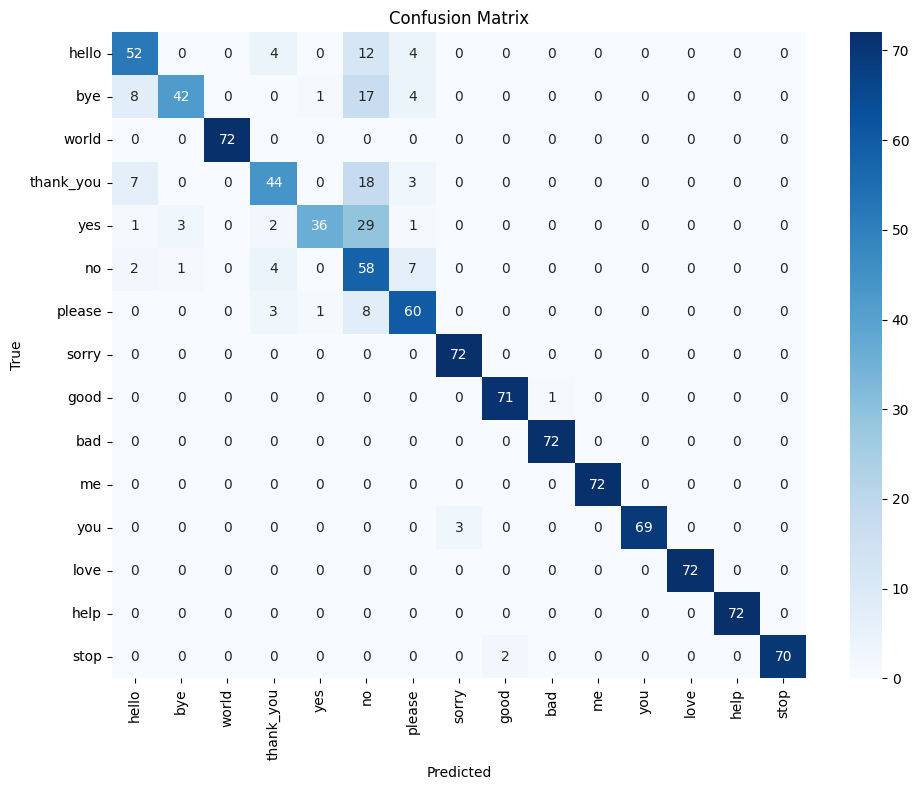

In [153]:
def evaluate_model(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for seqs, lengths, labels in data_loader:
            seqs    = seqs.to(device)
            lengths = lengths.to(device)
            labels  = labels.to(device)

            outputs = model(seqs, lengths)
            preds   = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ahora pasamos class_names (una lista de strings)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Accuracy: {acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


evaluate_model(model, val_loader, device, signs)


### Debug app

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle

# Load keypoint sequence
seq = np.load("../app/debug_sequence.npy")

# Load scaler and normalize
with open("../app/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
seq = (seq - scaler['mean']) / scaler['std']
tensor = torch.from_numpy(seq.astype(np.float32)).unsqueeze(0)

# Load model
#model = SignLSTM(input_size=126, hidden_size=128, num_layers=2, num_classes=15)
#model.load_state_dict(torch.load("../app/model.pth", map_location="cpu"))
model.load_state_dict(torch.load("best_model.pt", map_location="cpu"))
model.eval()

# Predict
with torch.no_grad():
    logits = model(tensor)
    probs = torch.softmax(logits, dim=1).numpy()[0]
    predicted_idx = int(probs.argmax())

# Load label encoder
with open("../app/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

print("🔍 Prediction:", le.inverse_transform([predicted_idx])[0])
print("Probabilities:")
for i, p in enumerate(probs):
    print(f"  {le.inverse_transform([i])[0]}: {p:.4f}")

🔍 Prediction: hello
Probabilities:
  bad: 0.0495
  bye: 0.0188
  good: 0.0010
  hello: 0.5703
  help: 0.0090
  love: 0.2750
  me: 0.0023
  no: 0.0015
  please: 0.0193
  sorry: 0.0032
  stop: 0.0002
  thank_you: 0.0086
  world: 0.0026
  yes: 0.0362
  you: 0.0025


#### output app 
```
✅ Keypoint sequence saved to debug_sequence.npy
Raw logits: tensor([[-0.9475,  0.4579,  1.5646, -0.6141,  7.0239,  0.4305, -1.7777, -2.6337,
         -2.9380,  0.2447, -1.1950, -1.7126,  1.9589, -0.2472, -0.5548]])
Probabilities:
  bad: 0.0003
  bye: 0.0014
  good: 0.0042
  hello: 0.0005
  help: 0.9831
  love: 0.0013
  me: 0.0001
  no: 0.0001
  please: 0.0000
  sorry: 0.0011
  stop: 0.0003
  thank_you: 0.0002
  world: 0.0062
  yes: 0.0007
  you: 0.0005
Prediction: help | Confidence: 0.9830814003944397
```

#### output sequencia app en NB

```
🔍 Prediction: love
Probabilities:
  bad: 0.0082
  bye: 0.0220
  good: 0.0231
  hello: 0.2244
  help: 0.0107
  love: 0.6110
  me: 0.0049
  no: 0.0004
  please: 0.0449
  sorry: 0.0044
  stop: 0.0030
  thank_you: 0.0017
  world: 0.0022
  yes: 0.0386
  you: 0.0006
```

la misma secuencia .npy genera dos predicciones diferentes en la app y en el notebook. Eso confirma que no es un problema de datos ni del modelo entrenado en sí, sino de inconsistencias entre los entornos o la forma en que se cargan los modelos y artefactos.
(La prediccion correcta es Love)